In [2]:
import os
import glob
import numpy as np 
import xarray as xr
import pandas as pd
import datetime
from datetime import date, timedelta
import dask
import re
import scipy.stats as stats
import scipy.signal as signal
from skimage.measure import find_contours
from statsmodels.tsa.stattools import acf, pacf

# Plotting utils 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cartopy
import cartopy.crs as ccrs
import seaborn as sns



In [3]:
def regrid_data(fromthis, tothis, method=1):
    """Regrid data using various different methods"""

    #Import necessary modules:
    import xarray as xr

    if method == 1:
        # kludgy: spatial regridding only, seems like can't automatically deal with time
        if 'time' in fromthis.coords:
            result = [fromthis.isel(time=t).interp_like(tothis) for t,time in enumerate(fromthis['time'])]
            result = xr.concat(result, 'time')
            return result
        else:
            return fromthis.interp_like(tothis)
    elif method == 2:
        newlat = tothis['lat']
        newlon = tothis['lon']
        coords = dict(fromthis.coords)
        coords['lat'] = newlat
        coords['lon'] = newlon
        return fromthis.interp(coords)
    elif method == 3:
        newlat = tothis['lat']
        newlon = tothis['lon']
        ds_out = xr.Dataset({'lat': newlat, 'lon': newlon})
        regridder = xe.Regridder(fromthis, ds_out, 'bilinear')
        return regridder(fromthis)
    elif method==4:
        # geocat
        newlat = tothis['lat']
        newlon = tothis['lon']
        result = geocat.comp.linint2(fromthis, newlon, newlat, False)
        result.name = fromthis.name
        
        return result

In [4]:
# Grabbed from Brian M. to use time midpoints, not end periods
def cesm_correct_time(ds):
    """Given a Dataset, check for time_bnds,
       and use avg(time_bnds) to replace the time coordinate.
       Purpose is to center the timestamp on the averaging inverval.   
       NOTE: ds should have been loaded using `decode_times=False`
    """
    assert 'time_bnds' in ds
    assert 'time' in ds
    correct_time_values = ds['time_bnds'].mean(dim='nbnd')
    # copy any metadata:
    correct_time_values.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time": correct_time_values})
    ds = xr.decode_cf(ds)  # decode to datetime objects
    return ds

# - - - - - - - - - - - - - - - 
# Pre-process data while reading in 
# - - - - - - - - - - - - - - - 

def preprocess(ds):
    dsCorr         = cesm_correct_time(ds)
    dsCorr         = dsCorr.sel(lat=slice(-10,10))
    
    return dsCorr


In [4]:
# import dask
# dask.config.set({'logging.distributed': 'error'})

# from dask_jobqueue import PBSCluster

# # For Casper
# cluster = PBSCluster(
#     queue="casper",
#     walltime="02:00:00",
#     project="P93300642",
#     memory="4GB",
#     resource_spec="select=1:ncpus=1:mem=4GB",
#     cores=1,
#     processes=1,
# )

# from dask.distributed import Client

# # Connect client to the remote dask workers
# client = Client(cluster)
# client

# cluster.scale(24)
# client.wait_for_workers(24)


## Read in CESM2/CESM1 PI-control data

In [5]:
cesm2_dir = '/glade/campaign/collections/cdg/data/CMIP6/CMIP/NCAR/CESM2/piControl/r1i1p1f1/Amon/ts/gn/files/d20190320/'
cesm1_dir = '/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly/TS/'

listFiles_cesm1 = np.sort(glob.glob(cesm1_dir+'b.e11.B1850C5CN.f09_g16.005.cam.h0.TS.*nc'))
listFiles_cesm2 = np.sort(glob.glob(cesm2_dir+'ts_Amon_CESM2_piControl_r1i1p1f1_gn*.nc'))

DS_all_cesm1 = xr.open_mfdataset(listFiles_cesm1, preprocess=preprocess, concat_dim='time', combine='nested', 
                                 decode_times=False, data_vars='minimal')

DS_all_cesm2 = xr.open_mfdataset(listFiles_cesm2, 
                                 preprocess=preprocess, concat_dim='time', combine='nested', 
                                 decode_times=False, data_vars='minimal')



/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/xarray/conventions.py:448: SerializationWarning: variable 'ts' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [6]:
%%time 

nYears_cesm1 = len(DS_all_cesm1.time.values)/12
nYears_cesm2 = len(DS_all_cesm2.time.values)/12
print('CESM1 has %i years.\nCESM2 has %i years.' % (nYears_cesm1,nYears_cesm2) )

n_spacing    = int(25)
nYearsPer    = int(50)
# nSamples  = int(np.floor(np.nanmin([((nYears_cesm1 - nYearsPer) // n_spacing + 1), ((nYears_cesm2 - nYearsPer) // n_spacing + 1)])) )
nSamples  = int(np.floor(np.nanmin([((nYears_cesm1 - nYearsPer) // n_spacing + 1), ((nYears_cesm2 - nYearsPer) // n_spacing + 1)])) )
print('Creating %i samples to compute ENSO over, starting every %i years and each with a window of %i years.' % (nSamples, n_spacing, nYearsPer))


#nStartInd = np.arange(0, nSamples*12, n_spacing*12)

# Create an empty array to store the reshaped data
events_cesm1 = np.zeros([nSamples, nYearsPer*12, len(DS_all_cesm1.lat.values), len(DS_all_cesm1.lon.values)])
events_cesm2 = np.zeros([nSamples, nYearsPer*12, len(DS_all_cesm2.lat.values), len(DS_all_cesm2.lon.values)])

# Create a new DataArray with the 'Event' axis
event_coords = np.arange(nSamples)
time_coords = np.arange(nYearsPer*12)

# DS_events_cesm1 = xr.DataArray(events_cesm1, coords=[event_coords, time_coords, DS_all_cesm1.lat.values, DS_all_cesm1.lon.values], 
#                                dims=["event", "time", "lat","lon"])

# DS_events_cesm2 = xr.DataArray(events_cesm2, coords=[event_coords, time_coords, DS_all_cesm2.lat.values, DS_all_cesm2.lon.values], 
                               # dims=["event", "time", "lat","lon"])

## Loop over the events and fill the new array
for iENSO in range(nSamples):
    start_year = iENSO * (n_spacing*12)
    events_cesm1[iENSO, :, :,:] = DS_all_cesm1.TS.isel(time=slice(start_year, (start_year + nYearsPer*12)))
    events_cesm2[iENSO, :, :,:] = DS_all_cesm2.ts.isel(time=slice(start_year, (start_year + nYearsPer*12)))

    # print('Starting with time index %i' % (start_year))




CESM1 has 1801 years.
CESM2 has 1200 years.
Creating 47 samples to compute ENSO over, starting every 25 years and each with a window of 50 years.
CPU times: user 1min 10s, sys: 3.36 s, total: 1min 14s
Wall time: 2min 41s


In [7]:
# Create a new DataArray with the 'Event' axis
event_coords = np.arange(nSamples)
time_coords  = DS_all_cesm1.time.values[17400:18000]

DS_cesm1_events = xr.DataArray(events_cesm1, coords=[event_coords, time_coords, DS_all_cesm1.lat.values, DS_all_cesm1.lon.values], 
                               dims=["event", "time", "lat","lon"])


DS_cesm2_events = xr.DataArray(events_cesm2, coords=[event_coords, time_coords, DS_all_cesm2.lat.values, DS_all_cesm2.lon.values], 
                               dims=["event", "time", "lat","lon"])


## Read in comparison table and make some summary plots


In [7]:
filePath = 'TableForm.csv'
df = pd.read_csv(filePath)

In [8]:
df_table = df

In [9]:
# ## Drop the first 054 case (row 10)
# df = df.drop(10)


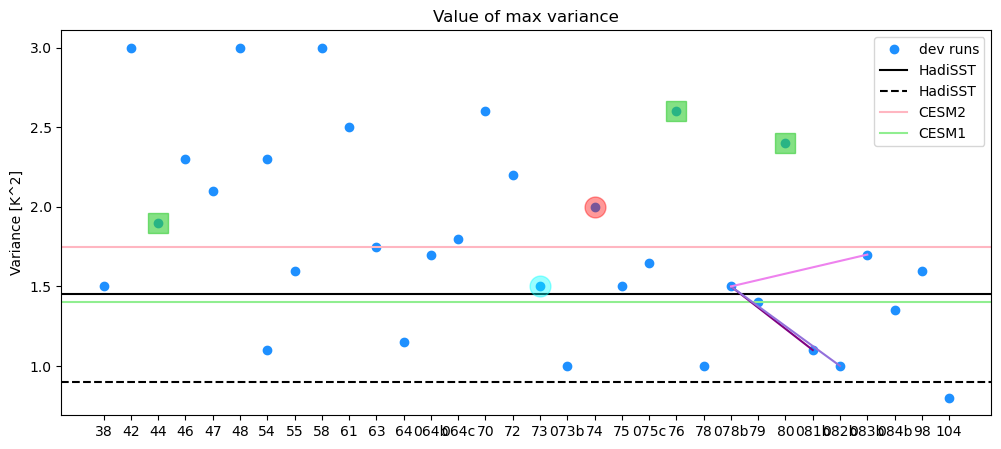

In [18]:
valArray = df['Value of max variance'].copy()
valArray[valArray=='>3'] = '3'

fig,axs=plt.subplots(1,1,figsize=(12,5))
axs.plot(df['Case Name'].values[4::], 
         valArray.values.astype(float)[4::], 'o', color='dodgerblue', label='dev runs')
axs.axhline(float(df['Value of max variance'].values[0]),color='k',label=df['Case Name'].values[0])
axs.axhline(float(df['Value of max variance'].values[1]),color='k',linestyle='--',label=df['Case Name'].values[1])
axs.axhline(float(df['Value of max variance'].values[2]),color='lightpink',linestyle='-',label=df['Case Name'].values[2])
axs.axhline(float(df['Value of max variance'].values[3]),color='lightgreen',linestyle='-',label=df['Case Name'].values[3])
axs.legend()

axs.set_title('Value of max variance')
axs.set_ylabel('Variance [K^2]')
# axs.set_xlabel('Simulation')

## Mark lineage of some runs
i78b = (np.where(df['Case Name'].values=='078b')[0]).astype(int)[0]
i3x = (np.where(df['Case Name'].values=='081b')[0]).astype(int)[0]
i1x = (np.where(df['Case Name'].values=='082b')[0]).astype(int)[0]
i0x = (np.where(df['Case Name'].values=='083b')[0]).astype(int)[0]

axs.plot([df['Case Name'].values[i78b], df['Case Name'].values[i3x]], [valArray.values.astype(float)[i78b],valArray.values.astype(float)[i3x]], 
         '-',color='purple')
axs.plot([df['Case Name'].values[i78b], df['Case Name'].values[i1x]], [valArray.values.astype(float)[i78b],valArray.values.astype(float)[i1x]], 
         '-',color='mediumpurple')
axs.plot([df['Case Name'].values[i78b], df['Case Name'].values[i0x]], [valArray.values.astype(float)[i78b],valArray.values.astype(float)[i0x]], 
         '-',color='violet')

for specCase in range(len(valArray.values)): 
    ## Mark Taus Code
    if ((df['Case Name'].values[specCase]=='44') | (df['Case Name'].values[specCase]=='76') | (df['Case Name'].values[specCase]=='80') ):
        axs.plot(df['Case Name'].values[specCase], valArray.values.astype(float)[specCase], 's', color='limegreen',alpha=0.6,markersize=15, label=None)
    ## Mark warm and cold branch starts 
    if (df['Case Name'].values[specCase]=='74'):
        axs.plot(df['Case Name'].values[specCase], valArray.values.astype(float)[specCase], 'o', color='red',alpha=0.4,markersize=15, label=None)
    if (df['Case Name'].values[specCase]=='73'):
        axs.plot(df['Case Name'].values[specCase], valArray.values.astype(float)[specCase], 'o', color='cyan',alpha=0.4,markersize=15, label=None)

    

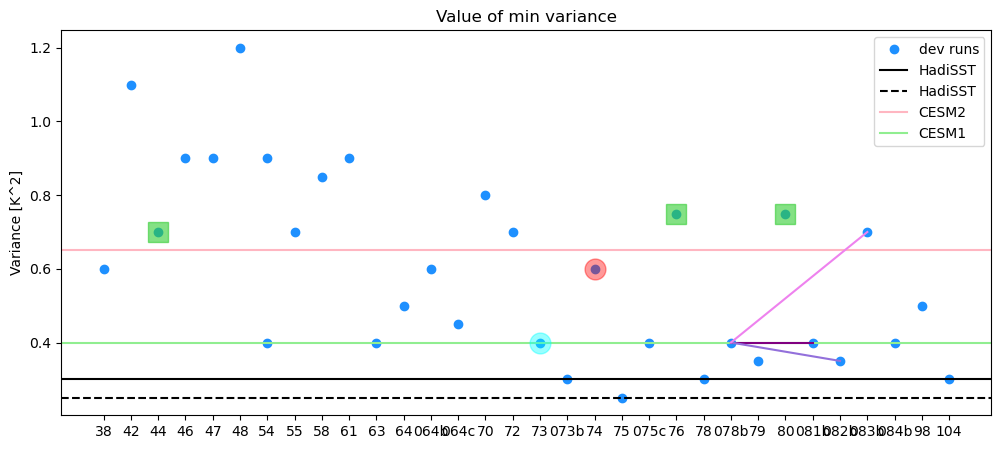

In [19]:
valArray = df['Value of min variance'].copy()


fig,axs=plt.subplots(1,1,figsize=(12,5))
axs.plot(df['Case Name'].values[4::], 
         valArray.values.astype(float)[4::], 'o', color='dodgerblue', label='dev runs')
axs.axhline(float(df['Value of min variance'].values[0]),color='k',label=df['Case Name'].values[0])
axs.axhline(float(df['Value of min variance'].values[1]),color='k',linestyle='--',label=df['Case Name'].values[1])
axs.axhline(float(df['Value of min variance'].values[2]),color='lightpink',linestyle='-',label=df['Case Name'].values[2])
axs.axhline(float(df['Value of min variance'].values[3]),color='lightgreen',linestyle='-',label=df['Case Name'].values[3])
axs.legend()

axs.set_title('Value of min variance')
axs.set_ylabel('Variance [K^2]')
# axs.set_xlabel('Simulation')

## Mark lineage of some runs
i78b = (np.where(df['Case Name'].values=='078b')[0]).astype(int)[0]
i3x = (np.where(df['Case Name'].values=='081b')[0]).astype(int)[0]
i1x = (np.where(df['Case Name'].values=='082b')[0]).astype(int)[0]
i0x = (np.where(df['Case Name'].values=='083b')[0]).astype(int)[0]

axs.plot([df['Case Name'].values[i78b], df['Case Name'].values[i3x]], [valArray.values.astype(float)[i78b],valArray.values.astype(float)[i3x]], 
         '-',color='purple')
axs.plot([df['Case Name'].values[i78b], df['Case Name'].values[i1x]], [valArray.values.astype(float)[i78b],valArray.values.astype(float)[i1x]], 
         '-',color='mediumpurple')
axs.plot([df['Case Name'].values[i78b], df['Case Name'].values[i0x]], [valArray.values.astype(float)[i78b],valArray.values.astype(float)[i0x]], 
         '-',color='violet')

for specCase in range(len(valArray.values)): 
    ## Mark Taus Code
    if ((df['Case Name'].values[specCase]=='44') | (df['Case Name'].values[specCase]=='76') | (df['Case Name'].values[specCase]=='80') ):
        axs.plot(df['Case Name'].values[specCase], valArray.values.astype(float)[specCase], 's', color='limegreen',alpha=0.6,markersize=15, label=None)
    ## Mark warm and cold branch starts 
    if (df['Case Name'].values[specCase]=='74'):
        axs.plot(df['Case Name'].values[specCase], valArray.values.astype(float)[specCase], 'o', color='red',alpha=0.4,markersize=15, label=None)
    if (df['Case Name'].values[specCase]=='73'):
        axs.plot(df['Case Name'].values[specCase], valArray.values.astype(float)[specCase], 'o', color='cyan',alpha=0.4,markersize=15, label=None)




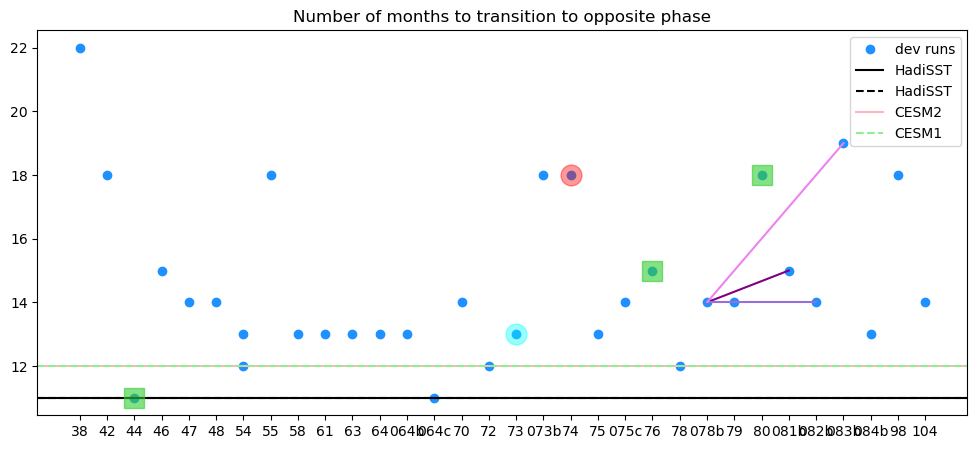

In [20]:
valArray = df['Transition to opposite phase \n(months)'].copy()

for iSims in range(len(valArray.values)):
    if str(valArray[iSims])[0]=='~':
        valArray[iSims] = str(valArray[iSims])[1:]

fig,axs=plt.subplots(1,1,figsize=(12,5))
axs.plot(df['Case Name'].values[4::], 
         valArray.values.astype(float)[4::], 'o', color='dodgerblue', label='dev runs')
axs.axhline(float(valArray.values[0]),color='k',label=df['Case Name'].values[0])
axs.axhline(float(valArray.values[1]),color='k',linestyle='--',label=df['Case Name'].values[1])
axs.axhline(float(valArray.values[2]),color='lightpink',linestyle='-',label=df['Case Name'].values[2])
axs.axhline(float(valArray.values[3]),color='lightgreen',linestyle='--',label=df['Case Name'].values[3])
axs.legend()

axs.set_title('Number of months to transition to opposite phase')


## Mark lineage of some runs
i78b = (np.where(df['Case Name'].values=='078b')[0]).astype(int)[0]
i3x = (np.where(df['Case Name'].values=='081b')[0]).astype(int)[0]
i1x = (np.where(df['Case Name'].values=='082b')[0]).astype(int)[0]
i0x = (np.where(df['Case Name'].values=='083b')[0]).astype(int)[0]

axs.plot([df['Case Name'].values[i78b], df['Case Name'].values[i3x]], [valArray.values.astype(float)[i78b],valArray.values.astype(float)[i3x]], 
         '-',color='purple')
axs.plot([df['Case Name'].values[i78b], df['Case Name'].values[i1x]], [valArray.values.astype(float)[i78b],valArray.values.astype(float)[i1x]], 
         '-',color='mediumpurple')
axs.plot([df['Case Name'].values[i78b], df['Case Name'].values[i0x]], [valArray.values.astype(float)[i78b],valArray.values.astype(float)[i0x]], 
         '-',color='violet')

for specCase in range(len(valArray.values)): 
    ## Mark Taus Code
    if ((df['Case Name'].values[specCase]=='44') | (df['Case Name'].values[specCase]=='76') | (df['Case Name'].values[specCase]=='80') ):
        axs.plot(df['Case Name'].values[specCase], valArray.values.astype(float)[specCase], 's', color='limegreen',alpha=0.6,markersize=15, label=None)
    ## Mark warm and cold branch starts 
    if (df['Case Name'].values[specCase]=='74'):
        axs.plot(df['Case Name'].values[specCase], valArray.values.astype(float)[specCase], 'o', color='red',alpha=0.4,markersize=15, label=None)
    if (df['Case Name'].values[specCase]=='73'):
        axs.plot(df['Case Name'].values[specCase], valArray.values.astype(float)[specCase], 'o', color='cyan',alpha=0.4,markersize=15, label=None)

    

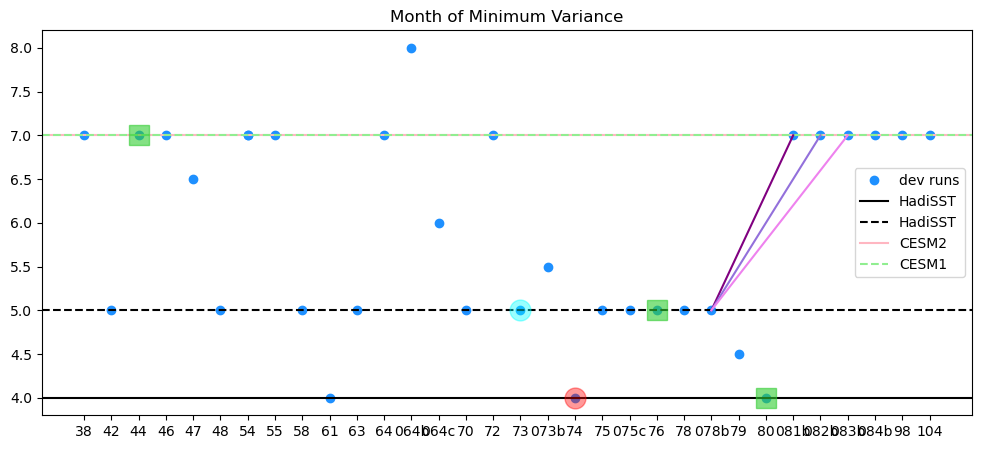

In [21]:
df['Month of min variance_number'] = df['Month of min variance'].copy()

for iVal in range(len(df['Month of min variance_number'])):
    if df['Month of min variance_number'].values[iVal]=='May':
        df['Month of min variance_number'].values[iVal] = 5
    elif df['Month of min variance_number'].values[iVal]=='Apr':
        df['Month of min variance_number'].values[iVal] = 4
    elif df['Month of min variance_number'].values[iVal]=='Jul':
        df['Month of min variance_number'].values[iVal] = 7
    elif df['Month of min variance_number'].values[iVal]=='Jun':
        df['Month of min variance_number'].values[iVal] = 6
    elif df['Month of min variance_number'].values[iVal]=='Aug':
        df['Month of min variance_number'].values[iVal] = 8
    elif df['Month of min variance_number'].values[iVal]=='Jun/Jul':
        df['Month of min variance_number'].values[iVal] = 6.5
    elif df['Month of min variance_number'].values[iVal]=='May-Jun':
        df['Month of min variance_number'].values[iVal] = 5.5
    elif df['Month of min variance_number'].values[iVal]=='Apr-May':
        df['Month of min variance_number'].values[iVal] = 4.5

valArray = df['Month of min variance_number']

fig,axs=plt.subplots(1,1,figsize=(12,5))
axs.plot(df['Case Name'].values[4::], 
         valArray.values.astype(float)[4::], 'o', color='dodgerblue', label='dev runs')
axs.axhline(float(valArray.values[0]),color='k',label=df['Case Name'].values[0])
axs.axhline(float(valArray.values[1]),color='k',linestyle='--',label=df['Case Name'].values[1])
axs.axhline(float(valArray.values[2]),color='lightpink',linestyle='-',label=df['Case Name'].values[2])
axs.axhline(float(valArray.values[3]),color='lightgreen',linestyle='--',label=df['Case Name'].values[3])
axs.legend()

axs.set_title('Month of Minimum Variance')

## Mark lineage of some runs
i78b = (np.where(df['Case Name'].values=='078b')[0]).astype(int)[0]
i3x = (np.where(df['Case Name'].values=='081b')[0]).astype(int)[0]
i1x = (np.where(df['Case Name'].values=='082b')[0]).astype(int)[0]
i0x = (np.where(df['Case Name'].values=='083b')[0]).astype(int)[0]

axs.plot([df['Case Name'].values[i78b], df['Case Name'].values[i3x]], [valArray.values.astype(float)[i78b],valArray.values.astype(float)[i3x]], 
         '-',color='purple')
axs.plot([df['Case Name'].values[i78b], df['Case Name'].values[i1x]], [valArray.values.astype(float)[i78b],valArray.values.astype(float)[i1x]], 
         '-',color='mediumpurple')
axs.plot([df['Case Name'].values[i78b], df['Case Name'].values[i0x]], [valArray.values.astype(float)[i78b],valArray.values.astype(float)[i0x]], 
         '-',color='violet')

for specCase in range(len(valArray.values)): 
    ## Mark Taus Code
    if ((df['Case Name'].values[specCase]=='44') | (df['Case Name'].values[specCase]=='76') | (df['Case Name'].values[specCase]=='80') ):
        axs.plot(df['Case Name'].values[specCase], valArray.values.astype(float)[specCase], 's', color='limegreen',alpha=0.6,markersize=15, label=None)
    ## Mark warm and cold branch starts 
    if (df['Case Name'].values[specCase]=='74'):
        axs.plot(df['Case Name'].values[specCase], valArray.values.astype(float)[specCase], 'o', color='red',alpha=0.4,markersize=15, label=None)
    if (df['Case Name'].values[specCase]=='73'):
        axs.plot(df['Case Name'].values[specCase], valArray.values.astype(float)[specCase], 'o', color='cyan',alpha=0.4,markersize=15, label=None)




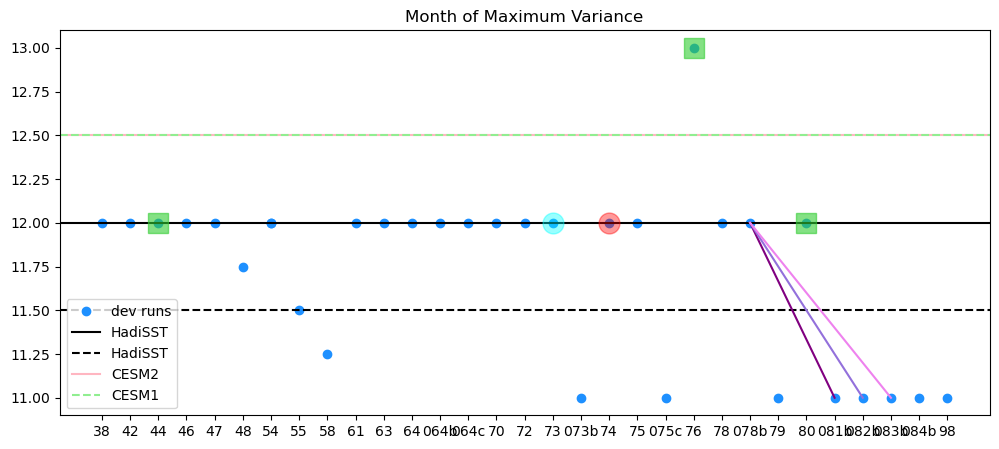

In [215]:
df['Month of max variance_number'] = df['Month of max variance'].copy()

for iVal in range(len(df['Month of max variance_number'])):
    if df['Month of max variance_number'].values[iVal]=='Dec':
        df['Month of max variance_number'].values[iVal] = 12
    elif df['Month of max variance_number'].values[iVal]=='Jan':
        df['Month of max variance_number'].values[iVal] = 13
    elif df['Month of max variance_number'].values[iVal]=='Nov':
        df['Month of max variance_number'].values[iVal] = 11
    elif df['Month of max variance_number'].values[iVal]=='Nov/Dec':
        df['Month of max variance_number'].values[iVal] = 11.5
    elif df['Month of max variance_number'].values[iVal]=='Dec-Jan':
        df['Month of max variance_number'].values[iVal] = 12.5
    elif df['Month of max variance_number'].values[iVal]=='Nov-Jan':
        df['Month of max variance_number'].values[iVal] = 11.75
    elif df['Month of max variance_number'].values[iVal]=='Oct-Jan':
        df['Month of max variance_number'].values[iVal] = 11.25

valArray = df['Month of max variance_number']
valArray

fig,axs=plt.subplots(1,1,figsize=(12,5))
axs.plot(df['Case Name'].values[4::], 
         valArray.values.astype(float)[4::], 'o', color='dodgerblue', label='dev runs')
axs.axhline(float(valArray.values[0]),color='k',label=df['Case Name'].values[0])
axs.axhline(float(valArray.values[1]),color='k',linestyle='--',label=df['Case Name'].values[1])
axs.axhline(float(valArray.values[2]),color='lightpink',linestyle='-',label=df['Case Name'].values[2])
axs.axhline(float(valArray.values[3]),color='lightgreen',linestyle='--',label=df['Case Name'].values[3])
axs.legend()

axs.set_title('Month of Maximum Variance')

## Mark lineage of some runs
i78b = (np.where(df['Case Name'].values=='078b')[0]).astype(int)[0]
i3x = (np.where(df['Case Name'].values=='081b')[0]).astype(int)[0]
i1x = (np.where(df['Case Name'].values=='082b')[0]).astype(int)[0]
i0x = (np.where(df['Case Name'].values=='083b')[0]).astype(int)[0]

axs.plot([df['Case Name'].values[i78b], df['Case Name'].values[i3x]], [valArray.values.astype(float)[i78b],valArray.values.astype(float)[i3x]], 
         '-',color='purple')
axs.plot([df['Case Name'].values[i78b], df['Case Name'].values[i1x]], [valArray.values.astype(float)[i78b],valArray.values.astype(float)[i1x]], 
         '-',color='mediumpurple')
axs.plot([df['Case Name'].values[i78b], df['Case Name'].values[i0x]], [valArray.values.astype(float)[i78b],valArray.values.astype(float)[i0x]], 
         '-',color='violet')

for specCase in range(len(valArray.values)): 
    ## Mark Taus Code
    if ((df['Case Name'].values[specCase]=='44') | (df['Case Name'].values[specCase]=='76') | (df['Case Name'].values[specCase]=='80') ):
        axs.plot(df['Case Name'].values[specCase], valArray.values.astype(float)[specCase], 's', color='limegreen',alpha=0.6,markersize=15, label=None)
    ## Mark warm and cold branch starts 
    if (df['Case Name'].values[specCase]=='74'):
        axs.plot(df['Case Name'].values[specCase], valArray.values.astype(float)[specCase], 'o', color='red',alpha=0.4,markersize=15, label=None)
    if (df['Case Name'].values[specCase]=='73'):
        axs.plot(df['Case Name'].values[specCase], valArray.values.astype(float)[specCase], 'o', color='cyan',alpha=0.4,markersize=15, label=None)




### Limit to data that has history files still available

In [20]:
# new_df = df[~df["Nyrs available history"].str.contains('Climo', na=False)]
new_df = df[df["Nyrs available history"].str.contains('all', na=False)]


In [21]:
new_df

Case Name Years analyzed            Nyrs available history  \
11        54      0075-0103                  1-152 \n(all h*)   
16        64      0001-0059                   1-59 \n(all h*)   
17      064b      0043-0069                   43-68\n(all h*)   
18      064c      0043-0069                   43-68\n(all h*)   
24        75      0001-0043                  1-125 \n(all h*)   
25      075c      0001-0051  1-50 \n(all h*)\nGustavo scratch   
26        76      0001-0042                   1-81 \n(all h*)   
27        78      0001-0049                   1-48 \n(all h*)   
28      078b      0001-0031                   1-95 \n(all h*)   
29        79      0001-0049   1-48 \n(all h*)\nCecile scratch   
31      081b      0001-0035   1-62 \n(all h*)\nCecile scratch   
32      082b      0001-0031   1-63 \n(all h*)\nCecile scratch   
33      083b      0001-0033   1-62 \n(all h*)\nCecile scratch   
34      084b      0001-0035   1-50 \n(all h*)\nCecile scratch   
35        98      0001-0151  1-254 \n(all h*)\nCecile scratch   

   Transition to opposite phase \n(months) Value of max variance  \
11                                      12                   1.1   
16                                     ~13                  1.15   
17                                     ~13                   1.7   
18                                     ~11                   1.8   
24                                     ~13                   1.5   
25                                     ~14                  1.65   
26                                     ~15                   2.6   
27                                      12                     1   
28                                     ~14                   1.5   
29                                     ~14                   1.4   
31                                     ~15                   1.1   
32                                     ~14                     1   
33                                     ~19                   1.7   
34                                     ~13                  1.35   
35                                     ~18                   1.6   

   Month of max variance  Value of min variance Month of min variance  \
11                   Dec                   0.40                   Jul   
16                   Dec                   0.50                   Jul   
17                   Dec                   0.60                   Aug   
18                   Dec                   0.45                   Jun   
24                   Dec                   0.25                   May   
25                   Nov                   0.40                   May   
26                   Jan                   0.75                   May   
27                   Dec                   0.30                   May   
28                   Dec                   0.40                   May   
29                   Nov                   0.35               Apr-May   
31                   Nov                   0.40                   Jul   
32                   Nov                   0.35                   Jul   
33                   Nov                   0.70                   Jul   
34                   Nov                   0.40                   Jul   
35                   Nov                   0.50                   Jul   

                                                Notes  
11                     New baseline: cesm2_3_alpha16g  
16                    054+Gustiness (old calculation)  
17                                 ? ensemble of 064?  
18                                 ? ensemble of 064?  
24                                 Retune cold branch  
25  075 twin+new initial conditions from 0055 (wit...  
26                  Retune warm branch with taus code  
27                    075 (cold branch)+faster dycore  
28  ?? “Starting Lscale branch from a spunup state...  
29                             078+Rougher topography  
31                           078b+Gustiness (new), 3x  
32                           078

Text(0.345, -0.02, 'Retune\nCold\nBranch')

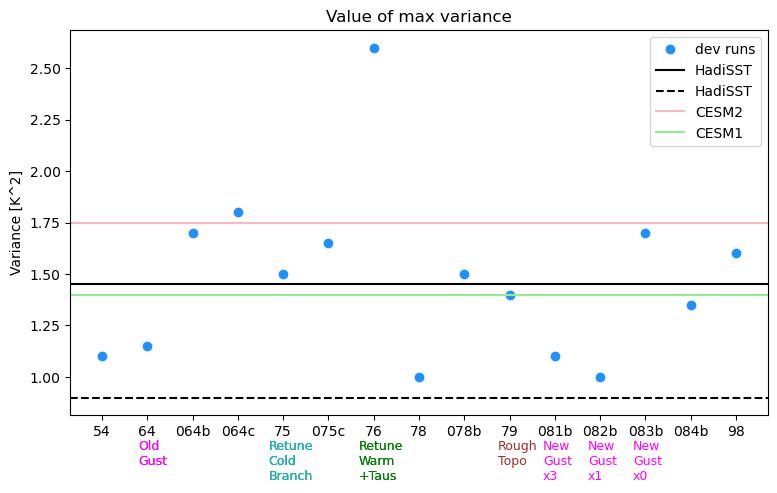

In [87]:
fig,axs=plt.subplots(1,1,figsize=(9,5))
axs.plot(new_df['Case Name'], 
         new_df['Value of max variance'].values.astype(float), 'o', color='dodgerblue', label='dev runs')
axs.axhline(float(df['Value of max variance'].values[0]),color='k',label=df['Case Name'].values[0])
axs.axhline(float(df['Value of max variance'].values[1]),color='k',linestyle='--',label=df['Case Name'].values[1])
axs.axhline(float(df['Value of max variance'].values[2]),color='lightpink',linestyle='-',label=df['Case Name'].values[2])
axs.axhline(float(df['Value of max variance'].values[3]),color='lightgreen',linestyle='-',label=df['Case Name'].values[3])
axs.legend()

axs.set_title('Value of max variance')
axs.set_ylabel('Variance [K^2]')
# axs.set_xlabel('Simulation')

plt.gcf().text(0.2, 0.01, 'Old\nGust', fontsize=9, color='magenta')
plt.gcf().text(0.345, -0.02, 'Retune\nCold\nBranch', fontsize=9, color='lightseagreen')
plt.gcf().text(0.445, -0.02, 'Retune\nWarm\n+Taus', fontsize=9, color='green')

plt.gcf().text(0.2, 0.01, 'Old\nGust', fontsize=9, color='magenta')
plt.gcf().text(0.345, -0.02, 'Retune\nCold\nBranch', fontsize=9, color='lightseagreen')
plt.gcf().text(0.445, -0.02, 'Retune\nWarm\n+Taus', fontsize=9, color='green')
plt.gcf().text(0.6, 0.01, 'Rough\nTopo', fontsize=9, color='brown')
plt.gcf().text(0.65, -0.02, 'New\nGust\nx3', fontsize=9, color='magenta')
plt.gcf().text(0.7, -0.02, 'New\nGust\nx1', fontsize=9, color='magenta')
plt.gcf().text(0.75, -0.02, 'New\nGust\nx0', fontsize=9, color='magenta')
plt.gcf().text(0.345, -0.02, 'Retune\nCold\nBranch', fontsize=9, color='lightseagreen')

Text(0.75, -0.02, 'New\nGust\nx0')

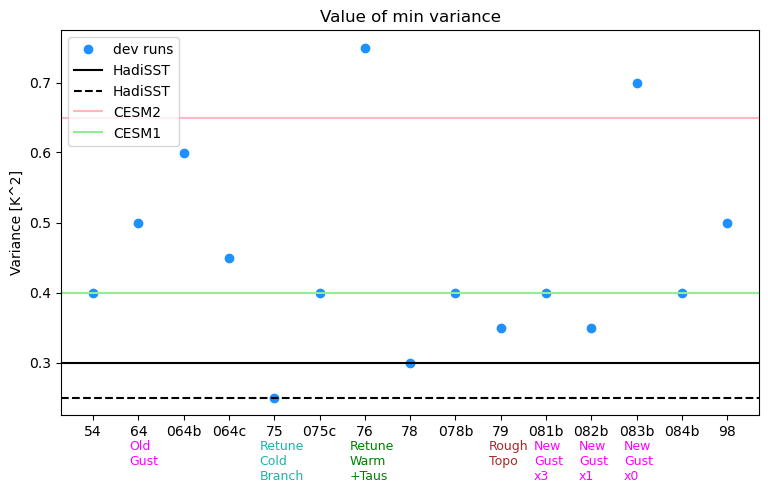

In [86]:
fig,axs=plt.subplots(1,1,figsize=(9,5))
axs.plot(new_df['Case Name'], 
         new_df['Value of min variance'].values.astype(float), 'o', color='dodgerblue', label='dev runs')
axs.axhline(float(df['Value of min variance'].values[0]),color='k',label=df['Case Name'].values[0])
axs.axhline(float(df['Value of min variance'].values[1]),color='k',linestyle='--',label=df['Case Name'].values[1])
axs.axhline(float(df['Value of min variance'].values[2]),color='lightpink',linestyle='-',label=df['Case Name'].values[2])
axs.axhline(float(df['Value of min variance'].values[3]),color='lightgreen',linestyle='-',label=df['Case Name'].values[3])
axs.legend()

axs.set_title('Value of min variance')
axs.set_ylabel('Variance [K^2]')
# axs.set_xlabel('Simulation')

plt.gcf().text(0.2, 0.01, 'Old\nGust', fontsize=9, color='magenta')
plt.gcf().text(0.345, -0.02, 'Retune\nCold\nBranch', fontsize=9, color='lightseagreen')
plt.gcf().text(0.445, -0.02, 'Retune\nWarm\n+Taus', fontsize=9, color='green')
plt.gcf().text(0.6, 0.01, 'Rough\nTopo', fontsize=9, color='brown')
plt.gcf().text(0.65, -0.02, 'New\nGust\nx3', fontsize=9, color='magenta')
plt.gcf().text(0.7, -0.02, 'New\nGust\nx1', fontsize=9, color='magenta')
plt.gcf().text(0.75, -0.02, 'New\nGust\nx0', fontsize=9, color='magenta')
plt.gcf().text(0.345, -0.02, 'Retune\nCold\nBranch', fontsize=9, color='lightseagreen')


## Make lag correlation plots and use metric from those

In [8]:
## Some basics - the region to focus on, for one
lat_n = 10.0
lat_s = -10.0

# Nino3.4
lat_n34 = 5
lat_s34 = -5
lon_e34 = 190 
lon_w34 = 240

# Nino3
lat_n3 = 5
lat_s3 = -5
lon_e3 = 210 
lon_w3 = 270

# nregions     = (/0.,         5.,     5.,    5.,   5.,   16./)
# sregions     = (/-10.,      -5.,    -5.,   -5.,  -5.,    8./)
# wregions     = (/270.,      210.,   190.,  160., 120., 140./)
# eregions     = (/280.,      270.,   240.,  210., 140., 160./)
# plot_regions = (/"nino1+2","nino3","nino3.4","nino4","nino5","nino6"/)



In [9]:
## Calculate nino anomalies 
def rmMonAnnCyc(DS): 
    
    climatology = DS.groupby("time.month").mean("time")
    anomalies   = DS.groupby("time.month") - climatology    

    return anomalies

def getLagCorr(lag, nino34, corDS):

    if lag>0: 
        A  = nino34[:-lag]
        # B  = sst_anom.isel(case=iCase).shift(time=lag).isel(time=slice(lag,len(sst_anom.time.values)))
        # B['time'] = sst_anom.time.values[:-lag]  # To get xr.corr to work, need to have the "same" time for computing corrs
        B  = corDS.shift(time=-lag).isel(time=slice(0,len(corDS.time.values)-lag))
        B['time'] = corDS.time.values[:-lag]  # To get xr.corr to work, need to have the "same" time for computing corrs
    elif lag<0:
        A  = nino34[-lag:]
        A['time'] = nino34.time.values[:lag]
        B  = corDS.isel(time=slice(0,len(corDS.time.values)+lag))
    elif lag==0:
        A = nino34
        B = corDS
            
    cor = xr.corr(A, B, dim="time")

    return cor

def getLagCorr_obs(lag):

    if lag>0: 
        A  = nino34_obs[:-lag]
        B  = sstObs_anom.shift(time=-lag).isel(time=slice(0,len(sstObs_anom.time.values)-lag))
        B['time'] = sstObs_anom.time.values[:-lag]  # To get xr.corr to work, need to have the "same" time for computing corrs
    elif lag<0:
        A  = nino34_obs[-lag:]
        A['time'] = nino34_obs.time.values[:lag]
        B  = sstObs_anom.isel(time=slice(0,len(sstObs_anom.time.values)+lag))
    elif lag==0:
        A = nino34_obs
        B = sstObs_anom
            
    cor = xr.corr(A, B, dim="time")

    return cor
    

In [10]:
def plotLagCorr(DS, caseName): 

    # Updating limit of ocnfrac used to determine mask
    ocnMask = DS.LANDFRAC.values
    ocnMask[ocnMask>0.45] = np.nan
    ocnMask[ocnMask<=0.45] = 1
    
    # Detrend data 
    TS = DS.TS 
    ts = signal.detrend(TS, axis=0, type='linear')
    # Get SST 
    sst = ts * ocnMask
    
    sst = xr.DataArray(sst, 
        coords={'time': DS.time.values,
                'lat':  DS.lat.values, 
                'lon':  DS.lon.values}, 
        dims=["time", "lat", "lon"])
    
    
    # Remove annual cycle from monthly data 
    sst_anom = rmMonAnnCyc(sst)
    
    ## Compute nino 3.4 index
    
    ilats = np.where((sst_anom.lat.values>=lat_s34)  & (sst_anom.lat.values<=lat_n34))[0]
    ilons = np.where((sst_anom.lon.values>=lon_e34)  & (sst_anom.lon.values<=lon_w34))[0]
    
    # Compute weights and get Nino3.4 
    regionTS = sst_anom.isel(lat=ilats, lon=ilons)
    coswgt   = np.cos(np.deg2rad(regionTS.lat))
    
    nino34   = regionTS.weighted(coswgt).mean(('lon','lat'))

    
    ## COMPUE CORRELATION 
    cor_case = getLagCorr(0, nino34, sst_anom)


    
    ## Make plot 
    fig,axs = plt.subplots(1,1, figsize=(10,11), subplot_kw={"projection":ccrs.PlateCarree(central_longitude=210)})
    pltLims = np.arange(-1,1.1,0.1)
    
    # Contour 
    c1 = axs.contourf(sst_anom.lon.values,sst_anom.lat.values ,  cor_case, pltLims,
                       cmap='RdYlBu_r', transform=ccrs.PlateCarree() ) 
    c2 = axs.contour(sst_anom.lon.values,sst_anom.lat.values ,  cor_case, [0], transform=ccrs.PlateCarree())
    
    # Add colorbar 
    cax = axs.inset_axes([0, -0.23, 1, 0.09])  # THE NEW AXES, x, y, width, height,
    cbar = fig.colorbar(c1, cax = cax, orientation="horizontal")
    
    axs.coastlines()     
    axs.add_patch(patches.Rectangle(xy=[lon_e34, lat_s34], width=(lon_w34-lon_e34), height=(lat_n34-lat_s34),
                                facecolor='none', edgecolor='k',linestyle='--',
                                linewidth=1, transform=ccrs.PlateCarree()))
    axs.set_extent([53,300,-15,15], crs=ccrs.PlateCarree())
    axs.set_title(str(caseName)+'\nLag 0 SST-Nino3.4 Correlation')

    ## Figure out western-most longitude of zero contour in pacific 
    corrs_sel = cor_case.sel(lon=slice(120,300))
    corrs_sel = corrs_sel.sel(lat=slice(-5,5))
    contours = find_contours(corrs_sel.values, level=0)

    western_most_point_case = None
    inflection_lon = np.inf
    
    for contour in contours:
        for ipoint in range(len(contour)):
            lat_index, lon_index = contour[ipoint]
            lon = corrs_sel['lon'].values[int(lon_index)]
            lat = corrs_sel['lat'].values[int(lat_index)]
            # print(lat,lon)
    
            if lon<inflection_lon:
                inflection_lon = lon
            elif lon>inflection_lon:
                lat_index, lon_index = contour[ipoint-1]
                lon = corrs_sel['lon'].values[int(lon_index)]
                western_most_point_case = (corrs_sel['lat'].values[int(lat_index)], lon)
                break 
                    
    print(f"Western-most point in case: {western_most_point_case}")
    
    axs.plot(float(lon), float(corrs_sel['lat'].values[int(lat_index)]), 'o', color='limegreen', markersize=5, transform=ccrs.PlateCarree() )


    ## Figure out western-most longitude of 0.5 contour in pacific 
    corrs_sel = cor_case.sel(lon=slice(120,240))
    corrs_sel = corrs_sel.sel(lat=slice(-5,5))
    contours = find_contours(corrs_sel.values, level=0.5)

    western_most_point_case = None
    inflection_lon = np.inf
    
    for contour in contours:
        for ipoint in range(len(contour)):
            lat_index, lon_index = contour[ipoint]
            lon = corrs_sel['lon'].values[int(lon_index)]
            lat = corrs_sel['lat'].values[int(lat_index)]
            # print(lat,lon)
    
            if lon<inflection_lon:
                inflection_lon = lon
            elif lon>inflection_lon:
                lat_index, lon_index = contour[ipoint-1]
                lon = corrs_sel['lon'].values[int(lon_index)]
                western_most_point_case = (corrs_sel['lat'].values[int(lat_index)], lon)
                break 
                    
    print(f"Western-most point in case: {western_most_point_case}")
    
    axs.plot(float(lon), float(corrs_sel['lat'].values[int(lat_index)]), 's', color='mediumorchid', markersize=5, transform=ccrs.PlateCarree() )
    
    plt.show()
    # plt.savefig("Figures/LagCorrelations/"+caseName+'_LagPos9_sstVSnino34.png', format='png', dpi=300)
    plt.close()
    
    return cor_case, sst_anom
    

In [11]:
# dataDir = '/glade/derecho/scratch/rneale/enso_wavelet/'

# listFiles_TS = np.sort(glob.glob(dataDir+'*BLT1850.ne30_t232*cam.h0*TS.*.nc'))
# listFiles_TS

Western-most point in case: (0.4712041884816793, 123.75)
Western-most point in case: (-0.4712041884816665, 146.25000000000003)


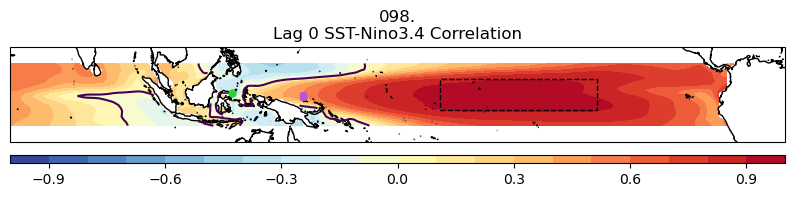

Western-most point in case: (-4.240837696335076, 132.5)
Western-most point in case: (0.4712041884816793, 143.75)


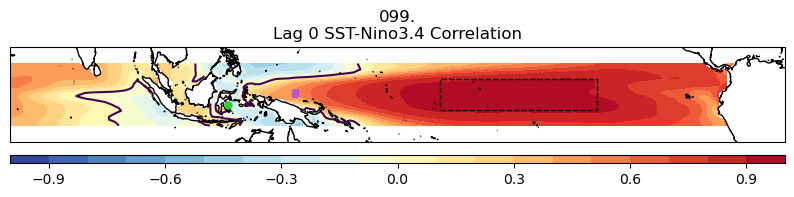

Western-most point in case: (0.4712041884816793, 132.5)
Western-most point in case: (0.4712041884816793, 148.75)


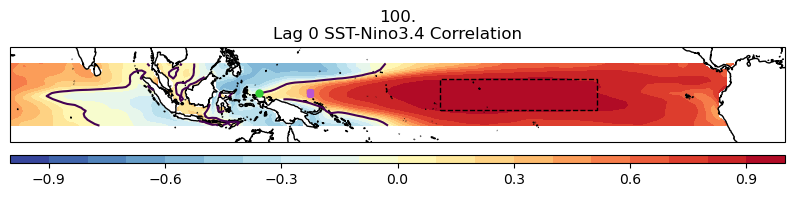

Western-most point in case: (0.4712041884816793, 132.5)
Western-most point in case: (0.4712041884816793, 145.00000000000003)


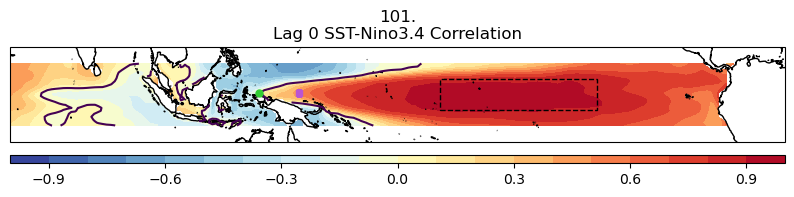

Western-most point in case: (-0.4712041884816665, 145.00000000000003)
Western-most point in case: (-0.4712041884816665, 157.5)


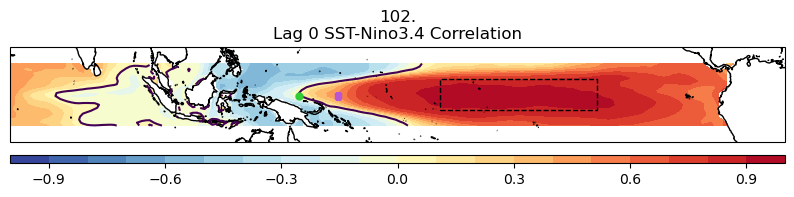

Western-most point in case: (0.4712041884816793, 131.25)
Western-most point in case: (-0.4712041884816665, 147.5)


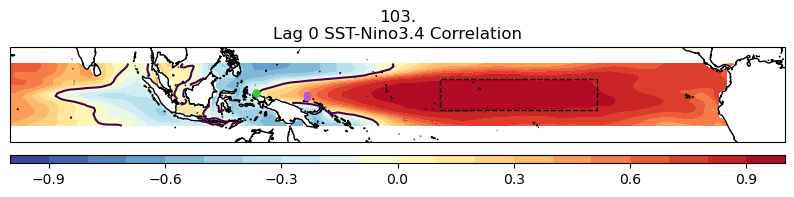

Western-most point in case: (-1.4136125654450251, 130.0)
Western-most point in case: (0.4712041884816793, 146.25000000000003)


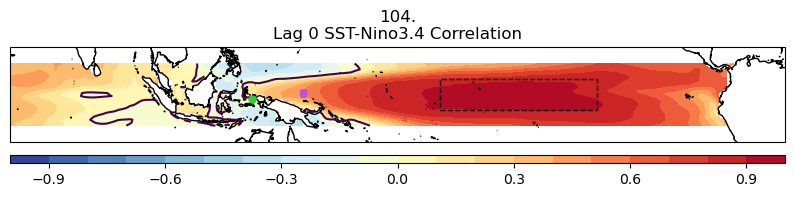

Western-most point in case: (-0.4712041884816665, 126.25000000000001)
Western-most point in case: (-0.4712041884816665, 146.25000000000003)


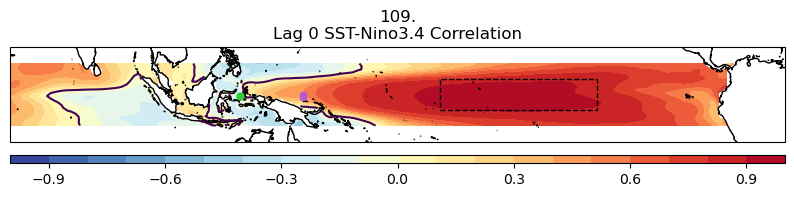

In [12]:
dataDir = '/glade/derecho/scratch/rneale/enso_wavelet/'

# listFiles_TS = np.sort(glob.glob(dataDir+'*BLT1850.ne30_t232*cam.h0*TS.*.nc'))
listFiles_TS = np.asarray((
      [
       # '/glade/derecho/scratch/rneale/enso_wavelet/b.e23_alpha16b.BLT1850.ne30_t232.038.cam.h0.TS.1-60.10.N-10.S.nc',
       # '/glade/derecho/scratch/rneale/enso_wavelet/b.e23_alpha16b.BLT1850.ne30_t232.042.cam.h0.TS.0001-0049.10.N-10.S.nc',
       # '/glade/derecho/scratch/rneale/enso_wavelet/b.e23_alpha16b.BLT1850.ne30_t232.044.cam.h0.TS.1-44.10.N-10.S.nc',
       # '/glade/derecho/scratch/rneale/enso_wavelet/b.e23_alpha16b.BLT1850.ne30_t232.046.cam.h0.TS.1-70.10.N-10.S.nc',
       # '/glade/derecho/scratch/rneale/enso_wavelet/b.e23_alpha16b.BLT1850.ne30_t232.047.cam.h0.TS.1-70.10.N-10.S.nc',
       # '/glade/derecho/scratch/rneale/enso_wavelet/b.e23_alpha16b.BLT1850.ne30_t232.048.cam.h0.TS.0001-0036.10.N-10.S.nc',
       # '/glade/derecho/scratch/rneale/enso_wavelet/b.e23_alpha16b.BLT1850.ne30_t232.054.cam.h0.TS.1-102.10.N-10.S.nc',
       # '/glade/derecho/scratch/rneale/enso_wavelet/b.e23_alpha16g.BLT1850.ne30_t232.055.cam.h0.TS.1-100.10.N-10.S.nc',
       # '/glade/derecho/scratch/rneale/enso_wavelet/b.e23_alpha16g.BLT1850.ne30_t232.058.cam.h0.TS.1-16.10.N-10.S.nc',
       # '/glade/derecho/scratch/rneale/enso_wavelet/b.e23_alpha16g.BLT1850.ne30_t232.061.cam.h0.TS.1-48.10.N-10.S.nc',
       # '/glade/derecho/scratch/rneale/enso_wavelet/b.e23_alpha16g.BLT1850.ne30_t232.063.cam.h0.TS.1-24.10.N-10.S.nc',
       # '/glade/derecho/scratch/rneale/enso_wavelet/b.e23_alpha16g.BLT1850.ne30_t232.064.cam.h0.TS.1-58.10.N-10.S.nc',
       # '/glade/derecho/scratch/rneale/enso_wavelet/b.e23_alpha16g.BLT1850.ne30_t232.064b.cam.h0.TS.43-68.10.N-10.S.nc',
       # '/glade/derecho/scratch/rneale/enso_wavelet/b.e23_alpha16g.BLT1850.ne30_t232.064c.cam.h0.TS.43-68.10.N-10.S.nc',
       # '/glade/derecho/scratch/rneale/enso_wavelet/b.e23_alpha16g.BLT1850.ne30_t232.067.cam.h0.TS.1-23.10.N-10.S.nc',
       # '/glade/derecho/scratch/rneale/enso_wavelet/b.e23_alpha16g.BLT1850.ne30_t232.070.cam.h0.TS.1-26.10.N-10.S.nc',
       # '/glade/derecho/scratch/rneale/enso_wavelet/b.e23_alpha16g.BLT1850.ne30_t232.072.cam.h0.TS.1-44.10.N-10.S.nc',
       # '/glade/derecho/scratch/rneale/enso_wavelet/b.e23_alpha16g.BLT1850.ne30_t232.073.cam.h0.TS.1-18.10.N-10.S.nc',
       # '/glade/derecho/scratch/rneale/enso_wavelet/b.e23_alpha16g.BLT1850.ne30_t232.073b.cam.h0.TS.1-42.10.N-10.S.nc',
       # '/glade/derecho/scratch/rneale/enso_wavelet/b.e23_alpha16g.BLT1850.ne30_t232.074.cam.h0.TS.1-22.10.N-10.S.nc',
       # '/glade/derecho/scratch/rneale/enso_wavelet/b.e23_alpha16g.BLT1850.ne30_t232.075.cam.h0.TS.1-42.10.N-10.S.nc',
       # '/glade/derecho/scratch/rneale/enso_wavelet/b.e23_alpha16g.BLT1850.ne30_t232.075c.cam.h0.TS.1-50.10.N-10.S.nc',
       # '/glade/derecho/scratch/rneale/enso_wavelet/b.e23_alpha16g.BLT1850.ne30_t232.076.cam.h0.TS.1-41.10.N-10.S.nc',
       # '/glade/derecho/scratch/rneale/enso_wavelet/b.e23_alpha16g.BLT1850.ne30_t232.078.cam.h0.TS.1-48.10.N-10.S.nc',
       # '/glade/derecho/scratch/rneale/enso_wavelet/b.e23_alpha16g.BLT1850.ne30_t232.078b.cam.h0.TS.1-30.10.N-10.S.nc',
       # '/glade/derecho/scratch/rneale/enso_wavelet/b.e23_alpha16g.BLT1850.ne30_t232.079.cam.h0.TS.1-48.10.N-10.S.nc',
       # '/glade/derecho/scratch/rneale/enso_wavelet/b.e23_alpha16g.BLT1850.ne30_t232.080.cam.h0.TS.1-22.10.N-10.S.nc',
       # '/glade/derecho/scratch/rneale/enso_wavelet/b.e23_alpha16g.BLT1850.ne30_t232.081b.cam.h0.TS.1-34.10.N-10.S.nc',
       # '/glade/derecho/scratch/rneale/enso_wavelet/b.e23_alpha16g.BLT1850.ne30_t232.082b.cam.h0.TS.1-61.10.N-10.S.nc',
       # '/glade/derecho/scratch/rneale/enso_wavelet/b.e23_alpha16g.BLT1850.ne30_t232.083b.cam.h0.TS.1-32.10.N-10.S.nc',
       # '/glade/derecho/scratch/rneale/enso_wavelet/b.e23_alpha16g.BLT1850.ne30_t232.084b.cam.h0.TS.1-46.10.N-10.S.nc',

       # '/glade/derecho/scratch/mdfowler/enso_wavelet/b.e23_alpha17f.BLT1850.ne30_t232.091.cam.h0a.TS.1-34.10.N-10.S.nc',
       # '/glade/derecho/scratch/mdfowler/enso_wavelet/b.e23_alpha17f.BLT1850.ne30_t232.092.cam.h0a.TS.1-100.10.N-10.S.nc',
       # '/glade/derecho/scratch/mdfowler/enso_wavelet/b.e23_alpha17f.BLT1850.ne30_t232.093.cam.h0a.TS.1-22.10.N-10.S.nc',
          
       '/glade/derecho/scratch/rneale/enso_wavelet/b.e23_alpha17f.BLT1850.ne30_t232.098.cam.h0a.TS.1-150.10.N-10.S.nc',
       '/glade/derecho/scratch/rneale/enso_wavelet/b.e23_alpha17f.BLT1850.ne30_t232.099.cam.h0a.TS.1-100.10.N-10.S.nc',
       '/glade/derecho/scratch/rneale/enso_wavelet/b.e23_alpha17f.BLT1850.ne30_t232.100.cam.h0a.TS.1-24.10.N-10.S.nc',
       '/glade/derecho/scratch/rneale/enso_wavelet/b.e23_alpha17f.BLT1850.ne30_t232.101.cam.h0a.TS.1-22.10.N-10.S.nc',
       '/glade/derecho/scratch/rneale/enso_wavelet/b.e23_alpha17f.BLT1850.ne30_t232.102.cam.h0a.TS.1-22.10.N-10.S.nc', 
       '/glade/derecho/scratch/rneale/enso_wavelet/b.e30_beta02.BLT1850.ne30_t232.103.cam.h0a.TS.1-24.10.N-10.S.nc',
       '/glade/derecho/scratch/rneale/enso_wavelet/b.e30_beta02.BLT1850.ne30_t232.104.cam.h0a.TS.1-66.10.N-10.S.nc',
       '/glade/derecho/scratch/rneale/enso_wavelet/b.e30_beta02.BLT1850.ne30_t232.109.cam.h0a.TS.1-88.10.N-10.S.nc',
       # '/glade/derecho/scratch/rneale/enso_wavelet/b.e30_beta02.BLTHIST.ne30_t232.104.cam.h0a.TS.1870-1993.10.N-10.S.nc'
      ]))

for iSim in range(len(listFiles_TS)): 
    DS = xr.open_dataset(listFiles_TS[iSim]) 
    
    ## Add case ID (short name) to the DS
    x = re.search("BLT1850.ne30_t232.", listFiles_TS[iSim])
    if x:
        caseName = listFiles_TS[iSim][x.span()[-1]:4+x.span()[-1]]
    else: 
        x = re.search("BLTHIST.ne30_t232.", listFiles_TS[iSim])
        caseName = 'HIST_'+listFiles_TS[iSim][x.span()[-1]:4+x.span()[-1]]

    # Get correlation and make plo
    cor_case, sst_anom = plotLagCorr(DS, caseName)

    caseDS   = cor_case.squeeze().assign_coords({"case":  caseName})

    if iSim==0:
        corrs = caseDS
    else: 
        corrs = xr.concat([corrs, caseDS], "case") 


In [57]:
corrs

<xarray.DataArray (case: 41, lat: 22, lon: 288)>
array([[[-0.03073804, -0.0222379 , -0.0099291 , ..., -0.04015523,
         -0.04049811, -0.03535791],
        [-0.01870201, -0.00575609,  0.0019584 , ..., -0.03876176,
         -0.03634947, -0.02774648],
        [ 0.00184145,  0.01625563,  0.03159199, ..., -0.02235877,
         -0.01823788, -0.00713129],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[-0.08469994, -0.08296657, -0.06949259, ..., -0.07604764,
         -0.08253588, -0.08161218],
        [-0.07945488, -0.07922426, -0.0672494 , ..., -0.07882115,
         -0.07952226, -0.07857893],
        [-0.078623  , -0.06882519, -0.05694955, ..., -0.08442475,
         -0.0817638 , -0.08141195],
...
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[ 0.10794394,  0.10185206,  0.09145824, ...,  0.10155512,
          0.10505711,  0.1081491 ],
        [ 0.10859971,  0.10174778,  0.09155509, ...,  0.1105534 ,
          0.11339988,  0.11227993],
        [ 0.12024728,  0.11689873,  0.11111444, ...,  0.11850873,
          0.12123105,  0.12144019],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]])
Coordinates:
  * lat      (lat) float64 -9.895 -8.953 -8.01 -7.068 ... 7.068 8.01 8.953 9.895
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.3 357.5 358.8
  * case     (case) <U9 '038.' '042.' '044.' ... '104.' '109.' 'HIST_104.'

/glade/derecho/scratch/mdfowler/tmp/ipykernel_17340/1813592674.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  flipPoint = int(np.where( (lon2>=0) & (lon2<1) )[0])


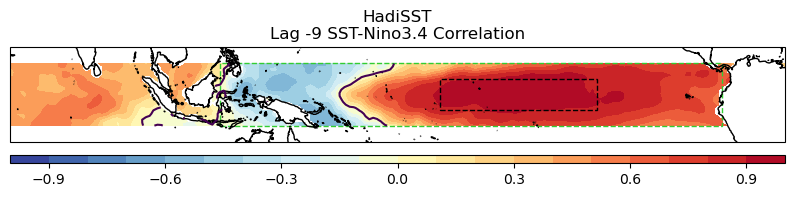

In [13]:
## Get observed SSTs

obsName = 'HadISST'
obs_file = "/glade/work/rneale/data/HADLEY/sst.hadley.187001-200512.nc"
obsDS    = xr.open_dataset(obs_file)

# Make times a more useful format
obsTimes = [ datetime.datetime.strptime(np.asarray(obsDS.time.values).astype('str')[x], '%Y%m') for x in range(len(obsDS.time.values)) ]
obsDS['time'] = obsTimes

# # Select lower latitudes 
# ilatsObs = np.where((obsDS.lat.values>=lat_s) & (obsDS.lat.values<=lat_n))[0]
# obsDS = obsDS.isel(lat=ilatsObs)

# Select years 1965-2002 
iselYears = np.where((obsDS['time.year'].values>=1965) & (obsDS['time.year'].values<=2002))[0]
obsDS = obsDS.isel(time=iselYears)

# Convert longitudes to be 0-360  
lon2   = np.mod((obsDS.lon.values), 360.0)
flipPoint = int(np.where( (lon2>=0) & (lon2<1) )[0])
obsDS['lon'] = lon2
obsDS        = obsDS.roll(lon=flipPoint, roll_coords=True) #Handle needing to shift longitudes to start at 0

## Regrid to match CAM grid exactly 
# Get model grid 
camGrid = DS['TS'].isel(time=0).load().squeeze()
regridObs = regrid_data(obsDS, camGrid, method=1)


# Select lower latitudes 
ilatsObs = np.where((regridObs.lat.values>=lat_s) & (regridObs.lat.values<=lat_n))[0]
obsDS = regridObs.isel(lat=ilatsObs)

## Detrend for observations too
##   This is a little wonky because signal.detrend can't handle NaNs so replacing with a marker that we mask later
sst_obs = np.copy(obsDS.SST.values)

sst_obsFill = sst_obs
sst_obsFill[(np.isnan(sst_obsFill))] = -99

sst_obsFill_detrend = signal.detrend(sst_obsFill, axis=0, type='linear')

sst_obs_detrend = np.copy(obsDS.SST.values)
sst_obs_detrend[np.isfinite(sst_obs_detrend)] = sst_obsFill_detrend[np.isfinite(sst_obs_detrend)]

sst_obs = xr.DataArray(sst_obs_detrend, 
    coords={
            'time': obsDS.time.values,
            'lat': obsDS.lat.values, 
            'lon':obsDS.lon.values}, 
    dims=["time", "lat", "lon"])


## Plot observations too
sstObs_anom = rmMonAnnCyc(sst_obs)

## - - - - - - - - - - - -
## Do the same for obs
ilatsObs = np.where((sstObs_anom.lat.values>=lat_s34)  & (sstObs_anom.lat.values<=lat_n34))[0]
ilonsObs = np.where((sstObs_anom.lon.values>=lon_e34)  & (sstObs_anom.lon.values<=lon_w34))[0]

# Compute weights and get Nino3.4 
regionTSobs = sstObs_anom.isel(lat=ilatsObs, lon=ilonsObs)
coswgt_obs  = np.cos(np.deg2rad(regionTSobs.lat))

nino34_obs = regionTSobs.weighted(coswgt_obs).mean(('lon','lat'))


cor_obs = getLagCorr_obs(0)
# cor_obs = getLagCorr_obs(-9)


## Make plot 
fig,axs = plt.subplots(1,1, figsize=(10,11), subplot_kw={"projection":ccrs.PlateCarree(central_longitude=210)})
pltLims = np.arange(-1,1.1,0.1)

# Contour 
c1 = axs.contourf(sstObs_anom.lon.values,sstObs_anom.lat.values ,  cor_obs, pltLims,
                   cmap='RdYlBu_r', transform=ccrs.PlateCarree() ) 
c2 = axs.contour(sstObs_anom.lon.values,sstObs_anom.lat.values ,  cor_obs, [0], transform=ccrs.PlateCarree())

# Add colorbar 
cax = axs.inset_axes([0, -0.23, 1, 0.09])  # THE NEW AXES, x, y, width, height,
cbar = fig.colorbar(c1, cax = cax, orientation="horizontal")

axs.coastlines()     
axs.add_patch(patches.Rectangle(xy=[lon_e34, lat_s34], width=(lon_w34-lon_e34), height=(lat_n34-lat_s34),
                            facecolor='none', edgecolor='k',linestyle='--',
                            linewidth=1, transform=ccrs.PlateCarree()))

axs.add_patch(patches.Rectangle(xy=[120, -10], width=(280-120), height=20,
                            facecolor='none', edgecolor='limegreen',linestyle='--',
                            linewidth=1, transform=ccrs.PlateCarree()))


axs.set_extent([53,300,-15,15], crs=ccrs.PlateCarree())
axs.set_title('HadiSST\nLag -9 SST-Nino3.4 Correlation')

# axs.plot(157.5, 0.5, 'x', color='limegreen', transform=ccrs.PlateCarree())
# axs.plot(128.5, 0.5, 'x', color='limegreen', transform=ccrs.PlateCarree())

plt.show()
# plt.savefig("Figures/LagCorrelations/HadiSST_1965to2002_LagPos9_sstVSnino34.png", format='png', dpi=300)
plt.close()


### Compute some things in the PI-controls for CESM1 and CESM2 



In [14]:
DS_ocn = xr.open_dataset(listFiles_TS[0]) 


In [15]:
# Updating limit of ocnfrac used to determine mask
ocnMask = DS_ocn.LANDFRAC.isel(time=slice(0, len(DS_cesm1_events.time.values))).values
ocnMask[ocnMask>0.45] = np.nan
ocnMask[ocnMask<=0.45] = 1

# Add the new 'event' dimension using numpy.expand_dims
ocnMask_expanded = np.expand_dims(ocnMask, axis=0)  # Add the new dimension at the front (axis=0)

# Now, tile or repeat the array to match the desired number of events
ocnMask_expanded = np.tile(ocnMask_expanded, (len(DS_cesm1_events.event.values), 1, 1, 1))

# - - - - - - - - - - - - - - - - - - - - - 
## CESM1 
# - - - - - - - - - - - - - - - - - - - - - 
# Detrend data 
ts_cesm1 = signal.detrend(DS_cesm1_events, axis=1, type='linear')
# Get SST 
sst_cesm1 = ts_cesm1 * ocnMask_expanded

sst_cesm1 = xr.DataArray(sst_cesm1, 
    coords={
            'event': DS_cesm1_events.event.values,
            'time': DS_cesm1_events.time.values,
            'lat':  DS_cesm1_events.lat.values, 
            'lon':  DS_cesm1_events.lon.values}, 
    dims=["event", "time", "lat", "lon"])

# Remove annual cycle from monthly data 
sst_anom_cesm1 = rmMonAnnCyc(sst_cesm1)

## Compute nino 3.4 index
ilats = np.where((sst_anom_cesm1.lat.values>=lat_s34)  & (sst_anom_cesm1.lat.values<=lat_n34))[0]
ilons = np.where((sst_anom_cesm1.lon.values>=lon_e34)  & (sst_anom_cesm1.lon.values<=lon_w34))[0]

# Compute weights and get Nino3.4 
regionTS_cesm1 = sst_anom_cesm1.isel(lat=ilats, lon=ilons)
coswgt_cesm1   = np.cos(np.deg2rad(regionTS_cesm1.lat))

nino34_cesm1   = regionTS_cesm1.weighted(coswgt_cesm1).mean(('lon','lat'))

## COMPUE CORRELATION 
cor_case_cesm1 = getLagCorr(0, nino34_cesm1, sst_anom_cesm1)

print('Done with CESM1 calculations')

# - - - - - - - - - - - - - - - - - - - - - 
## CESM2 
# - - - - - - - - - - - - - - - - - - - - - 
# Detrend data 
ts_cesm2 = signal.detrend(DS_cesm2_events, axis=1, type='linear')
# Get SST 
sst_cesm2 = ts_cesm2 * ocnMask_expanded

sst_cesm2 = xr.DataArray(sst_cesm2, 
    coords={
            'event': DS_cesm2_events.event.values,
            'time': DS_cesm2_events.time.values,
            'lat':  DS_cesm2_events.lat.values, 
            'lon':  DS_cesm2_events.lon.values}, 
    dims=["event", "time", "lat", "lon"])

# Remove annual cycle from monthly data 
sst_anom_cesm2 = rmMonAnnCyc(sst_cesm2)

## Compute nino 3.4 index
ilats = np.where((sst_anom_cesm2.lat.values>=lat_s34)  & (sst_anom_cesm2.lat.values<=lat_n34))[0]
ilons = np.where((sst_anom_cesm2.lon.values>=lon_e34)  & (sst_anom_cesm2.lon.values<=lon_w34))[0]

# Compute weights and get Nino3.4 
regionTS_cesm2 = sst_anom_cesm2.isel(lat=ilats, lon=ilons)
coswgt_cesm2   = np.cos(np.deg2rad(regionTS_cesm2.lat))

nino34_cesm2   = regionTS_cesm2.weighted(coswgt_cesm2).mean(('lon','lat'))

## COMPUE CORRELATION 
cor_case_cesm2 = getLagCorr(0, nino34_cesm2, sst_anom_cesm2)

print('Done with CESM2 calculations')



Done with CESM1 calculations
Done with CESM2 calculations


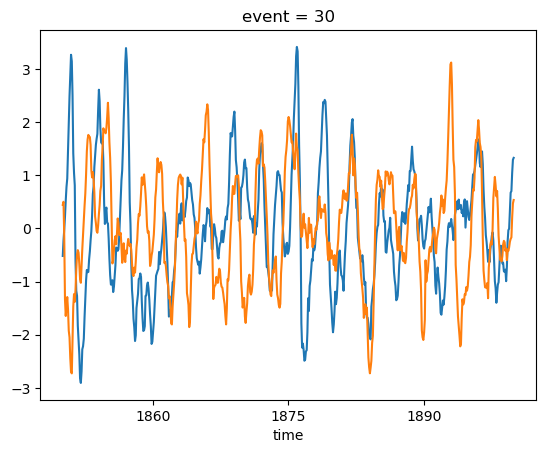

In [17]:
nino34_cesm2.isel(event=0).plot()
nino34_cesm2.isel(event=30).plot()

### Make some plots


In [182]:

# # Plot obs value 
# cor_obs_sel = cor_obs.sel(lon=slice(135,300))
# # cor_obs_sel = cor_obs_sel.sel(lat=slice(-5,5))
# contours = find_contours(cor_obs_sel.values, level=0)

# western_most_point_case = None
# inflection_lon = np.inf

# for contour in contours:
#     for ipoint in range(len(contour)):
#         lat_index, lon_index = contour[ipoint]
#         lon = cor_obs_sel['lon'].values[int(lon_index)]
#         lat = cor_obs_sel['lat'].values[int(lat_index)]
#         # print(lat,lon)

#         if lon<inflection_lon:
#             inflection_lon = lon
#         elif lon>inflection_lon:
#             lat_index, lon_index = contour[ipoint-1]
#             lon = cor_obs_sel['lon'].values[int(lon_index)]
#             western_most_point_case = (cor_obs_sel['lat'].values[int(lat_index)], lon)
#             break 
# print(f"Western-most point in case: {western_most_point_case}")


Western-most point in case: (0.5, 157.5)


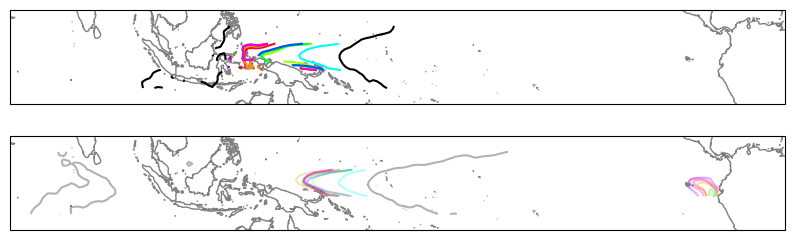

In [16]:
fig,axs = plt.subplots(2,1,figsize=(10,3),subplot_kw={"projection":ccrs.PlateCarree(central_longitude=210)})
axs = axs.ravel()

## Plot zero contours
axs[0].coastlines(color='grey')
axs[0].set_extent([53,300,-15,15], crs=ccrs.PlateCarree())
axs[0].contour(sstObs_anom.lon.values,sstObs_anom.lat.values ,  cor_obs, [0], colors='k', transform=ccrs.PlateCarree())

# Choose a colormap (e.g., 'viridis', 'plasma', 'inferno', 'cividis')
cmap = plt.get_cmap('gist_rainbow')
# Number of colors to extract
num_colors = len(corrs.case.values)
# Generate evenly spaced values between 0 and 1
colorList = [cmap(i) for i in np.linspace(0, 1, num_colors)]

# Ensure the colors are tuples of RGBA values
# Each element in colors should be a tuple like (R, G, B, A)
colorList = [tuple(color) for color in colorList]

for iCase in range(len(corrs.case.values)):
    corrsSel = corrs.sel(lon=slice(120,300))
    corrsSel = corrsSel.sel(lat=slice(-5,5))
    c2 = axs[0].contour(corrsSel.lon.values, corrsSel.lat.values, corrsSel.isel(case=iCase), [0], 
                        colors = np.asarray(colorList[iCase:iCase+1]), transform=ccrs.PlateCarree())

## Plot 0.5 contours
axs[1].coastlines(color='grey')
axs[1].set_extent([53,300,-15,15], crs=ccrs.PlateCarree())
axs[1].contour(sstObs_anom.lon.values,sstObs_anom.lat.values ,  cor_obs, [0.5], colors='k', transform=ccrs.PlateCarree(), alpha=0.3)

# Choose a colormap (e.g., 'viridis', 'plasma', 'inferno', 'cividis')
cmap = plt.get_cmap('gist_rainbow')
# Number of colors to extract
num_colors = len(corrs.case.values)
# Generate evenly spaced values between 0 and 1
colorList = [cmap(i) for i in np.linspace(0, 1, num_colors)]

# Ensure the colors are tuples of RGBA values
# Each element in colors should be a tuple like (R, G, B, A)
colorList = [tuple(color) for color in colorList]

for iCase in range(len(corrs.case.values)):
    corrsSel = corrs.sel(lon=slice(120,300))
    corrsSel = corrsSel.sel(lat=slice(-5,5))
    c2 = axs[1].contour(corrsSel.lon.values, corrsSel.lat.values, corrsSel.isel(case=iCase), [0.5], 
                        colors = np.asarray(colorList[iCase:iCase+1]), transform=ccrs.PlateCarree(), alpha=0.3)


5.693692692464166


Text(0.5, 1.0, 'Westernmost point of 0.5 contour related to Nino 3.4 max')

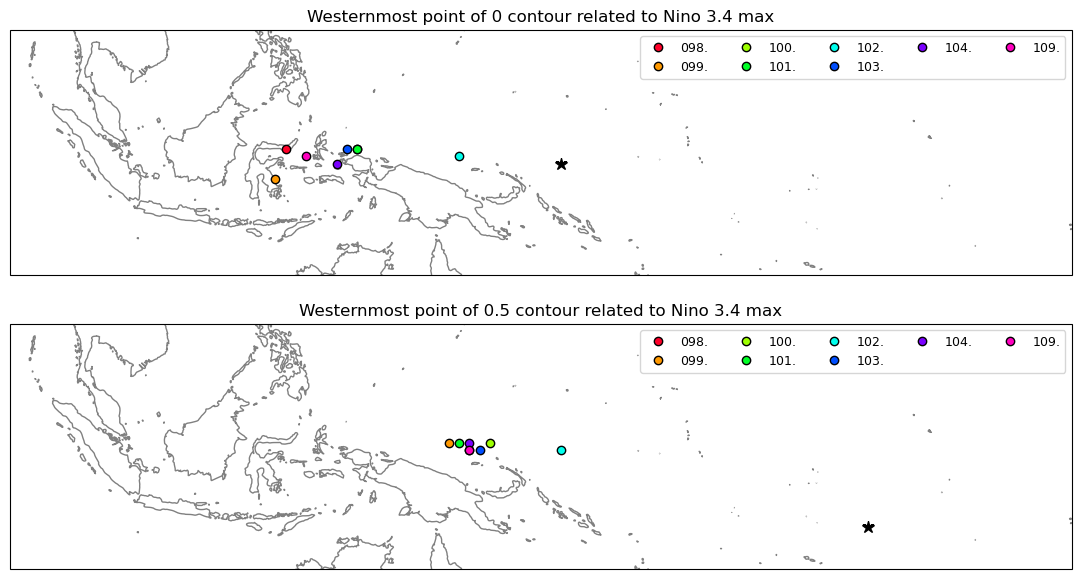

In [29]:
## Figure out western-most longitude of zero contour in pacific 
fig,axs = plt.subplots(2,1,figsize=(20,7),subplot_kw={"projection":ccrs.PlateCarree(central_longitude=210)})
axs     = axs.ravel()


## - - - - - - - - - - - - -
## Plot zero contours
## - - - - - - - - - - - - -
axs[0].coastlines(color='grey')
axs[0].set_extent([90,220,-15,15], crs=ccrs.PlateCarree())
lons_zeroContour = np.full([len(corrs.case.values)], np.nan)
lons_zeroContour_cesm1 = np.full([len(cor_case_cesm1.event.values)], np.nan)
lons_zeroContour_cesm2 = np.full([len(cor_case_cesm2.event.values)], np.nan)

# Plot obs value 
cor_obs_sel = cor_obs.sel(lon=slice(136,300))
# cor_obs_sel = cor_obs_sel.sel(lat=slice(-5,5))
contours = find_contours(cor_obs_sel.values, level=0)

western_most_point_case = None
inflection_lon = np.inf

for contour in contours:
    for ipoint in range(len(contour)):
        lat_index, lon_index = contour[ipoint]
        lon = cor_obs_sel['lon'].values[int(lon_index)]
        lat = cor_obs_sel['lat'].values[int(lat_index)]
        # print(lat,lon)

        if lon<inflection_lon:
            inflection_lon = lon
        elif lon>inflection_lon:
            lat_index, lon_index = contour[ipoint-1]
            lon = cor_obs_sel['lon'].values[int(lon_index)]
            western_most_point_case = (cor_obs_sel['lat'].values[int(lat_index)], lon)
            break 
                
axs[0].plot(lon, cor_obs_sel['lat'].values[int(lat_index)], '*', color='k',markersize=9, transform=ccrs.PlateCarree())
lonObs_zeroContour = lon
sstAnom_obs_zeroContour = sstObs_anom.sel(lon=lon, lat=cor_obs_sel['lat'].values[int(lat_index)]).mean(dim='time')
sstAnomMax_obs = sstObs_anom.max()
print(sstAnomMax_obs.values)

## Plot case values too 
## - - - - - - - - - - - - -
for iCase in range(len(corrs.case.values)):
    cor_case = corrs.isel(case=iCase)
    corrs_sel = cor_case.sel(lon=slice(120,300))
    corrs_sel = corrs_sel.sel(lat=slice(-5,5))
    contours = find_contours(corrs_sel.values, level=0)
    
    western_most_point_case = None
    inflection_lon = np.inf
    
    for contour in contours:
        for ipoint in range(len(contour)):
            lat_index, lon_index = contour[ipoint]
            lon = corrs_sel['lon'].values[int(lon_index)]
            lat = corrs_sel['lat'].values[int(lat_index)]
            # print(lat,lon)
    
            if lon<inflection_lon:
                inflection_lon = lon
            elif lon>inflection_lon:
                lat_index, lon_index = contour[ipoint-1]
                lon = corrs_sel['lon'].values[int(lon_index)]
                western_most_point_case = (corrs_sel['lat'].values[int(lat_index)], lon)
                break 
                    
    # print(f"Western-most point in case: {western_most_point_case}")
    axs[0].plot(lon, corrs_sel['lat'].values[int(lat_index)], 'o', alpha=1, markeredgecolor='k',
                color=np.asarray(colorList[iCase]), transform=ccrs.PlateCarree(), label=cor_case.case.values)
    # axs[0].text(lon, corrs_sel['lat'].values[int(lat_index)], corrs.isel(case=iCase).case.values, color=np.asarray(colorList[iCase]),
    #             transform=ccrs.PlateCarree())
    
    lons_zeroContour[iCase] = lon


# ## Plot case values from PI  ens 
# ## - - - - - - - - - - - - -
# for iCase in range(len(cor_case_cesm2.event.values)):
#     ## CESM1
#     cor_cesm1 = cor_case_cesm1.isel(event=iCase)
#     corrs_sel = cor_cesm1.sel(lon=slice(120,300))
#     corrs_sel = corrs_sel.sel(lat=slice(-5,5))
#     contours = find_contours(corrs_sel.values, level=0)
    
#     western_most_point_case = None
#     inflection_lon = np.inf
    
#     for contour in contours:
#         for ipoint in range(len(contour)):
#             lat_index, lon_index = contour[ipoint]
#             lon = corrs_sel['lon'].values[int(lon_index)]
#             lat = corrs_sel['lat'].values[int(lat_index)]
#             # print(lat,lon)
    
#             if lon<inflection_lon:
#                 inflection_lon = lon
#             elif lon>inflection_lon:
#                 lat_index, lon_index = contour[ipoint-1]
#                 lon = corrs_sel['lon'].values[int(lon_index)]
#                 western_most_point_case = (corrs_sel['lat'].values[int(lat_index)], lon)
#                 break 
                    
#     # print(f"Western-most point in case: {western_most_point_case}")
#     axs[0].plot(lon, corrs_sel['lat'].values[int(lat_index)], 'o', alpha=0.4, markeredgecolor='k',
#                 color='mediumpurple', transform=ccrs.PlateCarree())
#     # axs[0].text(lon, corrs_sel['lat'].values[int(lat_index)], corrs.isel(case=iCase).case.values, color=np.asarray(colorList[iCase]),
#     #             transform=ccrs.PlateCarree())
    
#     lons_zeroContour_cesm1[iCase] = lon


#     ## CESM2
#     cor_cesm2 = cor_case_cesm2.isel(event=iCase)
#     corrs_sel = cor_cesm2.sel(lon=slice(120,300))
#     corrs_sel = corrs_sel.sel(lat=slice(-5,5))
#     contours = find_contours(corrs_sel.values, level=0)
    
#     western_most_point_case = None
#     inflection_lon = np.inf
    
#     for contour in contours:
#         for ipoint in range(len(contour)):
#             lat_index, lon_index = contour[ipoint]
#             lon = corrs_sel['lon'].values[int(lon_index)]
#             lat = corrs_sel['lat'].values[int(lat_index)]
#             # print(lat,lon)
    
#             if lon<inflection_lon:
#                 inflection_lon = lon
#             elif lon>inflection_lon:
#                 lat_index, lon_index = contour[ipoint-1]
#                 lon = corrs_sel['lon'].values[int(lon_index)]
#                 western_most_point_case = (corrs_sel['lat'].values[int(lat_index)], lon)
#                 break 
                    
#     # print(f"Western-most point in case: {western_most_point_case}")
#     axs[0].plot(lon, corrs_sel['lat'].values[int(lat_index)], 'o', alpha=0.4, markeredgecolor='k',
#                 color='dimgrey', transform=ccrs.PlateCarree())
#     # axs[0].text(lon, corrs_sel['lat'].values[int(lat_index)], corrs.isel(case=iCase).case.values, color=np.asarray(colorList[iCase]),
#     #             transform=ccrs.PlateCarree())
    
#     lons_zeroContour_cesm2[iCase] = lon

# axs[0].plot(np.nanmean(lons_zeroContour_cesm1), cor_obs_sel['lat'].values[int(lat_index)], 's', color='mediumpurple', markersize=9, transform=ccrs.PlateCarree())
# axs[0].plot(np.nanmean(lons_zeroContour_cesm2), cor_obs_sel['lat'].values[int(lat_index)], 's', color='dimgrey', markersize=9, transform=ccrs.PlateCarree())

axs[0].set_title('Westernmost point of 0 contour related to Nino 3.4 max')
axs[0].legend(ncol=5,fontsize=9)

## - - - - - - - - - - - - -
## Plot 0.5 contours
## - - - - - - - - - - - - -
axs[1].coastlines(color='grey')
axs[1].set_extent([90,220,-15,15], crs=ccrs.PlateCarree())
lons_0p5Contour = np.full([len(corrs.case.values)], np.nan)
lons_0p5Contour_cesm1 = np.full([len(cor_case_cesm1.event.values)], np.nan)
lons_0p5Contour_cesm2 = np.full([len(cor_case_cesm2.event.values)], np.nan)

# Plot obs value 
cor_obs_sel = cor_obs.sel(lon=slice(136,220))
# cor_obs_sel = cor_obs_sel.sel(lat=slice(-5,5))
contours = find_contours(cor_obs_sel.values, level=0.5)

western_most_point_case = None
inflection_lon = np.inf

for contour in contours:
    for ipoint in range(len(contour)):
        lat_index, lon_index = contour[ipoint]
        lon = cor_obs_sel['lon'].values[int(lon_index)]
        lat = cor_obs_sel['lat'].values[int(lat_index)]
        # print(lat,lon)

        if lon<inflection_lon:
            inflection_lon = lon
        elif lon>inflection_lon:
            lat_index, lon_index = contour[ipoint-1]
            lon = cor_obs_sel['lon'].values[int(lon_index)]
            western_most_point_case = (cor_obs_sel['lat'].values[int(lat_index)], lon)
            break 

axs[1].plot(lon, cor_obs_sel['lat'].values[int(lat_index)], '*', color='k',markersize=9, transform=ccrs.PlateCarree())
lonObs_0p5Contour = lon

## Plot case values too 
## - - - - - - - - - - - - -
for iCase in range(len(corrs.case.values)):
    cor_case = corrs.isel(case=iCase)
    corrs_sel = cor_case.sel(lon=slice(120,250))
    corrs_sel = corrs_sel.sel(lat=slice(-5,5))
    contours = find_contours(corrs_sel.values, level=0.5)
    
    western_most_point_case = None
    inflection_lon = np.inf
    
    for contour in contours:
        for ipoint in range(len(contour)):
            lat_index, lon_index = contour[ipoint]
            lon = corrs_sel['lon'].values[int(lon_index)]
            lat = corrs_sel['lat'].values[int(lat_index)]
            # print(lat,lon)
    
            if lon<inflection_lon:
                inflection_lon = lon
            elif lon>inflection_lon:
                lat_index, lon_index = contour[ipoint-1]
                lon = corrs_sel['lon'].values[int(lon_index)]
                western_most_point_case = (corrs_sel['lat'].values[int(lat_index)], lon)
                break 
                    
    # print(f"Western-most point in case: {western_most_point_case}")
    axs[1].plot(lon, corrs_sel['lat'].values[int(lat_index)], 'o', alpha=1, markeredgecolor='k',
                color=np.asarray(colorList[iCase]), transform=ccrs.PlateCarree(), label=cor_case.case.values)
    lons_0p5Contour[iCase] = lon


# ## Plot PI values 
# ## - - - - - - - - - - - - -
# for iCase in range(len(cor_case_cesm1.event.values)):
#     ## CESM1
#     cor_cesm1 = cor_case_cesm1.isel(event=iCase)
#     corrs_sel = cor_cesm1.sel(lon=slice(120,250))
#     corrs_sel = corrs_sel.sel(lat=slice(-5,5))
#     contours = find_contours(corrs_sel.values, level=0.5)
    
#     western_most_point_case = None
#     inflection_lon = np.inf
    
#     for contour in contours:
#         for ipoint in range(len(contour)):
#             lat_index, lon_index = contour[ipoint]
#             lon = corrs_sel['lon'].values[int(lon_index)]
#             lat = corrs_sel['lat'].values[int(lat_index)]
#             # print(lat,lon)
    
#             if lon<inflection_lon:
#                 inflection_lon = lon
#             elif lon>inflection_lon:
#                 lat_index, lon_index = contour[ipoint-1]
#                 lon = corrs_sel['lon'].values[int(lon_index)]
#                 western_most_point_case = (corrs_sel['lat'].values[int(lat_index)], lon)
#                 break 
                    
#     # print(f"Western-most point in case: {western_most_point_case}")
#     axs[1].plot(lon, corrs_sel['lat'].values[int(lat_index)], 'o', alpha=0.4, markeredgecolor='k',
#                 color='mediumpurple', transform=ccrs.PlateCarree())
#     # axs[0].text(lon, corrs_sel['lat'].values[int(lat_index)], corrs.isel(case=iCase).case.values, color=np.asarray(colorList[iCase]),
#     #             transform=ccrs.PlateCarree())
    
#     lons_0p5Contour_cesm1[iCase] = lon


#     ## CESM2
#     cor_cesm2 = cor_case_cesm2.isel(event=iCase)
#     corrs_sel = cor_cesm2.sel(lon=slice(120,250))
#     corrs_sel = corrs_sel.sel(lat=slice(-5,5))
#     contours = find_contours(corrs_sel.values, level=0.5)
    
#     western_most_point_case = None
#     inflection_lon = np.inf
    
#     for contour in contours:
#         for ipoint in range(len(contour)):
#             lat_index, lon_index = contour[ipoint]
#             lon = corrs_sel['lon'].values[int(lon_index)]
#             lat = corrs_sel['lat'].values[int(lat_index)]
#             # print(lat,lon)
    
#             if lon<inflection_lon:
#                 inflection_lon = lon
#             elif lon>inflection_lon:
#                 lat_index, lon_index = contour[ipoint-1]
#                 lon = corrs_sel['lon'].values[int(lon_index)]
#                 western_most_point_case = (corrs_sel['lat'].values[int(lat_index)], lon)
#                 break 
                    
#     # print(f"Western-most point in case: {western_most_point_case}")
#     axs[1].plot(lon, corrs_sel['lat'].values[int(lat_index)], 'o', alpha=0.4, markeredgecolor='k',
#                 color='dimgrey', transform=ccrs.PlateCarree())
#     # axs[0].text(lon, corrs_sel['lat'].values[int(lat_index)], corrs.isel(case=iCase).case.values, color=np.asarray(colorList[iCase]),
#     #             transform=ccrs.PlateCarree())
    
#     lons_0p5Contour_cesm2[iCase] = lon

axs[1].legend(ncol=5, fontsize=9)
axs[1].set_title('Westernmost point of 0.5 contour related to Nino 3.4 max')


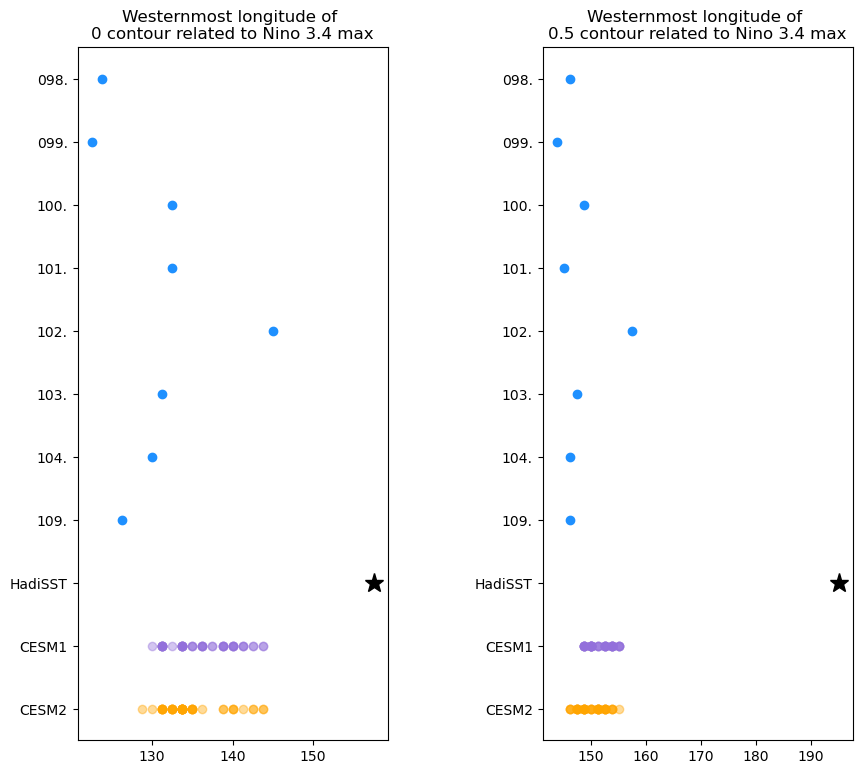

In [18]:
fig,axs=plt.subplots(1,2,figsize=(10,9))
axs = axs.ravel()

axs[0].scatter(lons_zeroContour, corrs.case.values, color='dodgerblue', alpha=1)
# axs[0].axhline(lonObs_zeroContour,color='k',linestyle='--')
axs[0].plot(lonObs_zeroContour, 'HadiSST', '*', color='k',markersize=14)
axs[0].set_title('Westernmost longitude of \n0 contour related to Nino 3.4 max')
axs[0].invert_yaxis()
axs[0].plot(lons_zeroContour_cesm1, np.full([len(cor_case_cesm1.event.values)], 'CESM1'), 'o', color='mediumpurple', alpha=0.4)
axs[0].plot(lons_zeroContour_cesm2, np.full([len(cor_case_cesm2.event.values)], 'CESM2'), 'o', color='orange', alpha=0.4)

axs[1].scatter(lons_0p5Contour, corrs.case.values, color='dodgerblue', alpha=1)
# axs[1].axhline(lonObs_0p5Contour,color='k', linestyle='--')
axs[1].plot(lonObs_0p5Contour, 'HadiSST', '*', color='k',markersize=14)
axs[1].set_title('Westernmost longitude of \n0.5 contour related to Nino 3.4 max')
axs[1].invert_yaxis()
axs[1].plot(lons_0p5Contour_cesm1, np.full([len(cor_case_cesm1.event.values)], 'CESM1'), 'o', color='mediumpurple', alpha=0.4)
axs[1].plot(lons_0p5Contour_cesm2, np.full([len(cor_case_cesm2.event.values)], 'CESM2'), 'o', color='orange', alpha=0.4)


# ## Mark lineage of some runs
# i78b = (np.where(corrs['case'].values=='078b')[0]).astype(int)[0]
# i3x = (np.where(corrs['case'].values=='081b')[0]).astype(int)[0]
# i1x = (np.where(corrs['case'].values=='082b')[0]).astype(int)[0]
# i0x = (np.where(corrs['case'].values=='083b')[0]).astype(int)[0]

# axs[1].plot( [lons_0p5Contour[i78b],lons_0p5Contour[i3x]], [corrs['case'].values[i78b], corrs['case'].values[i3x]],
#          '-',color='purple')
# axs[1].plot( [lons_0p5Contour[i78b],lons_0p5Contour[i1x]], [corrs['case'].values[i78b], corrs['case'].values[i1x]],
#          '-',color='mediumpurple')
# axs[1].plot([lons_0p5Contour[i78b],lons_0p5Contour[i0x]], [corrs['case'].values[i78b], corrs['case'].values[i0x]], 
#          '-',color='violet')

# for specCase in range(len(lons_0p5Contour)): 
#     ## Mark Taus Code
#     if ((corrs['case'].values[specCase]=='044.') | (corrs['case'].values[specCase]=='076.') | (corrs['case'].values[specCase]=='080.') ):
#         axs[1].plot(lons_0p5Contour[specCase], corrs['case'].values[specCase], 's', color='limegreen',alpha=0.6,markersize=15, label=None)
#     ## Mark warm and cold branch starts 
#     if (corrs['case'].values[specCase]=='074.'):
#         axs[1].plot(lons_0p5Contour[specCase], corrs['case'].values[specCase], 'o', color='red',alpha=0.4,markersize=15, label=None)
#     if (corrs['case'].values[specCase]=='073.'):
#         axs[1].plot( lons_0p5Contour[specCase], corrs['case'].values[specCase], 'o', color='cyan',alpha=0.4,markersize=15, label=None)



fig.subplots_adjust(wspace=0.5)

In [53]:
len(lons_zeroContour)

32

In [31]:
for iCase in range(len(corrs.case.values)):
    print(df['Case Name'][4+iCase], corrs.case.values[iCase])

38 038.
42 042.
44 044.
46 046.
47 047.
48 048.
54 054.
54 055.
55 058.
58 061.
61 063.
63 064.
64 064b
064b 064c
064c 067.
70 070.
72 072.
73 073.
073b 073b
74 074.
75 075.
075c 075c
76 076.
78 078.
078b 078b
79 079.
80 080.
081b 081b
082b 082b
083b 083b
084b 084b
98 098.
104 104.


In [32]:
df_sel = df.drop([0,1,2,3,10])

iKeep_corrs = np.where(corrs.case.values!='067.')[0]

lons_zeroContour_match = lons_zeroContour[iKeep_corrs]
corrs_case_match = corrs.case.values[iKeep_corrs]

lons_0p5Contour_match = lons_0p5Contour[iKeep_corrs]

In [122]:
df

Case Name Years analyzed            Nyrs available history  \
0    HadiSST      1965-2002                               NaN   
1    HadiSST      1942-1981                               NaN   
2      CESM2      0001-0151                               NaN   
3      CESM1      0001-1000                               NaN   
4         38      0001-0061             Climo only (yrs 2-22)   
5         42      0001-0048             Climo only (yrs 2-22)   
6         44      0001-0045             Climo only (yrs 2-22)   
7         46      0001-0071             Climo only (yrs 2-22)   
8         47      0001-0071             Climo only (yrs 2-22)   
9         48      0001-0037             Climo only (yrs 2-22)   
10        54      0001-0101                               NaN   
11        54      0075-0103                  1-152 \n(all h*)   
12        55      0001-0101             Climo only (yrs 2-22)   
13        58      0001-0017             Climo only (yrs 2-22)   
14        61      0001-0049             Climo only (yrs 2-21)   
15        63      0001-0025             Climo only (yrs 2-21)   
16        64      0001-0059                   1-59 \n(all h*)   
17      064b      0043-0069                   43-68\n(all h*)   
18      064c      0043-0069                   43-68\n(all h*)   
19        70      0001-0027             Climo only (yrs 2-11)   
20        72      0001-0033             Climo only (yrs 2-21)   
21        73      0001-0019             Climo only (yrs 2-18)   
22      073b      0001-0043     Climo only (yrs 10-30, 40-60)   
23        74      0001-0023             Climo only (yrs 2-18)   
24        75      0001-0043                  1-125 \n(all h*)   
25      075c      0001-0051  1-50 \n(all h*)\nGustavo scratch   
26        76      0001-0042                   1-81 \n(all h*)   
27        78      0001-0049                   1-48 \n(all h*)   
28      078b      0001-0031                   1-95 \n(all h*)   
29        79      0001-0049   1-48 \n(all h*)\nCecile scratch   
30        80      0001-0023       1-22 \n(h0)\nCecile scratch   
31      081b      0001-0035   1-62 \n(all h*)\nCecile scratch   
32      082b      0001-0031   1-63 \n(all h*)\nCecile scratch   
33      083b      0001-0033   1-62 \n(all h*)\nCecile scratch   
34      084b      0001-0035   1-50 \n(all h*)\nCecile scratch   
35        98      0001-0151  1-254 \n(all h*)\nCecile scratch   

   Transition to opposite phase \n(months) Value of max variance  \
0                                      ~11                  1.45   
1                                      ~11                   0.9   
2                                       12                  1.75   
3                                       12                   1.4   
4                                      ~22                   1.5   
5                                      ~18                    >3   
6                                      ~11                   1.9   
7                                      ~15                   2.3   
8                                      ~14                   2.1   
9                                      ~14                    >3   
10                                     ~13                   2.3   
11                                      12                   1.1   
12                                     ~18                   1.6   
13                                     ~13                    >3   
14                                     ~13                   2.5   
15                                     ~13                  1.75   
16                                     ~13                  1.15   
17                                     ~13                   1.7   
18                                     ~11                   1.8   
19                                     ~14                   2.6   
20                                      12                   2.2   
21                                     ~13                   1.5   
22                               

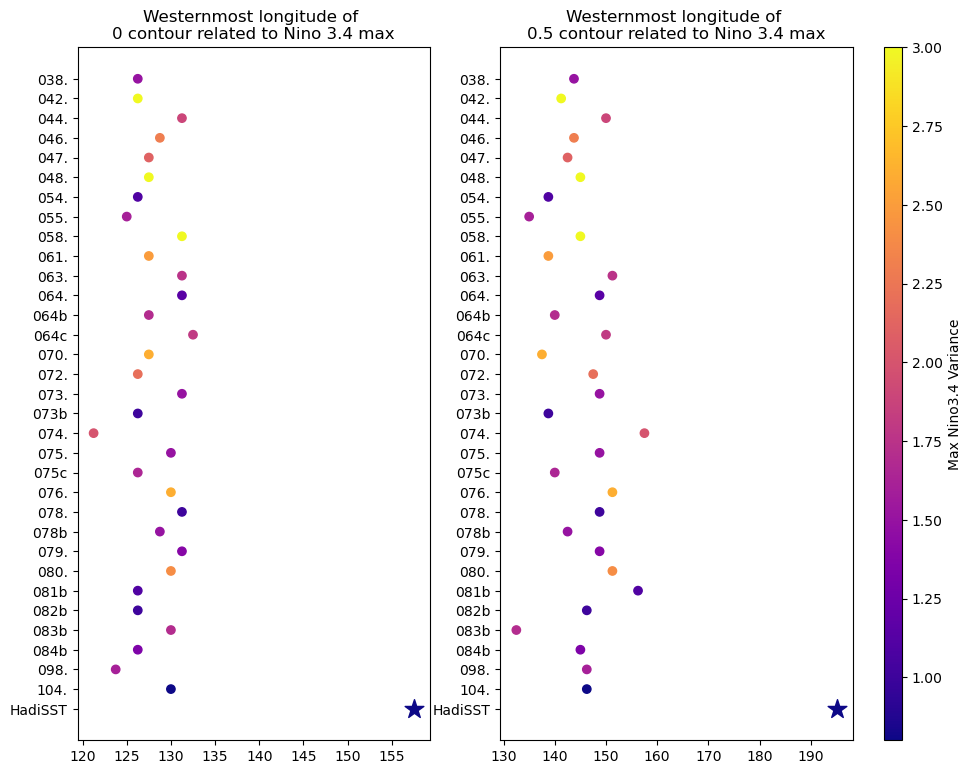

In [33]:
fig,axs=plt.subplots(1,2,figsize=(10,9))
axs = axs.ravel()

valArray = df_sel['Value of max variance'].copy()
valArray[valArray=='>3'] = '3'

axs[0].scatter(lons_zeroContour_match, corrs_case_match, c=valArray.values.astype(float) , cmap='plasma')
axs[0].scatter(lonObs_zeroContour, 'HadiSST', c=float(df['Value of max variance'].values[0]),cmap='plasma',marker='*', s=200)
axs[0].set_title('Westernmost longitude of \n0 contour related to Nino 3.4 max')
axs[0].invert_yaxis()

c1 = axs[1].scatter(lons_0p5Contour_match, corrs_case_match, c=valArray.values.astype(float), cmap='plasma')
axs[1].scatter(lonObs_0p5Contour, 'HadiSST', c=float(df['Value of max variance'].values[0]),cmap='plasma',marker='*', s=200)
axs[1].set_title('Westernmost longitude of \n0.5 contour related to Nino 3.4 max')
axs[1].invert_yaxis()

# Add colorbar 
# cbar = fig.colorbar(c1,  orientation="vertical", shrink=0.4, label='Max Variance')
cax = axs[1].inset_axes([1.09, 0, 0.05, 1])  # THE NEW AXES, x, y, width, height,
cbar = fig.colorbar(c1, cax = cax, label='Max Nino3.4 Variance', orientation="vertical")

fig.subplots_adjust(hspace=0.4)

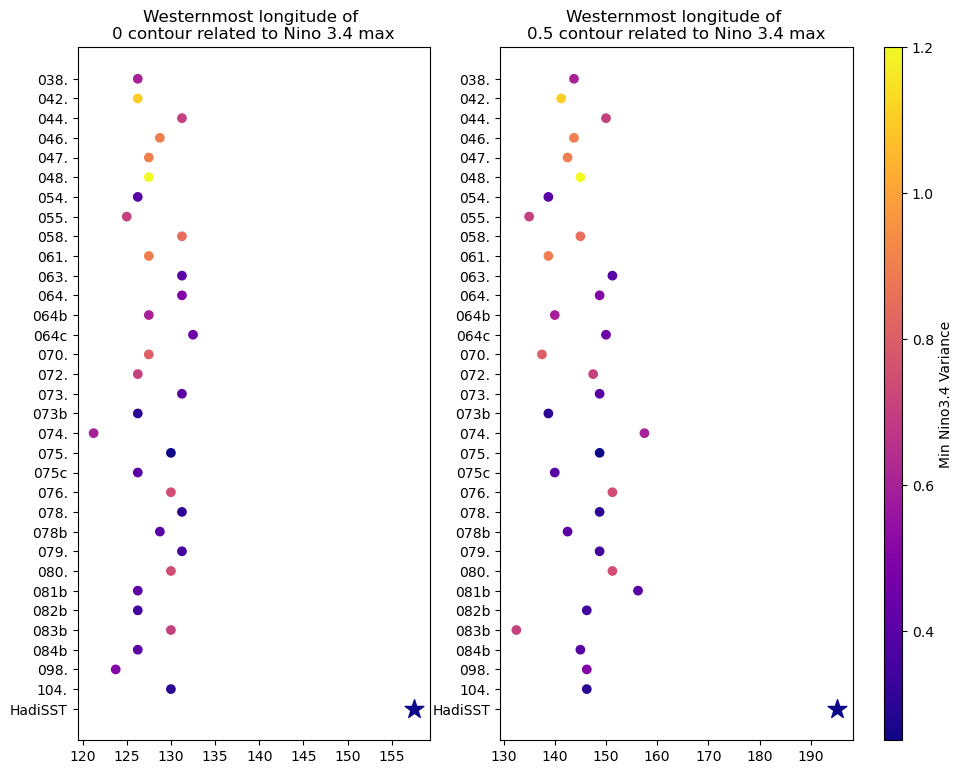

In [34]:
fig,axs=plt.subplots(1,2,figsize=(10,9))
axs = axs.ravel()

valArray = df_sel['Value of min variance'].copy()
# valArray[valArray=='>3'] = '3'

axs[0].scatter(lons_zeroContour_match, corrs_case_match, c=valArray.values.astype(float) , cmap='plasma')
axs[0].scatter(lonObs_zeroContour, 'HadiSST', c=float(df['Value of max variance'].values[0]),cmap='plasma',marker='*', s=200)
axs[0].set_title('Westernmost longitude of \n0 contour related to Nino 3.4 max')
axs[0].invert_yaxis()

c1 = axs[1].scatter(lons_0p5Contour_match, corrs_case_match, c=valArray.values.astype(float), cmap='plasma')
axs[1].scatter(lonObs_0p5Contour, 'HadiSST', c=float(df['Value of max variance'].values[0]),cmap='plasma',marker='*', s=200)
axs[1].set_title('Westernmost longitude of \n0.5 contour related to Nino 3.4 max')
axs[1].invert_yaxis()

# Add colorbar 
# cbar = fig.colorbar(c1,  orientation="vertical", shrink=0.4, label='Max Variance')
cax = axs[1].inset_axes([1.09, 0, 0.05, 1])  # THE NEW AXES, x, y, width, height,
cbar = fig.colorbar(c1, cax = cax, label='Min Nino3.4 Variance', orientation="vertical")

fig.subplots_adjust(hspace=0.4)

**Look at some averages for west pacific...**

In [59]:
corrs_westPac = corrs.sel(lon=slice(120,280))
corrs_westPac = corrs_westPac.sel(lat=slice(-10, 10))

cor_obs_westPac = cor_obs.sel(lon=slice(120,280))

corrs_westPac_cesm1 = cor_case_cesm1.sel(lon=slice(120,280))
corrs_westPac_cesm1 = corrs_westPac_cesm1.sel(lat=slice(-10, 10))

corrs_westPac_cesm2 = cor_case_cesm2.sel(lon=slice(120,280))
corrs_westPac_cesm2 = corrs_westPac_cesm2.sel(lat=slice(-10, 10))


In [60]:
reshape_data = np.full([len(corrs_westPac.case.values), len(corrs_westPac.lon.values)*len(corrs_westPac.lat.values)], np.nan)

for iCase in range(len(corrs_westPac.case.values)):
    reshape_data[iCase,:] = np.reshape(corrs_westPac.isel(case=iCase).values, [1, len(corrs_westPac.lon.values)*len(corrs_westPac.lat.values)])

# Create the DataArray
da = xr.DataArray(reshape_data, coords=[corrs_westPac.case.values, np.arange(len(corrs_westPac.lon.values)*len(corrs_westPac.lat.values))], dims=["case", "Location"])

# Convert the DataArray to a Pandas DataFrame
df = da.to_dataframe(name="Correlation").reset_index()

## Handle observations too
reshape_obs = np.reshape(cor_obs_westPac, [1, len(cor_obs_westPac.lon.values)*len(cor_obs_westPac.lat.values)])
da_obs =  xr.DataArray(reshape_obs, coords=[["HadiSST"], np.arange(len(cor_obs_westPac.lon.values)*len(cor_obs_westPac.lat.values))], dims=["case", "Location"])
df_obs = da_obs.to_dataframe(name="Correlation").reset_index()

df_all = pd.concat([df, df_obs], ignore_index=True)

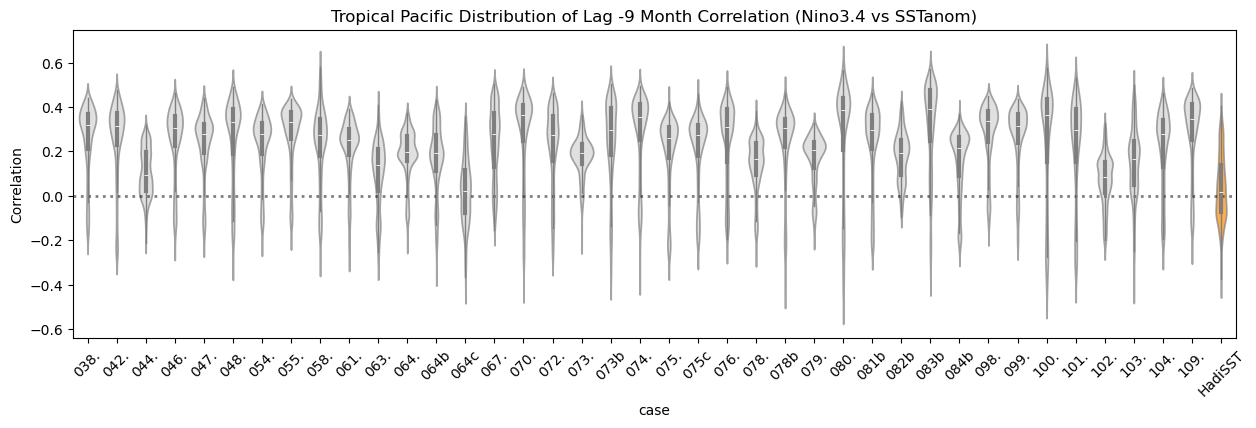

In [62]:
fig,axs = plt.subplots(1,1,figsize=(15,4))
axs.axhline(0,color='k',linewidth=2,alpha=0.5,linestyle=':')

v1 = sns.violinplot(df_all, x='case',y='Correlation', inner='box', color="lightgrey", alpha=0.7, 
                   inner_kws=dict(box_width=3, whis_width=1))

v1.collections[-1].set_facecolor("darkorange")

axs.set_title('Tropical Pacific Distribution of Lag 0 Month Correlation (Nino3.4 vs SSTanom)')

plt.setp( axs.xaxis.get_majorticklabels(), rotation=45 )
plt.show()

# axs.axhline(0,color='k',linewidth=2,alpha=0.5,linestyle=':')

## How possible is it to recreate some of the metrics from ENSO_metrics?
Ref: https://pcmdi.llnl.gov/pmp-preliminary-results/interactive_plot/portrait_plot/enso_metric/enso_metrics_interactive_portrait_plots_v20210723.html 

**ENSO Duration** <br>
https://github.com/CLIVAR-PRP/ENSO_metrics/blob/1dbd59a6264e4e8ee28d26ce5083cdae0faf52a1/lib/EnsoMetricsLib.py#L7170 <br>
*Description:* The EnsoDuration() function computes sea surface temperature anomalies life cycle associated with ENSO in a 'box'
    (usually the nino3.4) with a window of 'nbr_years_window' centered on ENSO (nbr_years_window/2 leading and lagging
    ENSO), the duration is then the period, around the peak, during which the life cycle is above 0.25.

In [19]:
lagSel = -24+np.arange(49)

cor_obs_thisLag_nino   = np.full([len(lagSel)], np.nan)
cor_cases_thisLag_nino = np.full([len(listFiles_TS), len(lagSel)], np.nan)
cor_cesm1_thisLag_nino = np.full([len(cor_case_cesm1.event.values), len(lagSel)], np.nan)
cor_cesm2_thisLag_nino = np.full([len(cor_case_cesm2.event.values), len(lagSel)], np.nan)

for iLag in range(len(lagSel)):
    ## Observations ------
    cor_obs_thisLag = getLagCorr_obs(lagSel[iLag])
    
    # Get average in Nino3.4 region... 
    cor_obs_thisLag_nino[iLag] = cor_obs_thisLag.sel(lon=slice(lon_e34,lon_w34), lat=slice(lat_s34, lat_n34)).mean(['lat','lon'])

## Handle model data ------
for iSim in range(len(listFiles_TS)):
    for iLag in range(len(lagSel)):
        DS = xr.open_dataset(listFiles_TS[iSim]) 
        
        ## Add case ID (short name) to the DS
        x = re.search("BLT1850.ne30_t232.", listFiles_TS[iSim])
        if x:
            caseName = listFiles_TS[iSim][x.span()[-1]:4+x.span()[-1]]
        else: 
            x = re.search("BLTHIST.ne30_t232.", listFiles_TS[iSim])
            caseName = 'HIST_'+listFiles_TS[iSim][x.span()[-1]:4+x.span()[-1]]
        
        ocnMask = DS.LANDFRAC.values
        ocnMask[ocnMask>0.45] = np.nan
        ocnMask[ocnMask<=0.45] = 1
        
        # Detrend data 
        TS = DS.TS 
        ts = signal.detrend(TS, axis=0, type='linear')
        # Get SST 
        sst = ts * ocnMask
        
        sst = xr.DataArray(sst, 
            coords={'time': DS.time.values,
                    'lat':  DS.lat.values, 
                    'lon':  DS.lon.values}, 
            dims=["time", "lat", "lon"])
        
        
        # Remove annual cycle from monthly data 
        sst_anom = rmMonAnnCyc(sst)
        
        ## Compute nino 3.4 index
        ilats = np.where((sst_anom.lat.values>=lat_s34)  & (sst_anom.lat.values<=lat_n34))[0]
        ilons = np.where((sst_anom.lon.values>=lon_e34)  & (sst_anom.lon.values<=lon_w34))[0]
        
        # Compute weights and get Nino3.4 
        regionTS = sst_anom.isel(lat=ilats, lon=ilons)
        coswgt   = np.cos(np.deg2rad(regionTS.lat))
        
        nino34   = regionTS.weighted(coswgt).mean(('lon','lat'))

    
        ## COMPUE CORRELATION 
        cor_case = getLagCorr(lagSel[iLag], nino34, sst_anom)
        cor_cases_thisLag_nino[iSim, iLag] = cor_case.sel(lon=slice(lon_e34,lon_w34), lat=slice(lat_s34, lat_n34)).mean(['lat','lon'])

    print('Done with case %i of %i' % (iSim+1, len(listFiles_TS)))


# Handle CESM1/2 data ------
for iSim in range(len(cor_case_cesm1.event.values)):
    for iLag in range(len(lagSel)):
    
        ## COMPUE CORRELATION 
        cor_cesm1 = getLagCorr(lagSel[iLag], nino34_cesm1.isel(event=iSim), sst_anom_cesm1.isel(event=iSim))
        cor_cesm1_thisLag_nino[iSim, iLag] = cor_cesm1.sel(lon=slice(lon_e34,lon_w34), lat=slice(lat_s34, lat_n34)).mean(['lat','lon'])

        cor_cesm2 = getLagCorr(lagSel[iLag], nino34_cesm2.isel(event=iSim), sst_anom_cesm2.isel(event=iSim))
        cor_cesm2_thisLag_nino[iSim, iLag] = cor_cesm2.sel(lon=slice(lon_e34,lon_w34), lat=slice(lat_s34, lat_n34)).mean(['lat','lon'])

    
    print('Done with CESM1/2 event %i of %i' % (iSim+1, len(nino34_cesm2.event.values)))


Done with case 1 of 8
Done with case 2 of 8
Done with case 3 of 8
Done with case 4 of 8
Done with case 5 of 8
Done with case 6 of 8
Done with case 7 of 8
Done with case 8 of 8
Done with CESM1/2 event 1 of 47
Done with CESM1/2 event 2 of 47
Done with CESM1/2 event 3 of 47
Done with CESM1/2 event 4 of 47
Done with CESM1/2 event 5 of 47
Done with CESM1/2 event 6 of 47
Done with CESM1/2 event 7 of 47
Done with CESM1/2 event 8 of 47
Done with CESM1/2 event 9 of 47
Done with CESM1/2 event 10 of 47
Done with CESM1/2 event 11 of 47
Done with CESM1/2 event 12 of 47
Done with CESM1/2 event 13 of 47
Done with CESM1/2 event 14 of 47
Done with CESM1/2 event 15 of 47
Done with CESM1/2 event 16 of 47
Done with CESM1/2 event 17 of 47
Done with CESM1/2 event 18 of 47
Done with CESM1/2 event 19 of 47
Done with CESM1/2 event 20 of 47
Done with CESM1/2 event 21 of 47
Done with CESM1/2 event 22 of 47
Done with CESM1/2 event 23 of 47
Done with CESM1/2 event 24 of 47
Done with CESM1/2 event 25 of 47
Done wit

In [19]:
# Choose a colormap (e.g., 'viridis', 'plasma', 'inferno', 'cividis')
# cmap = plt.get_cmap('nipy_spectral')
cmap = plt.get_cmap('rainbow')
# Number of colors to extract
num_colors = len(corrs.case.values)
# Generate evenly spaced values between 0 and 1
colorList = [cmap(i) for i in np.linspace(0, 1, num_colors)]

# Ensure the colors are tuples of RGBA values
# Each element in colors should be a tuple like (R, G, B, A)
colorList = [tuple(color) for color in colorList]


In [20]:
# fig,axs = plt.subplots(1,1,figsize=(12,8))

# axs.plot(lagSel, cor_obs_thisLag_nino, 'k', linewidth=4, label='HadiSST')

# for iCase in range(len(nino34_cesm2.event.values)): 
#     axs.plot(lagSel, cor_cesm1_thisLag_nino[iCase,:], color= 'mediumpurple', alpha=0.25,linewidth=0.6 )
#     axs.plot(lagSel, cor_cesm2_thisLag_nino[iCase,:], color= 'orange', alpha=0.25, linewidth=0.6)
# for iCase in range(len(listFiles_TS)): 
#     axs.plot(lagSel, cor_cases_thisLag_nino[iCase,:], color= 'green', alpha=0.25, linewidth=0.6)

# axs.plot(lagSel, np.nanmean(cor_cesm1_thisLag_nino,axis=0), color= 'mediumpurple', label='CESM1 PI mean', linewidth=3 )
# axs.plot(lagSel, np.nanmean(cor_cesm2_thisLag_nino,axis=0), color= 'orange',  label='CESM2 PI mean', linewidth=3)
# axs.plot(lagSel, np.nanmean(cor_cases_thisLag_nino,axis=0), color= 'green',  label='CESM3-dev mean', linewidth=3)

    
# axs.legend(ncol=5)
# axs.axhline(0.25, color='grey',alpha=0.5,linestyle='--')
# axs.axhline(0.0, color='grey',alpha=0.5,linestyle='-')

# axs.set_title('Mean Correlation in Nino3.4 box between Nino3.4 and SST anomalies (all months)')
# axs.set_xlabel('Lag (months)')
# axs.set_ylabel('Mean Correlation')


Text(0, 0.5, 'Mean Correlation')

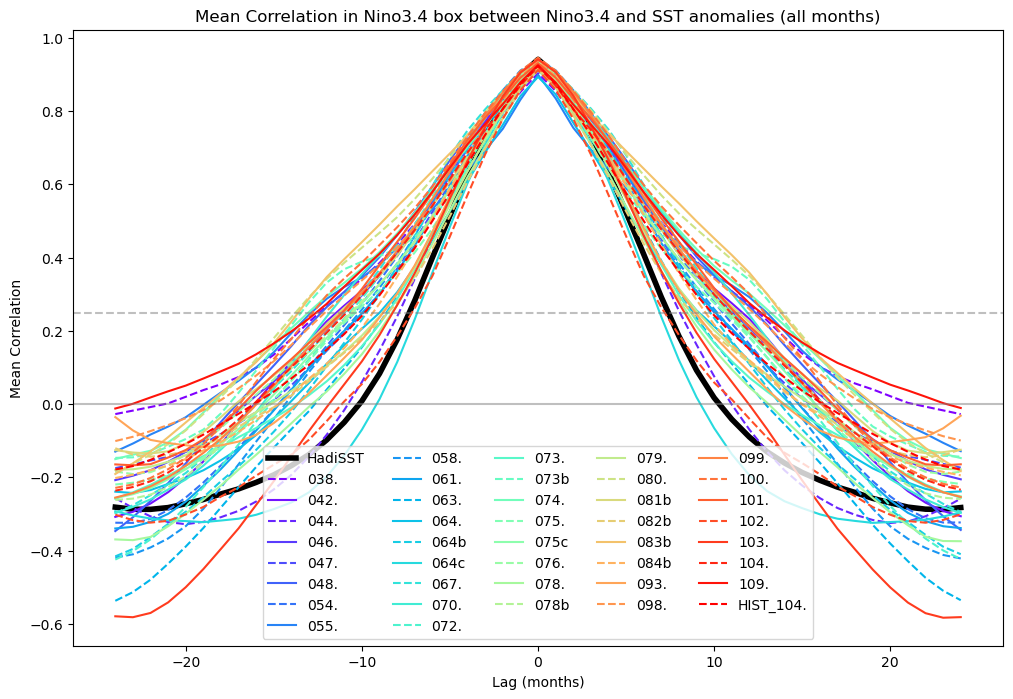

In [21]:
fig,axs = plt.subplots(1,1,figsize=(12,8))

axs.plot(lagSel, cor_obs_thisLag_nino, 'k', linewidth=4, label='HadiSST')

for iCase in range(len(listFiles_TS)): 
    if (iCase % 2)==0: 
        axs.plot(lagSel, cor_cases_thisLag_nino[iCase,:], '--', color= colorList[iCase], label=str(corrs.case.values[iCase]))
    else: 
        axs.plot(lagSel, cor_cases_thisLag_nino[iCase,:], color= colorList[iCase], label=str(corrs.case.values[iCase]))
        
    
axs.legend(ncol=5)
axs.axhline(0.25, color='grey',alpha=0.5,linestyle='--')
axs.axhline(0.0, color='grey',alpha=0.5,linestyle='-')

axs.set_title('Mean Correlation in Nino3.4 box between Nino3.4 and SST anomalies (all months)')
axs.set_xlabel('Lag (months)')
axs.set_ylabel('Mean Correlation')


In [20]:
## Get number of months an ENSO event spends above some threshold value 
lim = 0.25 

numMonthsAboveLimit = np.full([len(listFiles_TS)], np.nan)
for iCase in range(len(listFiles_TS)):
    numMonthsAboveLimit[iCase] = len(np.where(cor_cases_thisLag_nino[iCase,:]>=lim)[0])


numMonthsAboveLimit_cesm1 = np.full([len(nino34_cesm1.event.values)], np.nan)
numMonthsAboveLimit_cesm2 = np.full([len(nino34_cesm2.event.values)], np.nan)
for iCase in range(len(nino34_cesm1.event.values)):
    numMonthsAboveLimit_cesm1[iCase] = len(np.where(cor_cesm1_thisLag_nino[iCase,:]>=lim)[0])
    numMonthsAboveLimit_cesm2[iCase] = len(np.where(cor_cesm2_thisLag_nino[iCase,:]>=lim)[0])

numMonthsAboveLimit_obs = len(np.where(cor_obs_thisLag_nino>=lim)[0])

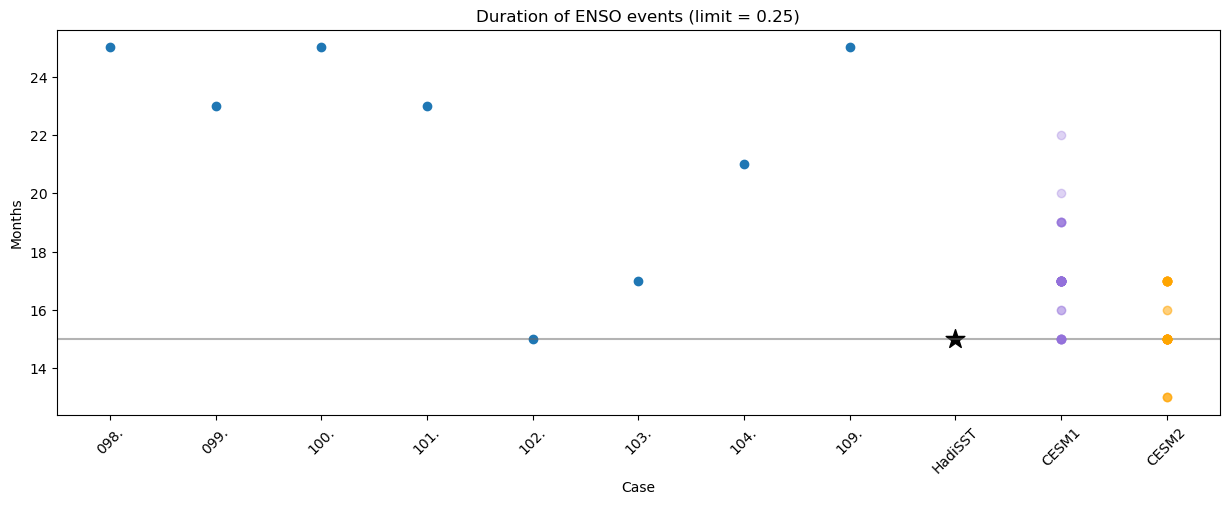

In [21]:
fig,axs=plt.subplots(1,1,figsize=(15,5))

axs.scatter(corrs.case.values, numMonthsAboveLimit)
axs.scatter('HadiSST', numMonthsAboveLimit_obs, marker='*', color='k', s=200)
axs.axhline(numMonthsAboveLimit_obs, color='dimgrey',alpha=0.5)
axs.plot(np.full([len(nino34_cesm1.event.values)], 'CESM1'), numMonthsAboveLimit_cesm1, 'o', color='mediumpurple', alpha=0.3)
axs.plot(np.full([len(nino34_cesm1.event.values)], 'CESM2'), numMonthsAboveLimit_cesm2, 'o', color='orange', alpha=0.3)

axs.set_title('Duration of ENSO events (limit = '+str(lim)+')')
axs.set_ylabel('Months')
axs.set_xlabel('Case')

# ## Mark lineage of some runs
# i78b = (np.where(corrs.case.values=='078b')[0]).astype(int)[0]
# i3x = (np.where(corrs.case.values=='081b')[0]).astype(int)[0]
# i1x = (np.where(corrs.case.values=='082b')[0]).astype(int)[0]
# i0x = (np.where(corrs.case.values=='083b')[0]).astype(int)[0]

# axs.plot([corrs.case.values[i78b], corrs.case.values[i3x]], [numMonthsAboveLimit[i78b],numMonthsAboveLimit[i3x]], 
#          '-',color='purple')
# axs.plot([corrs.case.values[i78b], corrs.case.values[i1x]], [numMonthsAboveLimit[i78b],numMonthsAboveLimit[i1x]], 
#          '-',color='mediumpurple')
# axs.plot([corrs.case.values[i78b], corrs.case.values[i0x]], [numMonthsAboveLimit[i78b],numMonthsAboveLimit[i0x]], 
#          '-',color='violet')

# for specCase in range(len(numMonthsAboveLimit)): 
#     ## Mark Taus Code
#     if ((corrs.case.values[specCase]=='044.') | (corrs.case.values[specCase]=='076.') | (corrs.case.values[specCase]=='080.') ):
#         axs.plot(corrs.case.values[specCase], numMonthsAboveLimit[specCase], 's', color='limegreen',alpha=0.6,markersize=15, label=None)
#     ## Mark warm and cold branch starts 
#     if (corrs.case.values[specCase]=='074.'):
#         axs.plot(corrs.case.values[specCase], numMonthsAboveLimit[specCase], 'o', color='red',alpha=0.4,markersize=15, label=None)
#     if (corrs.case.values[specCase]=='073.'):
#         axs.plot(corrs.case.values[specCase], numMonthsAboveLimit[specCase], 'o', color='cyan',alpha=0.4,markersize=15, label=None)


# axs.axvline('109.',color='k', alpha=0.5)
# axs.axvline('104.',color='k', alpha=0.5)
# axs.axvline('098.',color='k', alpha=0.5)


plt.setp( axs.xaxis.get_majorticklabels(), rotation=45 )
plt.show()


**ENSO Seasonality** <br>
https://github.com/CLIVAR-PRP/ENSO_metrics/blob/1dbd59a6264e4e8ee28d26ce5083cdae0faf52a1/lib/EnsoMetricsLib.py#L11052 <br>
*Description:* The EnsoSeasonality() function computes ratio between the November-December-January (NDJ) and March-April-May (MAM)
    average standard deviation of 'sstbox' sstA (usually nino3 sstA)

In [22]:
# Compute ratio of std in observations 

iNDJ = np.where((nino34_obs['time.month'].values==11) | (nino34_obs['time.month'].values==12) | (nino34_obs['time.month'].values==1))[0]
iMAM = np.where((nino34_obs['time.month'].values==3)  | (nino34_obs['time.month'].values==4)  | (nino34_obs['time.month'].values==5))[0]

month_length_NDJ = nino34_obs.isel(time=iNDJ).time.dt.days_in_month
month_length_MAM = nino34_obs.isel(time=iMAM).time.dt.days_in_month

# Calculate the weights by grouping by 'time.season'.
weight_NDJ = ( month_length_NDJ / month_length_NDJ.sum() )
weight_MAM = ( month_length_MAM / month_length_MAM.sum() )


# Compute the weighted mean
weighted_mean_NDJ = (nino34_obs.isel(time=iNDJ).values * weight_NDJ.values).sum() / weight_NDJ.values.sum()
# Compute the weighted variance
weighted_variance_NDJ = ((nino34_obs.isel(time=iNDJ).values - weighted_mean_NDJ) ** 2 * weight_NDJ.values).sum() / weight_NDJ.values.sum()
# Compute the weighted standard deviation
weighted_std_dev_NDJ = np.sqrt(weighted_variance_NDJ)


# Compute the weighted mean
weighted_mean_MAM = (nino34_obs.isel(time=iMAM).values * weight_MAM.values).sum() / weight_MAM.values.sum()
# Compute the weighted variance
weighted_variance_MAM = ((nino34_obs.isel(time=iMAM).values - weighted_mean_MAM) ** 2 * weight_MAM.values).sum() / weight_MAM.values.sum()
# Compute the weighted standard deviation
weighted_std_dev_MAM = np.sqrt(weighted_variance_MAM)

seasonality_obs = weighted_std_dev_NDJ/weighted_std_dev_MAM


## Handle model data ------
seasonality_cases = np.full([len(listFiles_TS)], np.nan)

for iSim in range(len(listFiles_TS)):
    DS = xr.open_dataset(listFiles_TS[iSim]) 
    
    ## Add case ID (short name) to the DS
    x = re.search("BLT1850.ne30_t232.", listFiles_TS[iSim])
    if x:
        caseName = listFiles_TS[iSim][x.span()[-1]:4+x.span()[-1]]
    else: 
        x = re.search("BLTHIST.ne30_t232.", listFiles_TS[iSim])
        caseName = 'HIST_'+listFiles_TS[iSim][x.span()[-1]:4+x.span()[-1]]    
    ocnMask = DS.LANDFRAC.values
    ocnMask[ocnMask>0.45] = np.nan
    ocnMask[ocnMask<=0.45] = 1
    
    # Detrend data 
    TS = DS.TS 
    ts = signal.detrend(TS, axis=0, type='linear')
    # Get SST 
    sst = ts * ocnMask
    
    sst = xr.DataArray(sst, 
        coords={'time': DS.time.values,
                'lat':  DS.lat.values, 
                'lon':  DS.lon.values}, 
        dims=["time", "lat", "lon"])
    
    
    # Remove annual cycle from monthly data 
    sst_anom = rmMonAnnCyc(sst)
    
    ## Compute nino 3.4 index
    ilats = np.where((sst_anom.lat.values>=lat_s34)  & (sst_anom.lat.values<=lat_n34))[0]
    ilons = np.where((sst_anom.lon.values>=lon_e34)  & (sst_anom.lon.values<=lon_w34))[0]
    
    # Compute weights and get Nino3.4 
    regionTS = sst_anom.isel(lat=ilats, lon=ilons)
    coswgt   = np.cos(np.deg2rad(regionTS.lat))
    
    nino34   = regionTS.weighted(coswgt).mean(('lon','lat'))

    # Compute seasonality
    iNDJ = np.where((nino34['time.month'].values==11) | (nino34['time.month'].values==12) | (nino34['time.month'].values==1))[0]
    iMAM = np.where((nino34['time.month'].values==3)  | (nino34['time.month'].values==4)  | (nino34['time.month'].values==5))[0]
    
    month_length_NDJ = nino34.isel(time=iNDJ).time.dt.days_in_month
    month_length_MAM = nino34.isel(time=iMAM).time.dt.days_in_month
    
    # Calculate the weights by grouping by 'time.season'.
    weight_NDJ = ( month_length_NDJ / month_length_NDJ.sum() )
    weight_MAM = ( month_length_MAM / month_length_MAM.sum() )
    
    
    # Compute the weighted mean
    weighted_mean_NDJ = (nino34.isel(time=iNDJ).values * weight_NDJ.values).sum() / weight_NDJ.values.sum()
    # Compute the weighted variance
    weighted_variance_NDJ = ((nino34.isel(time=iNDJ).values - weighted_mean_NDJ) ** 2 * weight_NDJ.values).sum() / weight_NDJ.values.sum()
    # Compute the weighted standard deviation
    weighted_std_dev_NDJ = np.sqrt(weighted_variance_NDJ)
    
    
    # Compute the weighted mean
    weighted_mean_MAM = (nino34.isel(time=iMAM).values * weight_MAM.values).sum() / weight_MAM.values.sum()
    # Compute the weighted variance
    weighted_variance_MAM = ((nino34.isel(time=iMAM).values - weighted_mean_MAM) ** 2 * weight_MAM.values).sum() / weight_MAM.values.sum()
    # Compute the weighted standard deviation
    weighted_std_dev_MAM = np.sqrt(weighted_variance_MAM)
    
    seasonality_cases[iSim] = weighted_std_dev_NDJ/weighted_std_dev_MAM
    

    print('Done with case %i of %i' % (iSim+1, len(listFiles_TS)))
    
## Handle model data from CESM1/CESM2 ------
seasonality_cases_cesm1 = np.full([len(nino34_cesm1.event.values)], np.nan)
seasonality_cases_cesm2 = np.full([len(nino34_cesm2.event.values)], np.nan)

for iSim in range(len(nino34_cesm1.event.values)):
    nino34   = nino34_cesm1.isel(event=iSim)

    # Compute seasonality
    iNDJ = np.where((nino34['time.month'].values==11) | (nino34['time.month'].values==12) | (nino34['time.month'].values==1))[0]
    iMAM = np.where((nino34['time.month'].values==3)  | (nino34['time.month'].values==4)  | (nino34['time.month'].values==5))[0]
    
    month_length_NDJ = nino34.isel(time=iNDJ).time.dt.days_in_month
    month_length_MAM = nino34.isel(time=iMAM).time.dt.days_in_month
    
    # Calculate the weights by grouping by 'time.season'.
    weight_NDJ = ( month_length_NDJ / month_length_NDJ.sum() )
    weight_MAM = ( month_length_MAM / month_length_MAM.sum() )
    
    # Compute the weighted mean
    weighted_mean_NDJ = (nino34.isel(time=iNDJ).values * weight_NDJ.values).sum() / weight_NDJ.values.sum()
    # Compute the weighted variance
    weighted_variance_NDJ = ((nino34.isel(time=iNDJ).values - weighted_mean_NDJ) ** 2 * weight_NDJ.values).sum() / weight_NDJ.values.sum()
    # Compute the weighted standard deviation
    weighted_std_dev_NDJ = np.sqrt(weighted_variance_NDJ)
    
    
    # Compute the weighted mean
    weighted_mean_MAM = (nino34.isel(time=iMAM).values * weight_MAM.values).sum() / weight_MAM.values.sum()
    # Compute the weighted variance
    weighted_variance_MAM = ((nino34.isel(time=iMAM).values - weighted_mean_MAM) ** 2 * weight_MAM.values).sum() / weight_MAM.values.sum()
    # Compute the weighted standard deviation
    weighted_std_dev_MAM = np.sqrt(weighted_variance_MAM)
    
    seasonality_cases_cesm1[iSim] = weighted_std_dev_NDJ/weighted_std_dev_MAM
    

print('Done with CESM1 cases')


for iSim in range(len(nino34_cesm2.event.values)):
    nino34   = nino34_cesm2.isel(event=iSim)

    # Compute seasonality
    iNDJ = np.where((nino34['time.month'].values==11) | (nino34['time.month'].values==12) | (nino34['time.month'].values==1))[0]
    iMAM = np.where((nino34['time.month'].values==3)  | (nino34['time.month'].values==4)  | (nino34['time.month'].values==5))[0]
    
    month_length_NDJ = nino34.isel(time=iNDJ).time.dt.days_in_month
    month_length_MAM = nino34.isel(time=iMAM).time.dt.days_in_month
    
    # Calculate the weights by grouping by 'time.season'.
    weight_NDJ = ( month_length_NDJ / month_length_NDJ.sum() )
    weight_MAM = ( month_length_MAM / month_length_MAM.sum() )
    
    # Compute the weighted mean
    weighted_mean_NDJ = (nino34.isel(time=iNDJ).values * weight_NDJ.values).sum() / weight_NDJ.values.sum()
    # Compute the weighted variance
    weighted_variance_NDJ = ((nino34.isel(time=iNDJ).values - weighted_mean_NDJ) ** 2 * weight_NDJ.values).sum() / weight_NDJ.values.sum()
    # Compute the weighted standard deviation
    weighted_std_dev_NDJ = np.sqrt(weighted_variance_NDJ)
    
    
    # Compute the weighted mean
    weighted_mean_MAM = (nino34.isel(time=iMAM).values * weight_MAM.values).sum() / weight_MAM.values.sum()
    # Compute the weighted variance
    weighted_variance_MAM = ((nino34.isel(time=iMAM).values - weighted_mean_MAM) ** 2 * weight_MAM.values).sum() / weight_MAM.values.sum()
    # Compute the weighted standard deviation
    weighted_std_dev_MAM = np.sqrt(weighted_variance_MAM)
    
    seasonality_cases_cesm2[iSim] = weighted_std_dev_NDJ/weighted_std_dev_MAM
    

print('Done with CESM2 cases')

Done with case 1 of 8
Done with case 2 of 8
Done with case 3 of 8
Done with case 4 of 8
Done with case 5 of 8
Done with case 6 of 8
Done with case 7 of 8
Done with case 8 of 8
Done with CESM1 cases
Done with CESM2 cases


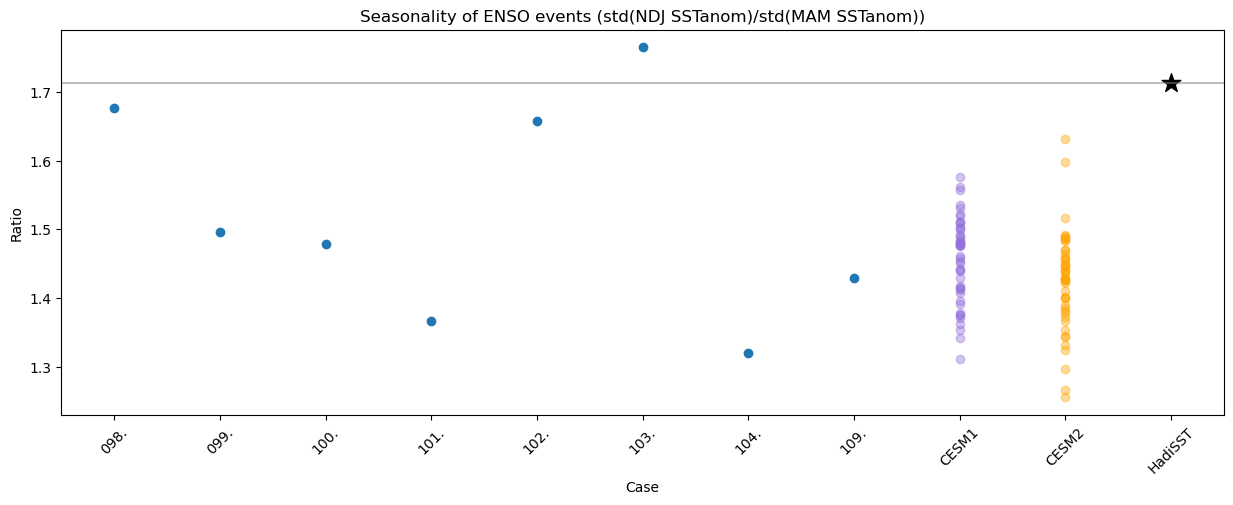

In [23]:
fig,axs=plt.subplots(1,1,figsize=(15,5))

axs.scatter(corrs.case.values, seasonality_cases)
axs.plot(np.full([len(cor_case_cesm1.event.values)], 'CESM1'), seasonality_cases_cesm1, 'o', color='mediumpurple', alpha=0.4)
axs.plot(np.full([len(cor_case_cesm2.event.values)], 'CESM2'), seasonality_cases_cesm2, 'o', color='orange', alpha=0.4)
axs.scatter('HadiSST', seasonality_obs, color='k', marker='*', s=200)
axs.axhline(seasonality_obs, color='grey',alpha=0.5)

axs.set_title('Seasonality of ENSO events (std(NDJ SSTanom)/std(MAM SSTanom))')
axs.set_ylabel('Ratio')
axs.set_xlabel('Case')

plt.setp( axs.xaxis.get_majorticklabels(), rotation=45 )
plt.show()


*Variance of nino 3.4 SST anomalies*

First day in file is  0001-01-16 12:00:00


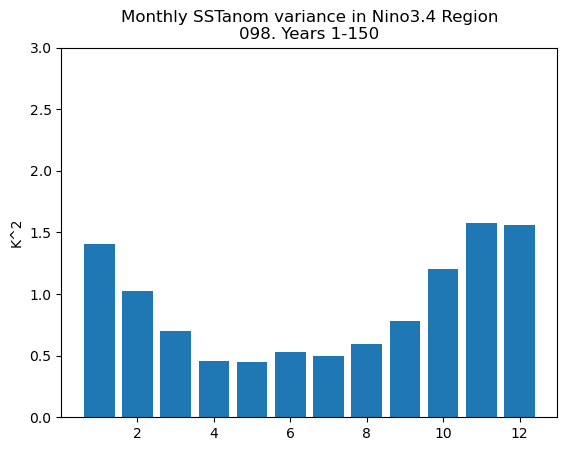

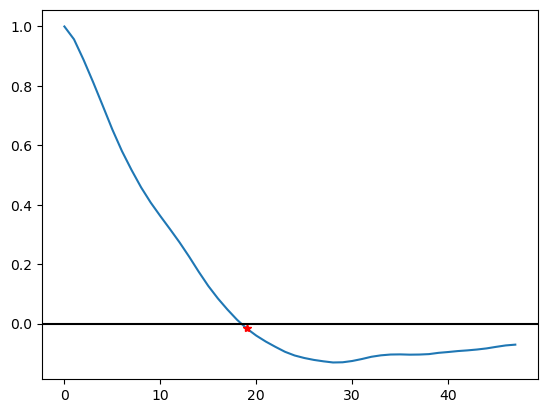

First day in file is  0001-01-16 12:00:00


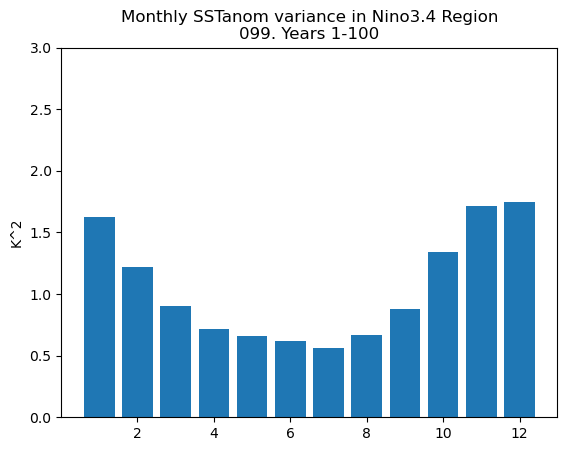

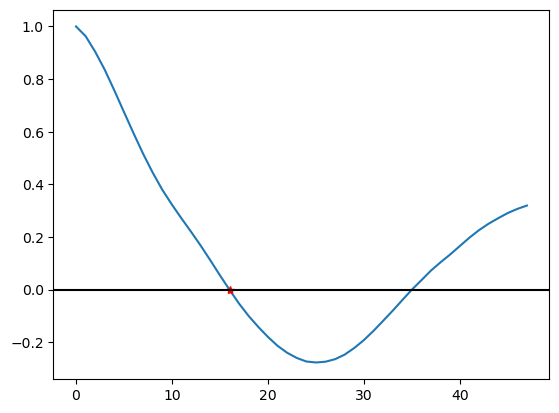

First day in file is  0001-01-16 12:00:00


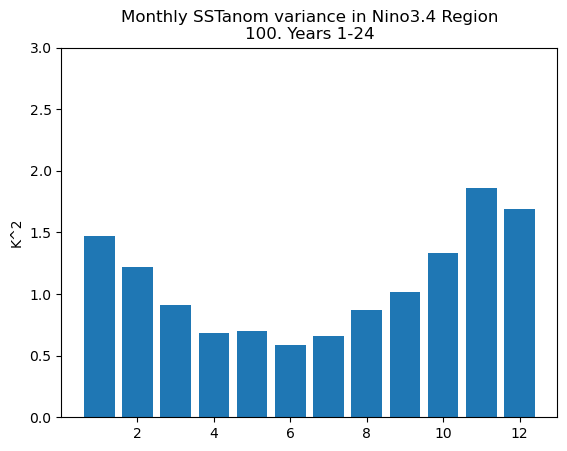

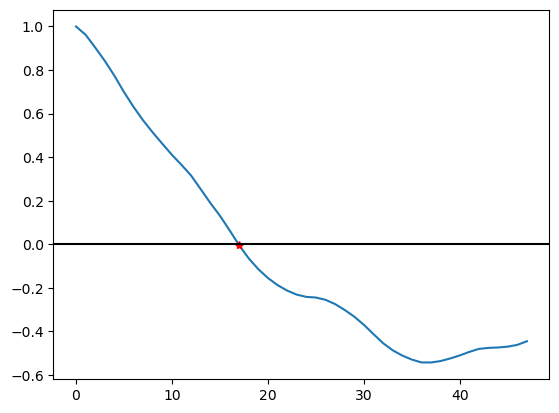

First day in file is  0001-01-16 12:00:00


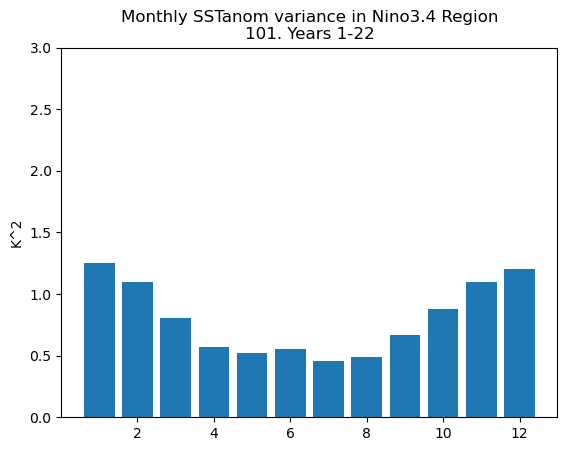

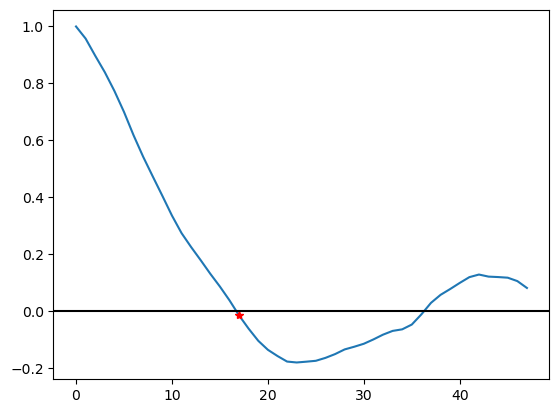

First day in file is  0001-01-16 12:00:00


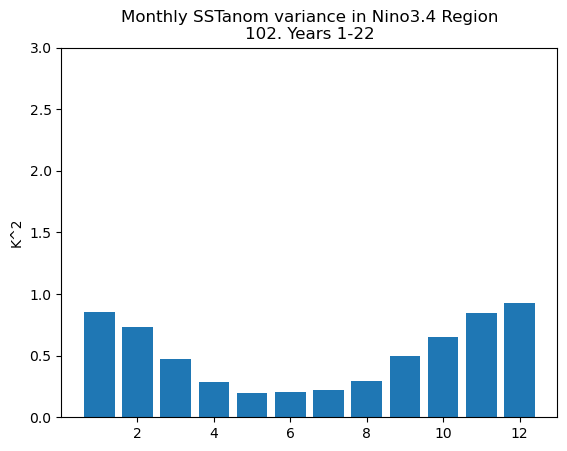

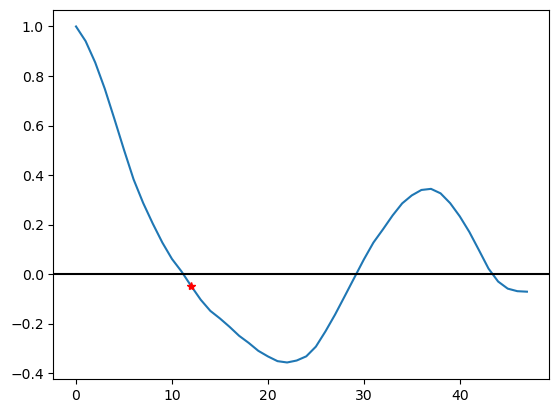

First day in file is  0001-01-16 12:00:00


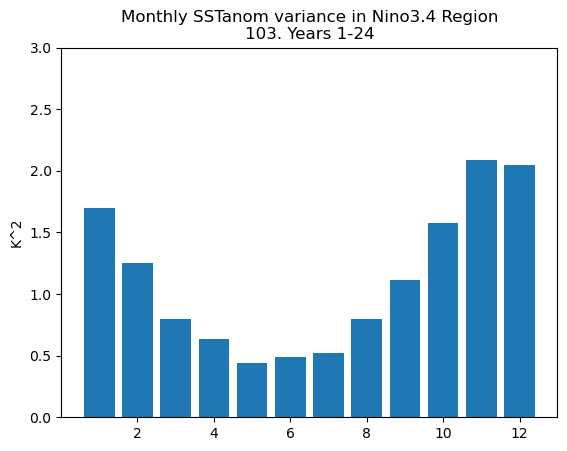

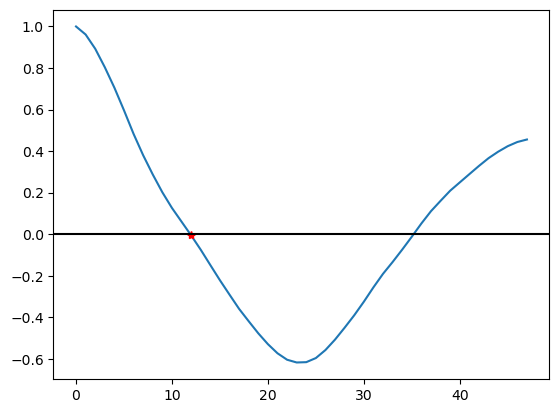

First day in file is  0001-01-16 12:00:00


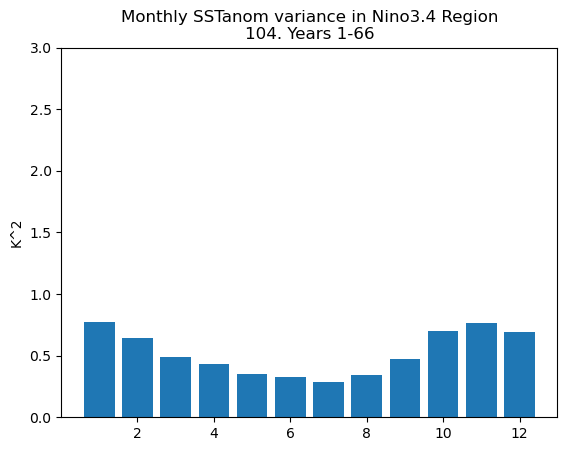

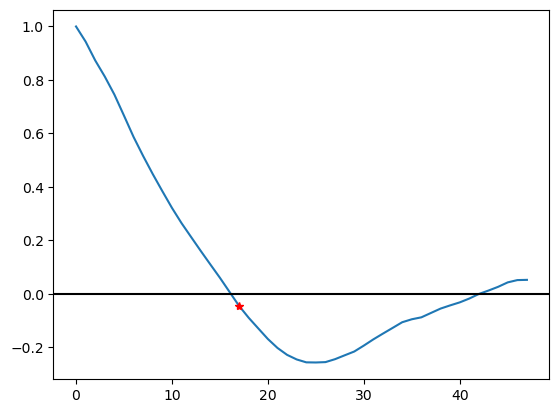

First day in file is  0001-01-16 12:00:00


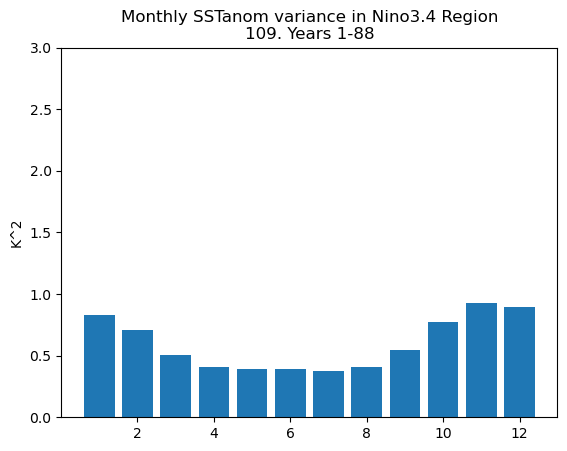

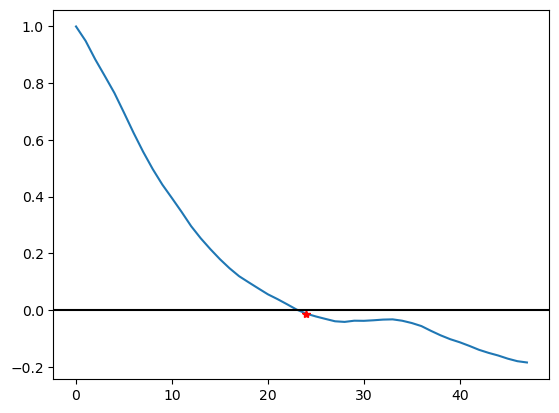

In [24]:

## Observations
nino34_var_obs = nino34_obs.groupby('time.month').var()

## Reproduce the autocorrelation plot from Rich 
nino34_obs_pd = pd.Series(nino34_obs.values)

nino34_ac_obs     = np.full([48], np.nan)
transit_month_obs = np.nan
for iLag in range(48):
    nino34_ac_obs[iLag] = nino34_obs_pd.autocorr(lag=iLag)
    if ((nino34_ac_obs[iLag-1]>0) & (nino34_ac_obs[iLag]<0) & (np.isfinite(transit_month_obs)==False)):
        transit_month_obs = iLag



## Handle model data ------
nino34_var    = np.full([len(listFiles_TS), 12], np.nan)
nino34_ac     = np.full([len(listFiles_TS), 48], np.nan)
transit_month = np.full([len(listFiles_TS)], np.nan)

# for iSim in range(2):
for iSim in range(len(listFiles_TS)):
    DS = xr.open_dataset(listFiles_TS[iSim]) 
    if DS['time.day'].isel(time=0).values==1:
        DS = cesm_correct_time(DS)
    else: 
        print('First day in file is ', DS.time.values[0])

    startYear = DS.isel(time=0)['time.year'].values
    endYear   = DS.isel(time=-1)['time.year'].values
    
    ## Add case ID (short name) to the DS
    x = re.search("BLT1850.ne30_t232.", listFiles_TS[iSim])
    if x:
        caseName = listFiles_TS[iSim][x.span()[-1]:4+x.span()[-1]]
    else: 
        x = re.search("BLTHIST.ne30_t232.", listFiles_TS[iSim])
        caseName = 'HIST_'+listFiles_TS[iSim][x.span()[-1]:4+x.span()[-1]]
    
    ocnMask = DS.LANDFRAC.values
    ocnMask[ocnMask>0.45] = np.nan
    ocnMask[ocnMask<=0.45] = 1
    
    # Detrend data 
    TS = DS.TS 
    ts = signal.detrend(TS, axis=0, type='linear')
    # Get SST 
    sst = ts * ocnMask
    
    sst = xr.DataArray(sst, 
        coords={'time': DS.time.values,
                'lat':  DS.lat.values, 
                'lon':  DS.lon.values}, 
        dims=["time", "lat", "lon"])
    
    # Remove annual cycle from monthly data 
    sst_anom = rmMonAnnCyc(sst)
    
    ## Compute nino 3.4 index
    ilats = np.where((sst_anom.lat.values>=lat_s34)  & (sst_anom.lat.values<=lat_n34))[0]
    ilons = np.where((sst_anom.lon.values>=lon_e34)  & (sst_anom.lon.values<=lon_w34))[0]
    
    # # Compute weights and get Nino3.4 
    regionTS = sst_anom.isel(lat=ilats, lon=ilons)
    coswgt   = np.cos(np.deg2rad(regionTS.lat))
    
    nino34     = regionTS.weighted(coswgt).mean(('lon','lat'))

    ## Reproduce the variance plot from Rich
    #   NOTE: doesn't match exactly, likely because I use cos(lat) for weights instead of a gaussian like Rich 
    nino34_var_monthly = nino34.groupby('time.month').var()
    nino34_var[iSim,:] = nino34_var_monthly

    plt.bar(np.arange(12)+1, nino34_var_monthly)
    plt.title('Monthly SSTanom variance in Nino3.4 Region\n'+caseName+' Years '+str(startYear)+'-'+str(endYear) )
    plt.ylim([0.0, 3.0])
    plt.ylabel('K^2')
    plt.show()

    ## Reproduce the autocorrelation plot from Rich 
    nino34_pd = pd.Series(nino34.values)
    
    for iLag in range(48):
        nino34_ac[iSim, iLag] = nino34_pd.autocorr(lag=iLag)
        if ((nino34_ac[iSim, iLag-1]>0) & (nino34_ac[iSim, iLag]<0) & (np.isfinite(transit_month[iSim])==False)):
            transit_month[iSim] = iLag
            
    plt.plot(np.arange(48), nino34_ac[iSim,:])
    plt.plot(transit_month[iSim], nino34_ac[iSim, int(transit_month[iSim])], 'r*')
    plt.axhline(0,color='k')
    plt.show()


## Handle model data: CESM1 and CESM2 PI  ------
nino34_var_cesm1    = np.full([len(nino34_cesm1.event.values), 12], np.nan)
nino34_ac_cesm1     = np.full([len(nino34_cesm1.event.values), 48], np.nan)
transit_month_cesm1 = np.full([len(nino34_cesm1.event.values)], np.nan)

for iSim in range(len(nino34_cesm1.event.values)):

    nino34 = nino34_cesm1.isel(event=iSim)
    
    ## Reproduce the variance plot from Rich
    #   NOTE: doesn't match exactly, likely because I use cos(lat) for weights instead of a gaussian like Rich 
    nino34_var_monthly = nino34.groupby('time.month').var()
    nino34_var_cesm1[iSim,:] = nino34_var_monthly

    ## Reproduce the autocorrelation plot from Rich 
    nino34_pd = pd.Series(nino34.values)
    
    for iLag in range(48):
        nino34_ac_cesm1[iSim, iLag] = nino34_pd.autocorr(lag=iLag)
        if ((nino34_ac_cesm1[iSim, iLag-1]>0) & (nino34_ac_cesm1[iSim, iLag]<0) & (np.isfinite(transit_month_cesm1[iSim])==False)):
            transit_month_cesm1[iSim] = iLag



nino34_var_cesm2    = np.full([len(nino34_cesm2.event.values), 12], np.nan)
nino34_ac_cesm2     = np.full([len(nino34_cesm2.event.values), 48], np.nan)
transit_month_cesm2 = np.full([len(nino34_cesm2.event.values)], np.nan)

for iSim in range(len(nino34_cesm2.event.values)):

    nino34 = nino34_cesm2.isel(event=iSim)
    
    ## Reproduce the variance plot from Rich
    #   NOTE: doesn't match exactly, likely because I use cos(lat) for weights instead of a gaussian like Rich 
    nino34_var_monthly = nino34.groupby('time.month').var()
    nino34_var_cesm2[iSim,:] = nino34_var_monthly

    ## Reproduce the autocorrelation plot from Rich 
    nino34_pd = pd.Series(nino34.values)
    
    for iLag in range(48):
        nino34_ac_cesm2[iSim, iLag] = nino34_pd.autocorr(lag=iLag)
        if ((nino34_ac_cesm2[iSim, iLag-1]>0) & (nino34_ac_cesm2[iSim, iLag]<0) & (np.isfinite(transit_month_cesm2[iSim])==False)):
            transit_month_cesm2[iSim] = iLag



In [ ]:
# axs[1].plot(lons_0p5Contour_cesm1, np.full([len(cor_case_cesm1.event.values)], 'CESM1'), 'o', color='mediumpurple', alpha=0.4)


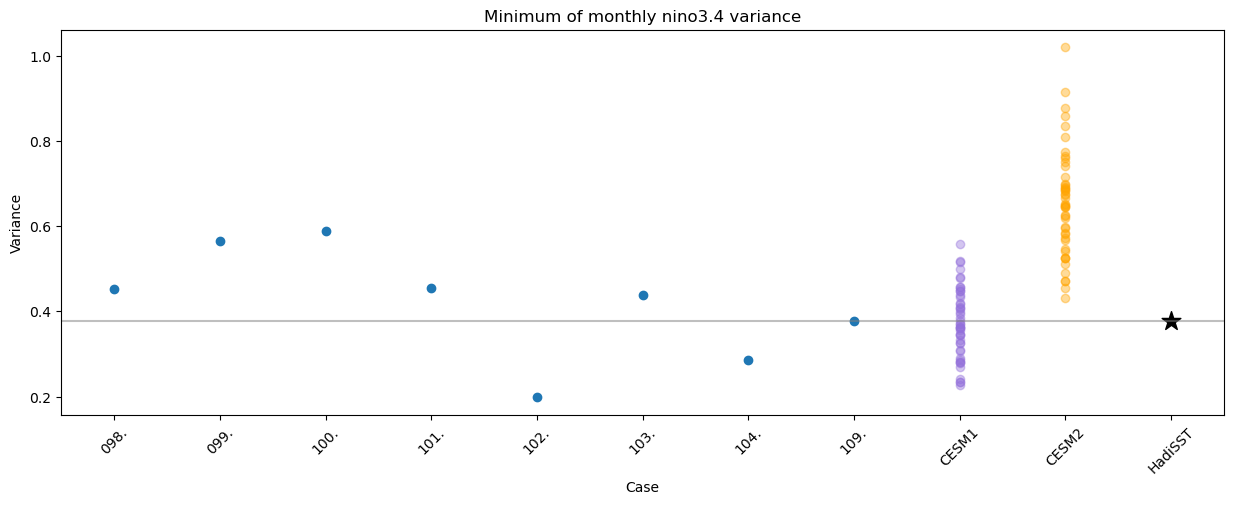

In [25]:
fig,axs=plt.subplots(1,1,figsize=(15,5))

axs.scatter(corrs.case.values, nino34_var.min(axis=1))
axs.plot(np.full([len(cor_case_cesm2.event.values)], 'CESM1'), nino34_var_cesm1.min(axis=1), 'o', color='mediumpurple', alpha=0.4)
axs.plot(np.full([len(cor_case_cesm2.event.values)], 'CESM2'), nino34_var_cesm2.min(axis=1), 'o', color='orange', alpha=0.4)
axs.scatter('HadiSST', nino34_var_obs.min(), color='k', marker='*', s=200)
axs.axhline(nino34_var_obs.min(), color='grey',alpha=0.5)

axs.set_title('Minimum of monthly nino3.4 variance')
axs.set_ylabel('Variance')
axs.set_xlabel('Case')

plt.setp( axs.xaxis.get_majorticklabels(), rotation=45 )
plt.show()


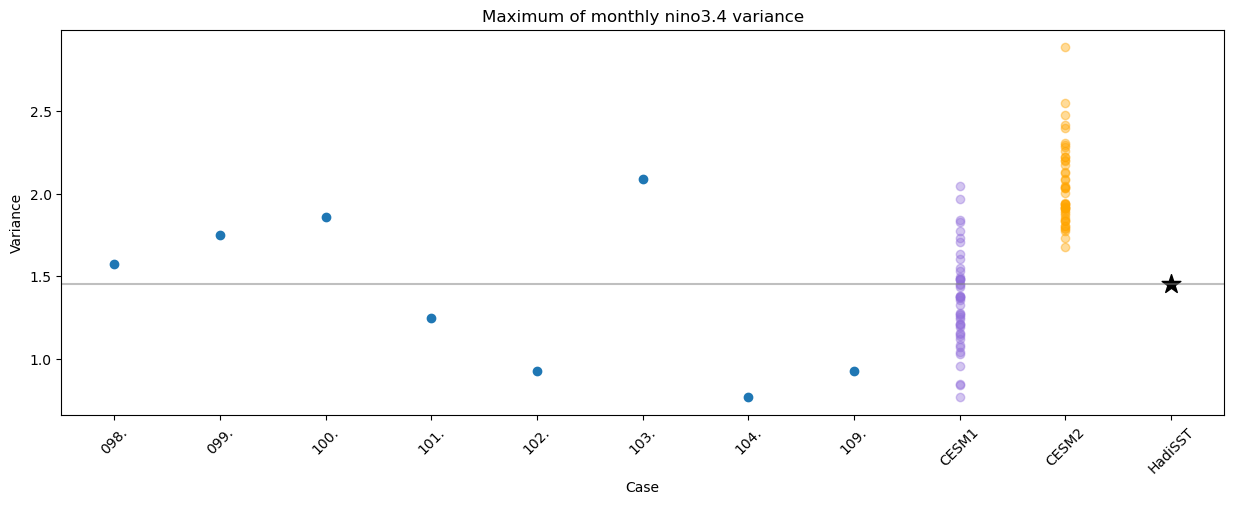

In [26]:
fig,axs=plt.subplots(1,1,figsize=(15,5))

axs.scatter(corrs.case.values, nino34_var.max(axis=1))
axs.plot(np.full([len(cor_case_cesm2.event.values)], 'CESM1'), nino34_var_cesm1.max(axis=1), 'o', color='mediumpurple', alpha=0.4)
axs.plot(np.full([len(cor_case_cesm2.event.values)], 'CESM2'), nino34_var_cesm2.max(axis=1), 'o', color='orange', alpha=0.4)
axs.scatter('HadiSST', nino34_var_obs.max(), color='k', marker='*', s=200)
axs.axhline(nino34_var_obs.max(), color='grey',alpha=0.5)

axs.set_title('Maximum of monthly nino3.4 variance')
axs.set_ylabel('Variance')
axs.set_xlabel('Case')

plt.setp( axs.xaxis.get_majorticklabels(), rotation=45 )
plt.show()


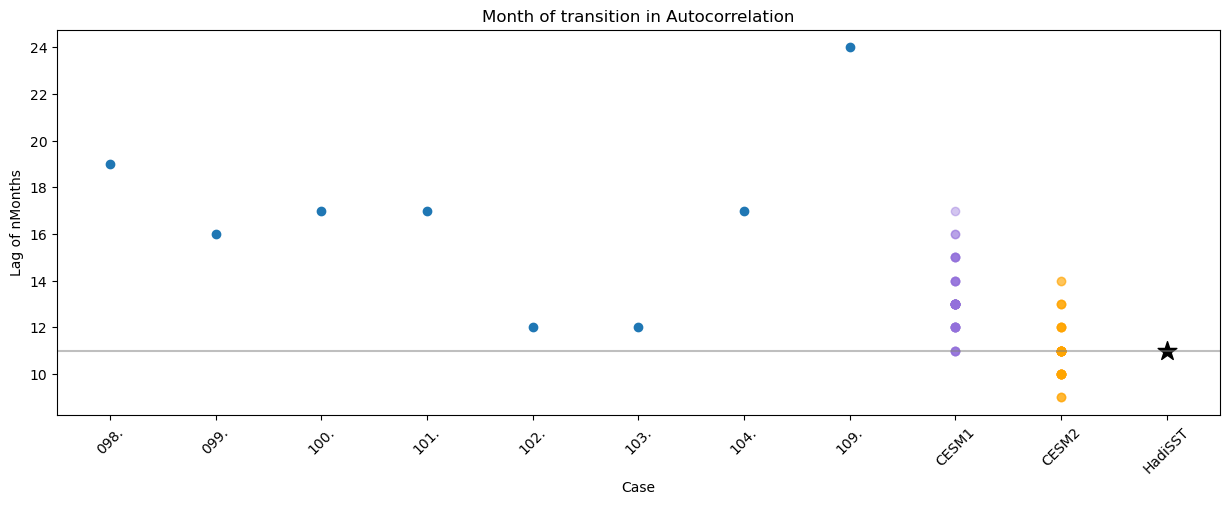

In [27]:
fig,axs=plt.subplots(1,1,figsize=(15,5))

axs.scatter(corrs.case.values, transit_month)
axs.plot(np.full([len(cor_case_cesm2.event.values)], 'CESM1'), transit_month_cesm1, 'o', color='mediumpurple', alpha=0.4)
axs.plot(np.full([len(cor_case_cesm2.event.values)], 'CESM2'), transit_month_cesm2, 'o', color='orange', alpha=0.4)
axs.scatter('HadiSST', transit_month_obs, color='k', marker='*', s=200)
axs.axhline(transit_month_obs, color='grey',alpha=0.5)

axs.set_title('Month of transition in Autocorrelation')
axs.set_ylabel('Lag of nMonths')
axs.set_xlabel('Case')

plt.setp( axs.xaxis.get_majorticklabels(), rotation=45 )
plt.show()


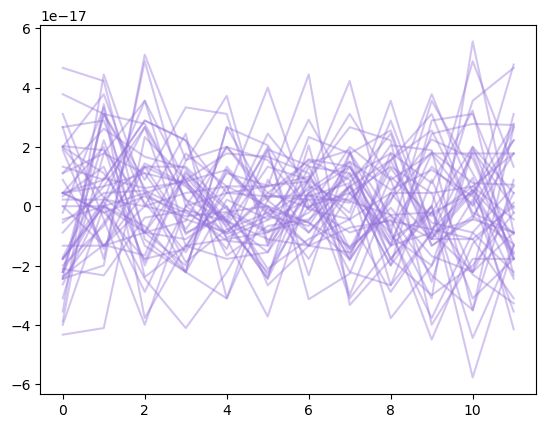

In [27]:
annNino34anoms_cesm1 = nino34_cesm1.groupby('time.month').mean(dim='time')

for iEvent in range(len(nino34_cesm1.event.values)):
    plt.plot(np.arange(12), annNino34anoms_cesm1.isel(event=iEvent), color='mediumpurple', alpha=0.4)


## Mean state bias vs. ENSO performance

In [35]:
sst_bias = np.full([len(listFiles_TS), 4, len(corrs.lat.values), len(corrs.lon.values)], np.nan)

for iSim in range(len(listFiles_TS)): 
# for iSim in range(2): 
    DS = xr.open_dataset(listFiles_TS[iSim]) 
    
    ## Add case ID (short name) to the DS
    x        = re.search("BLT1850.ne30_t232.", listFiles_TS[iSim])
    caseName = listFiles_TS[iSim][x.span()[-1]:4+x.span()[-1]]

    # Get sst_anom
    ocnMask = DS.LANDFRAC.isel(time=0).values
    ocnMask[ocnMask>0.45] = np.nan
    ocnMask[ocnMask<=0.45] = 1
    
    # Detrend data 
    TS = DS.TS 
    ts = signal.detrend(TS, axis=0, type='linear') # Remove linear/constant trend 
    # Get SST 
    sst = ts * ocnMask
    
    sst = xr.DataArray(sst, 
        coords={'time': DS.time.values,
                'lat':  DS.lat.values, 
                'lon':  DS.lon.values}, 
        dims=["time", "lat", "lon"])
    
    # # Remove annual cycle from monthly data 
    # sst_anom = rmMonAnnCyc(sst)

    # Get seasonal means 
    month_length = sst.time.dt.days_in_month
    weights = ( month_length.groupby("time.season") / month_length.groupby("time.season").sum() )
    # Calculate the weighted average
    sst_case_weighted = (sst * weights).groupby("time.season").sum(dim="time")
    del month_length,weights

    # Get seasonal mean in observations 
    month_length = sst_obs.time.dt.days_in_month
    weights = ( month_length.groupby("time.season") / month_length.groupby("time.season").sum() )
    # Calculate the weighted average
    sst_obs_weighted = (sst_obs * weights).groupby("time.season").sum(dim="time")
    
    # Compute bias vs. observations (seasonally) 
    sst_bias[iSim,:,:,:] = (sst_case_weighted - sst_obs_weighted) * ocnMask

    # sst_bias.sel(season='JJA').plot()
    print('Done with case %i of %i'% (iSim+1, len(listFiles_TS)))


Done with case 1 of 39
Done with case 2 of 39
Done with case 3 of 39
Done with case 4 of 39
Done with case 5 of 39
Done with case 6 of 39
Done with case 7 of 39
Done with case 8 of 39
Done with case 9 of 39
Done with case 10 of 39
Done with case 11 of 39
Done with case 12 of 39
Done with case 13 of 39
Done with case 14 of 39
Done with case 15 of 39
Done with case 16 of 39
Done with case 17 of 39
Done with case 18 of 39
Done with case 19 of 39
Done with case 20 of 39
Done with case 21 of 39
Done with case 22 of 39
Done with case 23 of 39
Done with case 24 of 39
Done with case 25 of 39
Done with case 26 of 39
Done with case 27 of 39
Done with case 28 of 39
Done with case 29 of 39
Done with case 30 of 39
Done with case 31 of 39
Done with case 32 of 39
Done with case 33 of 39
Done with case 34 of 39
Done with case 35 of 39
Done with case 36 of 39
Done with case 37 of 39
Done with case 38 of 39
Done with case 39 of 39


In [36]:
sst_bias = xr.DataArray(sst_bias, 
    coords={
            'case':   corrs.case.values, 
            'season': sst_case_weighted.season.values,
            'lat': sst_case_weighted.lat.values, 
            'lon':sst_case_weighted.lon.values}, 
    dims=["case", "season", "lat", "lon"])


In [37]:
sst_bias_cesm1 = np.full([nSamples, 4, len(corrs.lat.values), len(corrs.lon.values)], np.nan)
sst_bias_cesm2 = np.full([nSamples, 4, len(corrs.lat.values), len(corrs.lon.values)], np.nan)

for iSim in range(nSamples): 
    DS_cesm1 = DS_cesm1_events.isel(event=iSim)
    DS_cesm2 = DS_cesm2_events.isel(event=iSim)
    
    # Get sst_anom
    ocnMask = DS_ocn.LANDFRAC.isel(time=0).values
    ocnMask[ocnMask>0.45] = np.nan
    ocnMask[ocnMask<=0.45] = 1
    
    # Detrend data 
    ts_cesm1 = signal.detrend(DS_cesm1, axis=0, type='linear') # Remove linear/constant trend 
    ts_cesm2 = signal.detrend(DS_cesm2, axis=0, type='linear') # Remove linear/constant trend 
    # Get SST 
    sst_cesm1 = ts_cesm1 * ocnMask
    sst_cesm2 = ts_cesm2 * ocnMask
    
    sst_cesm1 = xr.DataArray(sst_cesm1, 
        coords={'time': DS_cesm1.time.values,
                'lat':  DS_ocn.lat.values, 
                'lon':  DS_ocn.lon.values}, 
        dims=["time", "lat", "lon"])

    sst_cesm2 = xr.DataArray(sst_cesm2, 
        coords={'time': DS_cesm2.time.values,
                'lat':  DS_ocn.lat.values, 
                'lon':  DS_ocn.lon.values}, 
        dims=["time", "lat", "lon"])
    

    # Get seasonal means in CESM1
    month_length = sst_cesm1.time.dt.days_in_month
    weights = ( month_length.groupby("time.season") / month_length.groupby("time.season").sum() )
    # Calculate the weighted average
    sst_cesm1_weighted = (sst_cesm1 * weights).groupby("time.season").sum(dim="time")
    del month_length,weights

    # Get seasonal means in CESM2
    month_length = sst_cesm2.time.dt.days_in_month
    weights = ( month_length.groupby("time.season") / month_length.groupby("time.season").sum() )
    # Calculate the weighted average
    sst_cesm2_weighted = (sst_cesm2 * weights).groupby("time.season").sum(dim="time")
    del month_length,weights

    # Get seasonal mean in observations 
    month_length = sst_obs.time.dt.days_in_month
    weights = ( month_length.groupby("time.season") / month_length.groupby("time.season").sum() )
    # Calculate the weighted average
    sst_obs_weighted = (sst_obs * weights).groupby("time.season").sum(dim="time")
    
    # Compute bias vs. observations (seasonally) 
    sst_bias_cesm1[iSim,:,:,:] = (sst_cesm1_weighted - sst_obs_weighted) * ocnMask
    sst_bias_cesm2[iSim,:,:,:] = (sst_cesm2_weighted - sst_obs_weighted) * ocnMask

    # sst_bias.sel(season='JJA').plot()
    print('Done with case %i of %i'% (iSim+1, nSamples))


Done with case 1 of 47
Done with case 2 of 47
Done with case 3 of 47
Done with case 4 of 47
Done with case 5 of 47
Done with case 6 of 47
Done with case 7 of 47
Done with case 8 of 47
Done with case 9 of 47
Done with case 10 of 47
Done with case 11 of 47
Done with case 12 of 47
Done with case 13 of 47
Done with case 14 of 47
Done with case 15 of 47
Done with case 16 of 47
Done with case 17 of 47
Done with case 18 of 47
Done with case 19 of 47
Done with case 20 of 47
Done with case 21 of 47
Done with case 22 of 47
Done with case 23 of 47
Done with case 24 of 47
Done with case 25 of 47
Done with case 26 of 47
Done with case 27 of 47
Done with case 28 of 47
Done with case 29 of 47
Done with case 30 of 47
Done with case 31 of 47
Done with case 32 of 47
Done with case 33 of 47
Done with case 34 of 47
Done with case 35 of 47
Done with case 36 of 47
Done with case 37 of 47
Done with case 38 of 47
Done with case 39 of 47
Done with case 40 of 47
Done with case 41 of 47
Done with case 42 of 47
D

In [38]:
sst_bias_cesm1 = xr.DataArray(sst_bias_cesm1, 
    coords={
            'event':   np.arange(nSamples),
            'season': sst_cesm1_weighted.season.values,
            'lat': sst_cesm1_weighted.lat.values, 
            'lon':sst_cesm1_weighted.lon.values}, 
    dims=["event", "season", "lat", "lon"])

sst_bias_cesm2 = xr.DataArray(sst_bias_cesm2, 
    coords={
            'event':   np.arange(nSamples),
            'season': sst_cesm2_weighted.season.values,
            'lat': sst_cesm2_weighted.lat.values, 
            'lon':sst_cesm2_weighted.lon.values}, 
    dims=["event", "season", "lat", "lon"])


Text(0.72, 0.5, 'East Pacific')

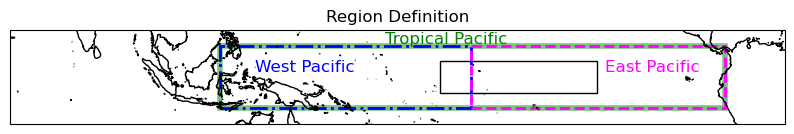

In [66]:
fig,axs = plt.subplots(1,1, figsize=(10,11), subplot_kw={"projection":ccrs.PlateCarree(central_longitude=210)})
axs.coastlines()     
axs.set_extent([53,300,-15,15], crs=ccrs.PlateCarree())

axs.add_patch(patches.Rectangle(xy=[lon_e34, lat_s34], width=(lon_w34-lon_e34), height=(lat_n34-lat_s34),
                            facecolor='none', edgecolor='k',linestyle='-',
                            linewidth=1, transform=ccrs.PlateCarree()))

# Full Pacific
axs.add_patch(patches.Rectangle(xy=[120, -10], width=(281-120), height=20,
                            facecolor='none', edgecolor='green',linestyle='-',alpha=0.5,
                            linewidth=4, transform=ccrs.PlateCarree()))
plt.gcf().text(0.5, 0.5255, 'Tropical Pacific', fontsize=12, color='green')

# # SCS
# axs.add_patch(patches.Rectangle(xy=[100, -10], width=(150-120), height=20,
#                             facecolor='none', edgecolor='orangered',linestyle='-',
#                             linewidth=1, transform=ccrs.PlateCarree()))

# West Pacific
axs.add_patch(patches.Rectangle(xy=[120, -10], width=(200-120), height=20,
                            facecolor='none', edgecolor='blue',linestyle='-.',
                            linewidth=2, transform=ccrs.PlateCarree()))
plt.gcf().text(0.37, 0.5, 'West Pacific', fontsize=12, color='blue')

# East Pacific
axs.add_patch(patches.Rectangle(xy=[200, -10], width=(281-200), height=20,
                            facecolor='none', edgecolor='magenta',linestyle='--',
                            linewidth=2, transform=ccrs.PlateCarree()))

axs.set_title('Region Definition')
plt.gcf().text(0.72, 0.5, 'East Pacific', fontsize=12, color='magenta')



In [39]:
df_sel = df_table.drop([0,1,2,3,10])

iKeep_corrs = np.where(corrs.case.values!='067.')[0]

lons_zeroContour_match = lons_zeroContour[iKeep_corrs]
lons_0p5Contour_match = lons_0p5Contour[iKeep_corrs]
numMonthsAboveLimit_match   = numMonthsAboveLimit[iKeep_corrs]
# seasonality_cases_match = seasonality_cases[iKeep_corrs]
corrs_case_match = corrs.case.values[iKeep_corrs]



In [52]:
# # Full Pacific (green region) 
# lat_s = -10
# lat_n = 10
# lon_w = 120
# lon_e = 280
# titleString = 'Means computed over tropical Pacific'

# # West Pacific (blue region) 
# lat_s = -10
# lat_n = 10
# lon_w = 120
# lon_e = 200
# titleString = 'Means computed over tropical West Pacific'

# East Pacific (purple region) 
lat_s = -10
lat_n = 10
lon_w = 200
lon_e = 281
titleString = 'Means computed over tropical East Pacific'

# Select region and get mean
sst_bias_region = sst_bias.sel(lat=slice(lat_s,lat_n), lon=slice(lon_w,lon_e))
coswgt_region   = np.cos(np.deg2rad(sst_bias_region.lat))
bias_mean       = sst_bias_region.weighted(coswgt).mean(('lon','lat'))

bias_mean_match = bias_mean.isel(case=iKeep_corrs)

## Get regional mean in CESM1/2 too 
sst_bias_cesm1_region = sst_bias_cesm1.sel(lat=slice(lat_s,lat_n), lon=slice(lon_w,lon_e))
coswgt_cesm1_region   = np.cos(np.deg2rad(sst_bias_cesm1_region.lat))
bias_mean_cesm1       = sst_bias_cesm1_region.weighted(coswgt_cesm1_region).mean(('lon','lat'))

sst_bias_cesm2_region = sst_bias_cesm2.sel(lat=slice(lat_s,lat_n), lon=slice(lon_w,lon_e))
coswgt_cesm2_region   = np.cos(np.deg2rad(sst_bias_cesm2_region.lat))
bias_mean_cesm2       = sst_bias_cesm2_region.weighted(coswgt_cesm2_region).mean(('lon','lat'))



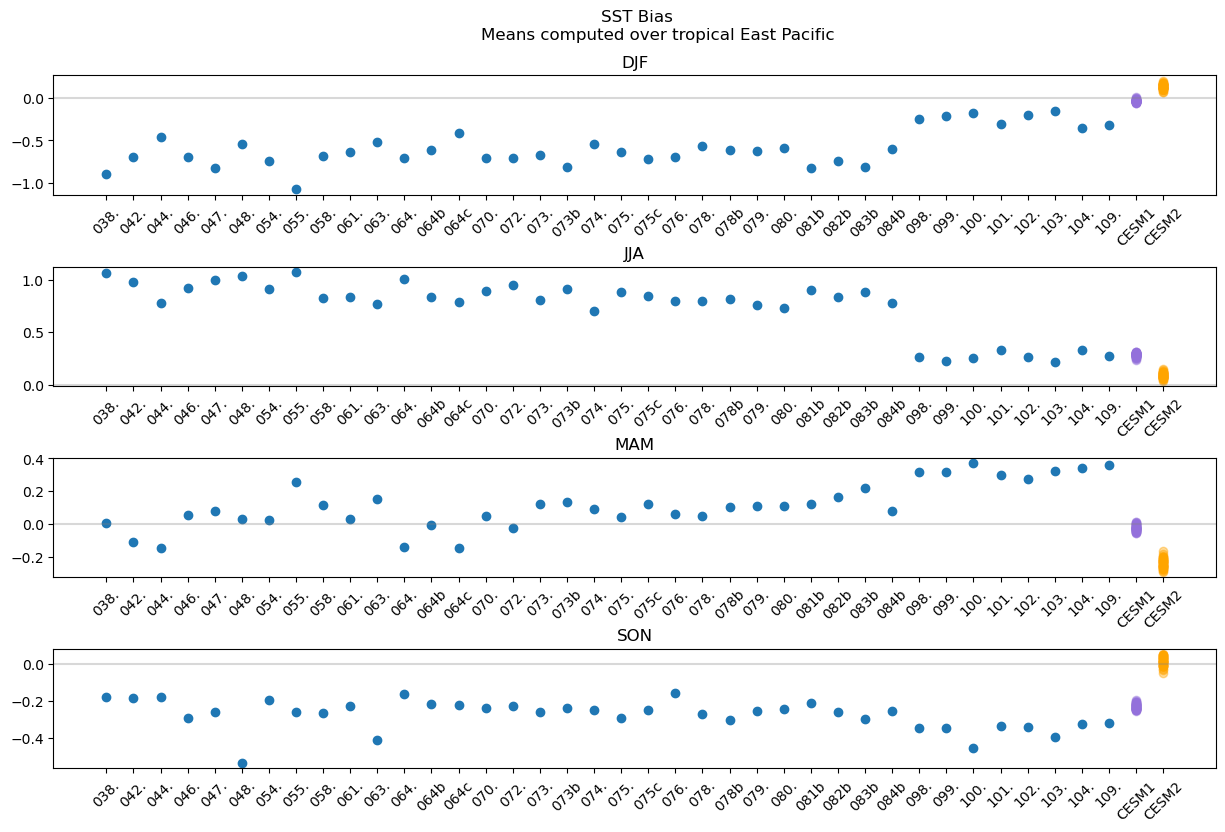

In [53]:
fig,axs = plt.subplots(4,1,figsize=(15,9))
axs = axs.ravel()

plt.gcf().text(0.49, 0.94, 'SST Bias', fontsize=12, color='k')
plt.gcf().text(0.41, 0.92, titleString, fontsize=12, color='k')

for iSeason in range(4):
    axs[iSeason].scatter(corrs_case_match, bias_mean_match.isel(season=iSeason))
    axs[iSeason].plot(np.full([nSamples], 'CESM1'), bias_mean_cesm1.isel(season=iSeason), 'o', alpha=0.4, color='mediumpurple')
    axs[iSeason].plot(np.full([nSamples], 'CESM2'), bias_mean_cesm2.isel(season=iSeason), 'o', alpha=0.4, color='orange')
    
    axs[iSeason].set_title(bias_mean_match.isel(season=iSeason).season.values)

    axs[iSeason].axhline(0,color='grey',alpha=0.3)
    
    plt.setp( axs[iSeason].xaxis.get_majorticklabels(), rotation=45 )


fig.subplots_adjust(hspace=0.6)

NameError: name 'seasonality_cases_match' is not defined

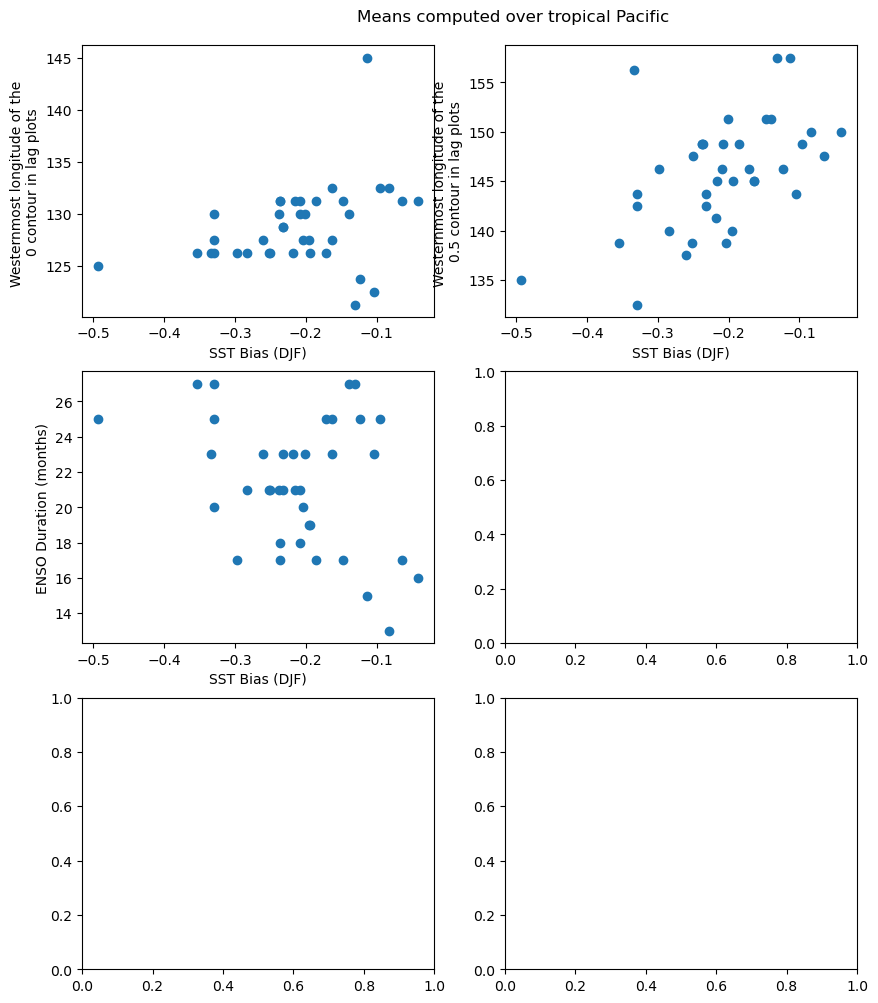

In [45]:
seasonsel = 'DJF'
xVar = bias_mean_match.sel(season=seasonsel).values 

corrArr = np.arange(len(corrs_case_match))

fig,axs = plt.subplots(3,2, figsize=(10,12))
axs = axs.ravel()

plt.gcf().text(0.4, 0.9, titleString, fontsize=12, color='k')

axs[0].scatter(xVar, lons_zeroContour_match)
# axs[0].scatter(xVar, lons_zeroContour_match, c=corrArr, cmap='turbo')
# axs[0].axhline(lonObs_zeroContour, color='k',alpha=0.5,linestyle='--')
axs[0].set_ylabel('Westernmost longitude of the \n0 contour in lag plots')
axs[0].set_xlabel('SST Bias ('+seasonsel+')')

axs[1].scatter(xVar, lons_0p5Contour_match)
# axs[1].scatter(xVar, lons_0p5Contour_match, c=corrArr, cmap='turbo')
# axs[1].axhline(lonObs_0p5Contour, color='k',alpha=0.5,linestyle='--')
axs[1].set_ylabel('Westernmost longitude of the \n0.5 contour in lag plots')
axs[1].set_xlabel('SST Bias ('+seasonsel+')')

axs[2].scatter(xVar, numMonthsAboveLimit_match)
# axs[2].scatter(xVar, numMonthsAboveLimit_match, c=corrArr, cmap='turbo')
# axs[2].axhline(numMonthsAboveLimit_obs, color='k',alpha=0.5,linestyle='--')
axs[2].set_ylabel('ENSO Duration (months)')
axs[2].set_xlabel('SST Bias ('+seasonsel+')')

axs[3].scatter(xVar, seasonality_cases_match)
# axs[3].scatter(xVar, seasonality_cases_match, c=corrArr, cmap='turbo')
# axs[3].axhline(seasonality_obs, color='k',alpha=0.5,linestyle='--')
axs[3].set_ylabel('ENSO Seasonaltiy (ratio)')
axs[3].set_xlabel('SST Bias ('+seasonsel+')')

axs[4].scatter(xVar, df_sel['Value of min variance'].values)
# axs[4].scatter(xVar, df_sel['Value of min variance'].values, c=corrArr, cmap='turbo')
axs[4].set_ylabel('Value of min SST variance (deg)')
axs[4].set_xlabel('SST Bias ('+seasonsel+')')

valArray = df_sel['Value of max variance'].copy()
valArray[valArray=='>3'] = '3'
axs[5].scatter(xVar, valArray.values.astype(float))
# axs[5].scatter(xVar, valArray.values.astype(float), c=corrArr, cmap='turbo')
axs[5].set_ylabel('Value of max SST variance (deg)')
axs[5].set_xlabel('SST Bias ('+seasonsel+')')

fig.subplots_adjust(wspace=0.3, hspace=0.3)

NameError: name 'seasonality_cases_match' is not defined

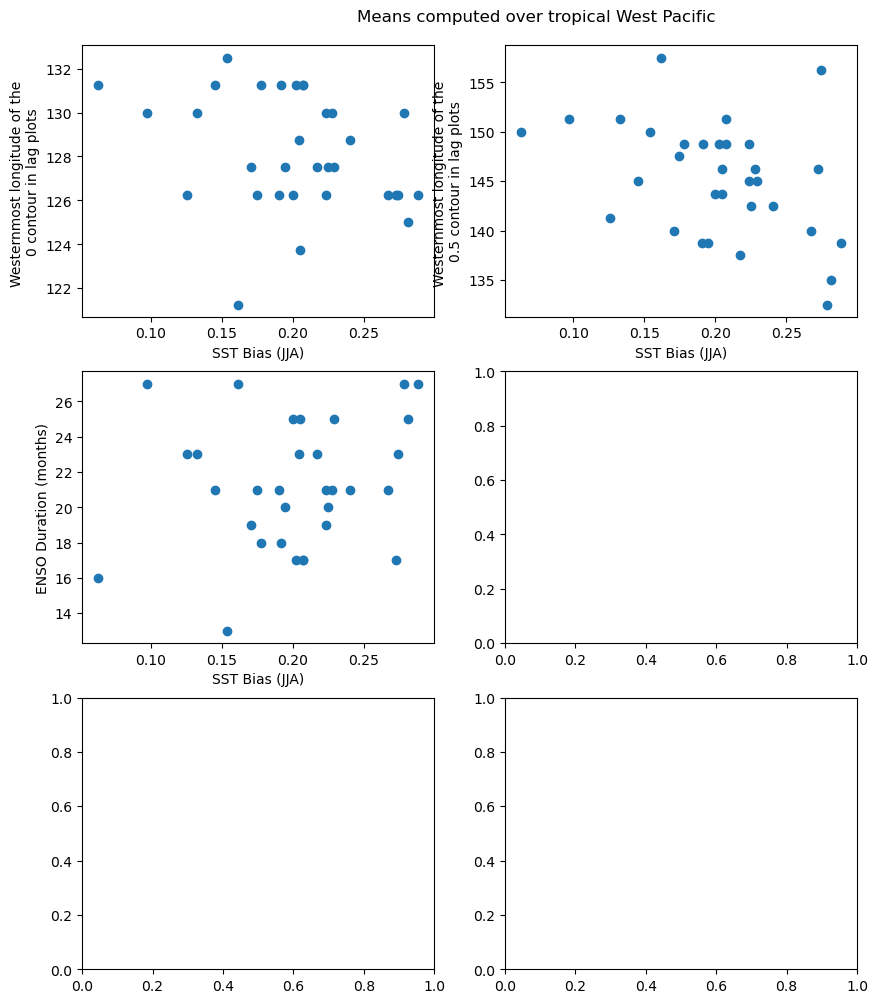

In [92]:
seasonsel = 'JJA'
xVar = bias_mean_match.sel(season=seasonsel).values 

fig,axs = plt.subplots(3,2, figsize=(10,12))
axs = axs.ravel()

plt.gcf().text(0.4, 0.9, titleString, fontsize=12, color='k')

axs[0].scatter(xVar, lons_zeroContour_match)
# axs[0].axhline(lonObs_zeroContour, color='k',alpha=0.5,linestyle='--')
axs[0].set_ylabel('Westernmost longitude of the \n0 contour in lag plots')
axs[0].set_xlabel('SST Bias ('+seasonsel+')')

axs[1].scatter(xVar, lons_0p5Contour_match)
# axs[1].axhline(lonObs_0p5Contour, color='k',alpha=0.5,linestyle='--')
axs[1].set_ylabel('Westernmost longitude of the \n0.5 contour in lag plots')
axs[1].set_xlabel('SST Bias ('+seasonsel+')')

axs[2].scatter(xVar, numMonthsAboveLimit_match)
# axs[2].axhline(numMonthsAboveLimit_obs, color='k',alpha=0.5,linestyle='--')
axs[2].set_ylabel('ENSO Duration (months)')
axs[2].set_xlabel('SST Bias ('+seasonsel+')')

axs[3].scatter(xVar, seasonality_cases_match)
# axs[3].axhline(seasonality_obs, color='k',alpha=0.5,linestyle='--')
axs[3].set_ylabel('ENSO Seasonaltiy (ratio)')
axs[3].set_xlabel('SST Bias ('+seasonsel+')')

axs[4].scatter(xVar, df_sel['Value of min variance'].values)
axs[4].set_ylabel('Value of min SST variance (deg)')
axs[4].set_xlabel('SST Bias ('+seasonsel+')')

valArray = df_sel['Value of max variance'].copy()
valArray[valArray=='>3'] = '3'
axs[5].scatter(xVar, valArray.values.astype(float))
axs[5].set_ylabel('Value of max SST variance (deg)')
axs[5].set_xlabel('SST Bias ('+seasonsel+')')

fig.subplots_adjust(wspace=0.3, hspace=0.3)

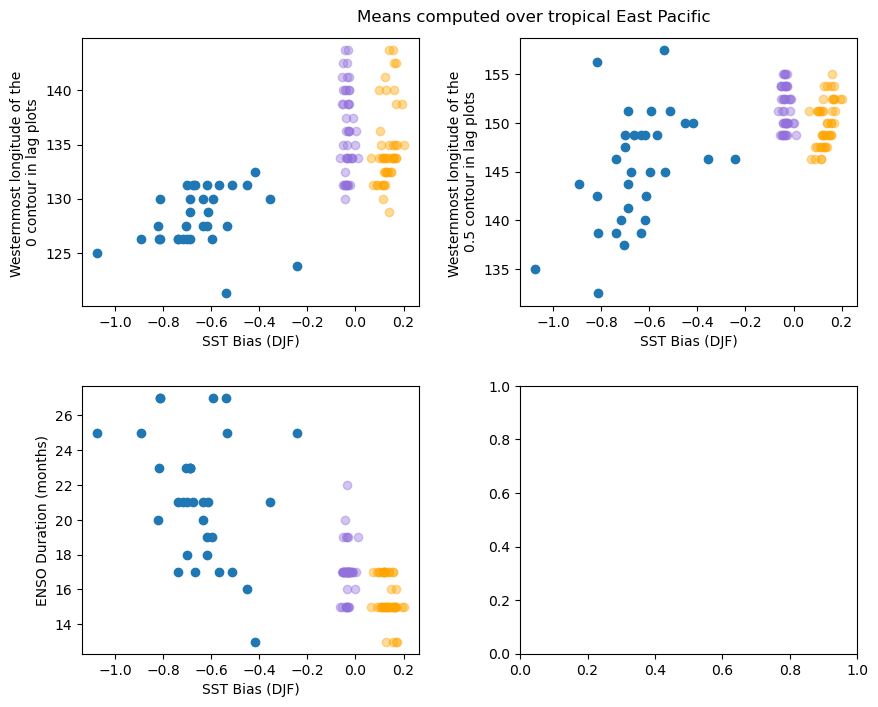

In [96]:
seasonsel = 'DJF'
xVar = bias_mean_match.sel(season=seasonsel).values 
xVar_cesm1 = bias_mean_cesm1.sel(season=seasonsel).values 
xVar_cesm2 = bias_mean_cesm2.sel(season=seasonsel).values 

fig,axs = plt.subplots(2,2, figsize=(10,8))
axs = axs.ravel()

plt.gcf().text(0.4, 0.9, titleString, fontsize=12, color='k')

axs[0].scatter(xVar, lons_zeroContour_match)
axs[0].scatter(xVar_cesm1, lons_zeroContour_cesm1,color='mediumpurple',alpha=0.4)
axs[0].scatter(xVar_cesm2, lons_zeroContour_cesm2,color='orange',alpha=0.4)
# axs[0].axhline(lonObs_zeroContour, color='k',alpha=0.5,linestyle='--')
axs[0].set_ylabel('Westernmost longitude of the \n0 contour in lag plots')
axs[0].set_xlabel('SST Bias ('+seasonsel+')')

axs[1].scatter(xVar, lons_0p5Contour_match)
axs[1].scatter(xVar_cesm1, lons_0p5Contour_cesm1,color='mediumpurple',alpha=0.4)
axs[1].scatter(xVar_cesm2, lons_0p5Contour_cesm2,color='orange',alpha=0.4)
# axs[1].axhline(lonObs_0p5Contour, color='k',alpha=0.5,linestyle='--')
axs[1].set_ylabel('Westernmost longitude of the \n0.5 contour in lag plots')
axs[1].set_xlabel('SST Bias ('+seasonsel+')')

axs[2].scatter(xVar, numMonthsAboveLimit_match)
axs[2].scatter(xVar_cesm1, numMonthsAboveLimit_cesm1,color='mediumpurple',alpha=0.4)
axs[2].scatter(xVar_cesm2, numMonthsAboveLimit_cesm2,color='orange',alpha=0.4)
# axs[2].axhline(numMonthsAboveLimit_obs, color='k',alpha=0.5,linestyle='--')
axs[2].set_ylabel('ENSO Duration (months)')
axs[2].set_xlabel('SST Bias ('+seasonsel+')')

# axs[3].scatter(xVar, seasonality_cases_match)
# # axs[3].axhline(seasonality_obs, color='k',alpha=0.5,linestyle='--')
# axs[3].set_ylabel('ENSO Seasonaltiy (ratio)')
# axs[3].set_xlabel('SST Bias ('+seasonsel+')')


fig.subplots_adjust(wspace=0.3, hspace=0.3)

## Read in climo's 

In [30]:
# climoVar_list = ['LHFLX','SHFLX','LWCF','SWCF','PRECT','PS','OMEGA500','SST','TAUX','TAUY','TGCLDLWP','U10','TREFHT']
# climoVar_list = ['LHFLX','SHFLX','LWCF','SWCF','PRECT','PS','SST','TAUX','TAUY','TGCLDLWP','U10','TREFHT','LANDFRAC','OCNFRAC']
climoVar_list = ['LHFLX','SHFLX','LWCF','SWCF','PRECT','PS','TAUX','TAUY','TGCLDLWP','U10','TREFHT','LANDFRAC','OCNFRAC']

climo_dir = '/glade/campaign/cgd/amp/amwg/climo/'

caseNames = [
       'b.e23_alpha16b.BLT1850.ne30_t232.038',
       'b.e23_alpha16b.BLT1850.ne30_t232.042',
       'b.e23_alpha16b.BLT1850.ne30_t232.044',
       'b.e23_alpha16b.BLT1850.ne30_t232.046',
       'b.e23_alpha16b.BLT1850.ne30_t232.047',
       'b.e23_alpha16b.BLT1850.ne30_t232.048',
       'b.e23_alpha16b.BLT1850.ne30_t232.054',
       'b.e23_alpha16g.BLT1850.ne30_t232.055',
       'b.e23_alpha16g.BLT1850.ne30_t232.058',
       'b.e23_alpha16g.BLT1850.ne30_t232.061',
       'b.e23_alpha16g.BLT1850.ne30_t232.063',
       'b.e23_alpha16g.BLT1850.ne30_t232.064',
       # 'b.e23_alpha16g.BLT1850.ne30_t232.064b',
       # 'b.e23_alpha16g.BLT1850.ne30_t232.064c',
       'b.e23_alpha16g.BLT1850.ne30_t232.067',
       'b.e23_alpha16g.BLT1850.ne30_t232.070',
       'b.e23_alpha16g.BLT1850.ne30_t232.072',
       'b.e23_alpha16g.BLT1850.ne30_t232.073',
       'b.e23_alpha16g.BLT1850.ne30_t232.073b',
       'b.e23_alpha16g.BLT1850.ne30_t232.074',
       'b.e23_alpha16g.BLT1850.ne30_t232.075',
       'b.e23_alpha16g.BLT1850.ne30_t232.075c',
       'b.e23_alpha16g.BLT1850.ne30_t232.076',
       # 'b.e23_alpha16g.BLT1850.ne30_t232.078',
       'b.e23_alpha16g.BLT1850.ne30_t232.078b',
       'b.e23_alpha16g.BLT1850.ne30_t232.079',
       'b.e23_alpha16g.BLT1850.ne30_t232.080',
       'b.e23_alpha16g.BLT1850.ne30_t232.081b',
       'b.e23_alpha16g.BLT1850.ne30_t232.082b',
       'b.e23_alpha16g.BLT1850.ne30_t232.083b',
       'b.e23_alpha16g.BLT1850.ne30_t232.084b',
       # 'b.e23_alpha17f.BLT1850.ne30_t232.091',
       # 'b.e23_alpha17f.BLT1850.ne30_t232.092',
       'b.e23_alpha17f.BLT1850.ne30_t232.093',
       'b.e23_alpha17f.BLT1850.ne30_t232.098',
       'b.e23_alpha17f.BLT1850.ne30_t232.099',
       'b.e23_alpha17f.BLT1850.ne30_t232.100',
       'b.e23_alpha17f.BLT1850.ne30_t232.101',
       'b.e23_alpha17f.BLT1850.ne30_t232.102', 
       'b.e30_beta02.BLT1850.ne30_t232.103',
       'b.e30_beta02.BLT1850.ne30_t232.104',
       'b.e30_beta02.BLT1850.ne30_t232.109',
]

for iCase in range(len(caseNames)):
    # Not all cases have same climo years, so want to pick first set here
    yrFolder = np.sort(glob.glob(climo_dir+caseNames[iCase]+'/*'))
    if len(yrFolder)==1: 
        path1 = str(yrFolder[0])+'/'
    elif len(yrFolder)>1: 
        path1 = str(yrFolder[-1])+'/'

    listFiles = np.sort(glob.glob(path1+'*.nc'))

    ds = xr.open_mfdataset(listFiles)[climoVar_list]

    # Add short alias for case ID
    x = re.search(".ne30_t232.", caseNames[iCase])
    caseID = caseNames[iCase][x.span()[-1]::]
    caseDS = ds.squeeze().assign_coords({"case":  caseID})

    # Combine into single DS
    if iCase==0: 
        allCases = caseDS
    else: 
        allCases = xr.concat([allCases, caseDS], "case") 

    print('Done with case %i of %i' % (iCase+1, len(caseNames)))

Done with case 1 of 37
Done with case 2 of 37
Done with case 3 of 37
Done with case 4 of 37
Done with case 5 of 37
Done with case 6 of 37
Done with case 7 of 37
Done with case 8 of 37
Done with case 9 of 37
Done with case 10 of 37
Done with case 11 of 37
Done with case 12 of 37
Done with case 13 of 37
Done with case 14 of 37
Done with case 15 of 37
Done with case 16 of 37
Done with case 17 of 37
Done with case 18 of 37
Done with case 19 of 37
Done with case 20 of 37
Done with case 21 of 37
Done with case 22 of 37
Done with case 23 of 37
Done with case 24 of 37
Done with case 25 of 37
Done with case 26 of 37
Done with case 27 of 37
Done with case 28 of 37
Done with case 29 of 37
Done with case 30 of 37
Done with case 31 of 37
Done with case 32 of 37
Done with case 33 of 37
Done with case 34 of 37
Done with case 35 of 37
Done with case 36 of 37
Done with case 37 of 37


In [36]:
caseNames[iCase]

'b.e23_alpha17f.BLT1850.ne30_t232.093'

In [31]:
allCases['time'] = pd.date_range(start="1850-01-15",end="1850-12-15", freq="30D")

In [39]:
np.shape(ocnMask_expanded)

(47, 600, 22, 288)

In [32]:
## Create some (ocean) means over each domain 

iLons_fullPac = np.where((corrs.lon.values>=120) & (corrs.lon.values<=281))[0]
iLats_fullPac = np.where((corrs.lat.values>=-10) & (corrs.lat.values<=10))[0]
ocnMask_all   = ocnMask_expanded[:,:,:,iLons_fullPac]
ocnMask_all   = ocnMask_all[:,:,iLats_fullPac,:]
ocnMask_all   = ocnMask_all[0:len(allCases.case.values), 0:12,:,:]

tropPacific_all_DS  = allCases.sel(lat=slice(-10,10), lon=slice(120,281)) * ocnMask_all
tropPacific_west_DS = allCases.sel(lat=slice(-10,10), lon=slice(120,200)) 
tropPacific_east_DS = allCases.sel(lat=slice(-10,10), lon=slice(200,281)) 

coswgt   = np.cos(np.deg2rad(tropPacific_all_DS.lat))

tropPacific_all_DS_mean   = tropPacific_all_DS.weighted(coswgt).mean(('lon','lat'))
tropPacific_west_DS_mean  = tropPacific_west_DS.weighted(coswgt).mean(('lon','lat'))
tropPacific_east_DS_mean  = tropPacific_east_DS.weighted(coswgt).mean(('lon','lat'))


## Seasonal averages? 
# Get seasonal means 
month_length = tropPacific_all_DS_mean.time.dt.days_in_month
weights = ( month_length.groupby("time.season") / month_length.groupby("time.season").sum() )
weights_all = ( month_length/ month_length.sum() )

# seasonal_tropPacific_all  = tropPacific_all_DS_mean.groupby('time.season').mean(dim='time')
# seasonal_tropPacific_west = tropPacific_west_DS_mean.groupby('time.season').mean(dim='time')
# seasonal_tropPacific_east = tropPacific_east_DS_mean.groupby('time.season').mean(dim='time')
seasonal_tropPacific_all  = (tropPacific_all_DS_mean*weights).groupby('time.season').sum(dim='time')
seasonal_tropPacific_west = (tropPacific_west_DS_mean*weights).groupby('time.season').sum(dim='time')
seasonal_tropPacific_east = (tropPacific_east_DS_mean*weights).groupby('time.season').sum(dim='time')


annual_tropPacific_all   = (tropPacific_all_DS_mean*weights_all).sum(dim='time')
annual_tropPacific_west  = (tropPacific_west_DS_mean*weights_all).sum(dim='time')
annual_tropPacific_east  = (tropPacific_east_DS_mean*weights_all).sum(dim='time')


In [33]:
## will need to drop cases that don't have climo read in above: 

iKeeps = np.where( (corrs.case.values!='064b') &  (corrs.case.values!='064c') &  
                   (corrs.case.values!='078.') & (corrs.case.values!='HIST_104.'))[0]


In [34]:
# Choose a colormap (e.g., 'viridis', 'plasma', 'inferno', 'cividis')
# cmap = plt.get_cmap('nipy_spectral')
cmap = plt.get_cmap('rainbow')
# Number of colors to extract
num_colors = len(corrs.case.values[iKeeps])
# Generate evenly spaced values between 0 and 1
colorList = [cmap(i) for i in np.linspace(0, 1, num_colors)]

# Ensure the colors are tuples of RGBA values
# Each element in colors should be a tuple like (R, G, B, A)
colorList = [tuple(color) for color in colorList]


In [ ]:
# make a weird plot of correlation strength...? (heat map)
correlations_arr = np.full([4, len(climoVar_list)], np.nan)

yArr = nino34_var.min(axis=1)[iKeeps]

for iSeason in range(4): 
    for iVar in range(len(climoVar_list)): 
        correlations_arr[iSeason, iVar] =  np.corrcoef(seasonal_tropPacific_all.isel(season=iSeason)[climoVar_list[iVar]].values, 
                                                       yArr)[0,1]**2

valfmt="{x:.2f}"
valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

fig, ax = plt.subplots(figsize=(14,5))
im = ax.imshow(correlations_arr)

# Show all ticks and label them with the respective list entries
ax.set_yticks(np.arange(4), labels=seasonal_tropPacific_all.season.values)
ax.set_xticks(np.arange(len(climoVar_list)), labels=climoVar_list)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(4):
    for j in range(len(climoVar_list)):
        text = ax.text(j, i, 
                       valfmt(correlations_arr[i, j], None),
                       # correlations_arr[i, j],
                       ha="center", va="center", color="w")

ax.set_title("R^2 Correlation vs. Min Nino3.4 Monthly Variance (Full Tropical Pacific)")
fig.tight_layout()
plt.show()


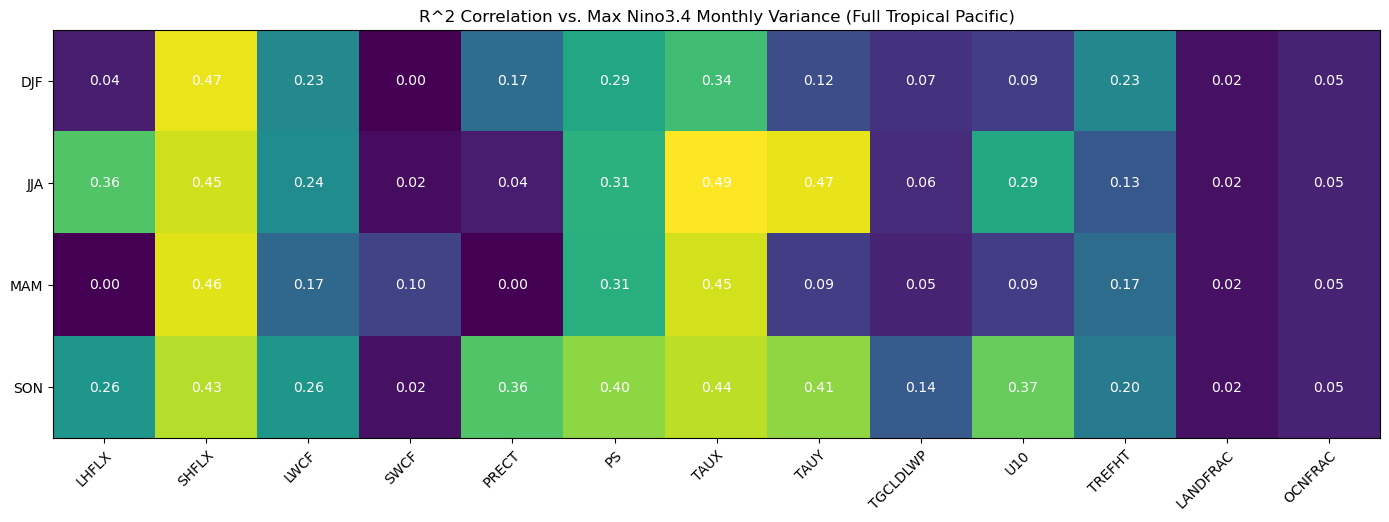

In [36]:
# make a weird plot of correlation strength...? (heat map)
correlations_arr = np.full([4, len(climoVar_list)], np.nan)

yArr = nino34_var.max(axis=1)[iKeeps]

for iSeason in range(4): 
    for iVar in range(len(climoVar_list)): 
        correlations_arr[iSeason, iVar] =  np.corrcoef(seasonal_tropPacific_all.isel(season=iSeason)[climoVar_list[iVar]].values, 
                                                       yArr)[0,1]**2

valfmt="{x:.2f}"
valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

fig, ax = plt.subplots(figsize=(14,5))
im = ax.imshow(correlations_arr)

# Show all ticks and label them with the respective list entries
ax.set_yticks(np.arange(4), labels=seasonal_tropPacific_all.season.values)
ax.set_xticks(np.arange(len(climoVar_list)), labels=climoVar_list)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(4):
    for j in range(len(climoVar_list)):
        text = ax.text(j, i, 
                       valfmt(correlations_arr[i, j], None),
                       # correlations_arr[i, j],
                       ha="center", va="center", color="w")

ax.set_title("R^2 Correlation vs. Max Nino3.4 Monthly Variance (Full Tropical Pacific)")
fig.tight_layout()
plt.show()


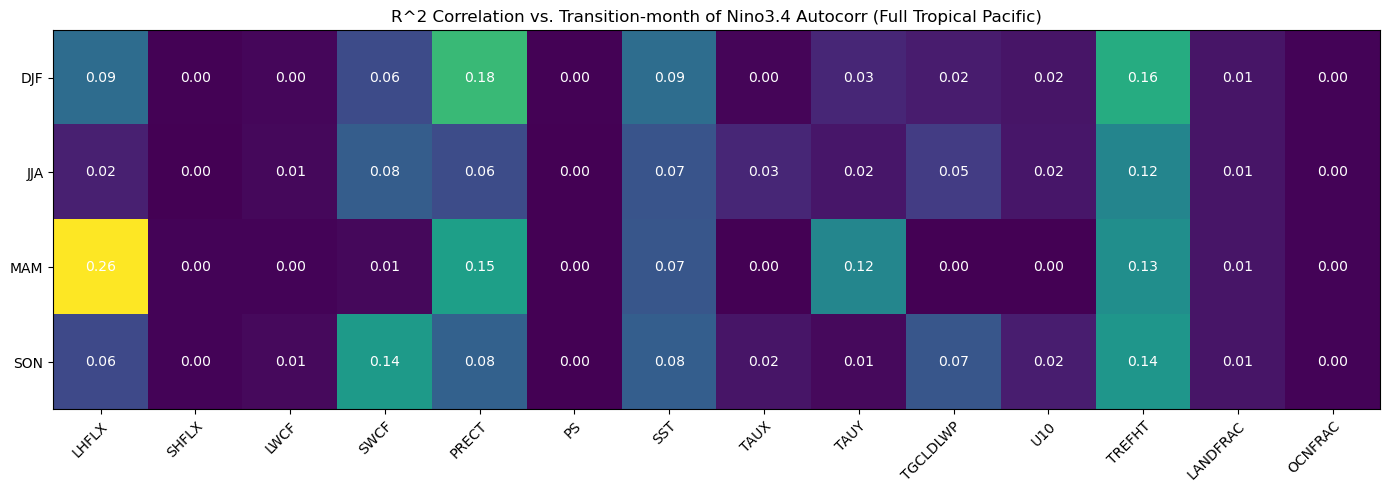

In [157]:
# make a weird plot of correlation strength...? (heat map)
correlations_arr = np.full([4, len(climoVar_list)], np.nan)

yArr = transit_month[iKeeps]

for iSeason in range(4): 
    for iVar in range(len(climoVar_list)): 
        correlations_arr[iSeason, iVar] =  np.corrcoef(seasonal_tropPacific_all.isel(season=iSeason)[climoVar_list[iVar]].values, 
                                                       yArr)[0,1]**2

valfmt="{x:.2f}"
valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

fig, ax = plt.subplots(figsize=(14,5))
im = ax.imshow(correlations_arr)

# Show all ticks and label them with the respective list entries
ax.set_yticks(np.arange(4), labels=seasonal_tropPacific_all.season.values)
ax.set_xticks(np.arange(len(climoVar_list)), labels=climoVar_list)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(4):
    for j in range(len(climoVar_list)):
        text = ax.text(j, i, 
                       valfmt(correlations_arr[i, j], None),
                       # correlations_arr[i, j],
                       ha="center", va="center", color="w")

ax.set_title("R^2 Correlation vs. Transition-month of Nino3.4 Autocorr (Full Tropical Pacific)")
fig.tight_layout()
plt.show()


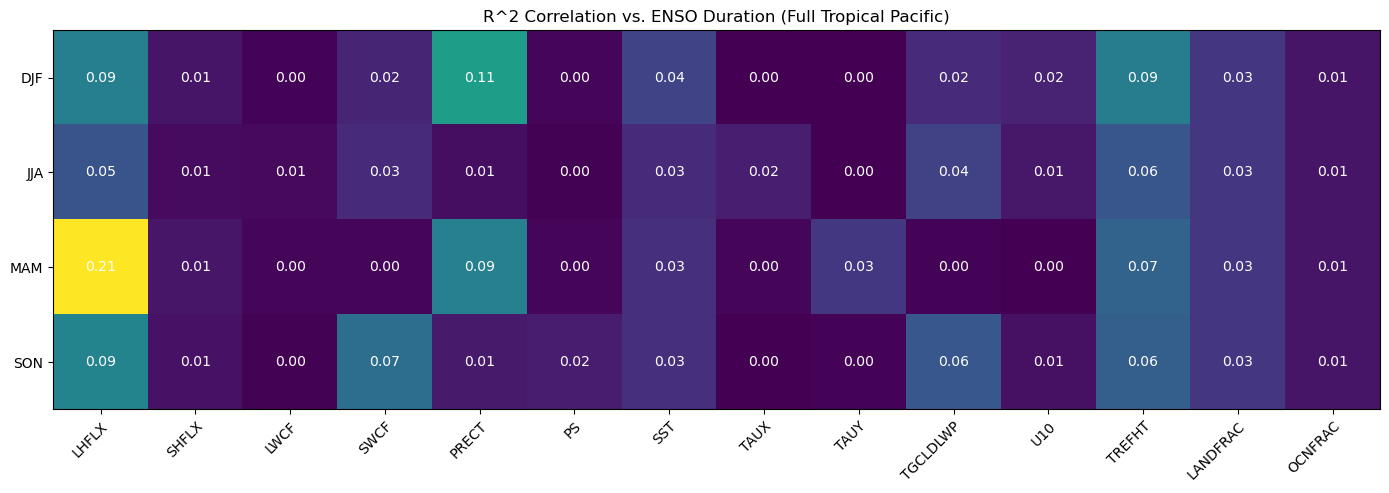

In [159]:
# make a weird plot of correlation strength...? (heat map)
correlations_arr = np.full([4, len(climoVar_list)], np.nan)

yArr = numMonthsAboveLimit[iKeeps]

for iSeason in range(4): 
    for iVar in range(len(climoVar_list)): 
        correlations_arr[iSeason, iVar] =  np.corrcoef(seasonal_tropPacific_all.isel(season=iSeason)[climoVar_list[iVar]].values, 
                                                       yArr)[0,1]**2

valfmt="{x:.2f}"
valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

fig, ax = plt.subplots(figsize=(14,5))
im = ax.imshow(correlations_arr)

# Show all ticks and label them with the respective list entries
ax.set_yticks(np.arange(4), labels=seasonal_tropPacific_all.season.values)
ax.set_xticks(np.arange(len(climoVar_list)), labels=climoVar_list)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(4):
    for j in range(len(climoVar_list)):
        text = ax.text(j, i, 
                       valfmt(correlations_arr[i, j], None),
                       # correlations_arr[i, j],
                       ha="center", va="center", color="w")

ax.set_title("R^2 Correlation vs. ENSO Duration (Full Tropical Pacific)")
fig.tight_layout()
plt.show()


In [101]:
print('- - - - - - - - - - - - - - - - - - - - - ')
print('LHFLX averaged over full Tropical Pacific')
xArr = seasonal_tropPacific_all.LHFLX
yArr = nino34_var.min(axis=1)[iKeeps]

print('JJA LHFLX vs. min nino3.4 variance: R^2 = ', np.corrcoef(xArr.sel(season='JJA').values, yArr)[0,1]**2)
print('SON LHFLX vs. min nino3.4 variance: R^2 = ', np.corrcoef(xArr.sel(season='SON').values, yArr)[0,1]**2)
print('DJF LHFLX vs. min nino3.4 variance: R^2 = ', np.corrcoef(xArr.sel(season='DJF').values, yArr)[0,1]**2)
print('MAM LHFLX vs. min nino3.4 variance: R^2 = ', np.corrcoef(xArr.sel(season='MAM').values, yArr)[0,1]**2)

print()
xArr = seasonal_tropPacific_all.LHFLX
yArr = nino34_var.max(axis=1)[iKeeps]

print('JJA LHFLX vs. max nino3.4 variance: R^2 = ', np.corrcoef(xArr.sel(season='JJA').values, yArr)[0,1]**2)
print('SON LHFLX vs. max nino3.4 variance: R^2 = ', np.corrcoef(xArr.sel(season='SON').values, yArr)[0,1]**2)
print('DJF LHFLX vs. max nino3.4 variance: R^2 = ', np.corrcoef(xArr.sel(season='DJF').values, yArr)[0,1]**2)
print('MAM LHFLX vs. max nino3.4 variance: R^2 = ', np.corrcoef(xArr.sel(season='MAM').values, yArr)[0,1]**2)

print('\n')
print('- - - - - - - - - - - - - - - - - - - - - ')
print('LHFLX averaged over East Tropical Pacific')
xArr = seasonal_tropPacific_east.LHFLX
yArr = nino34_var.min(axis=1)[iKeeps]

print('JJA LHFLX vs. min nino3.4 variance: R^2 = ', np.corrcoef(xArr.sel(season='JJA').values, yArr)[0,1]**2)
print('SON LHFLX vs. min nino3.4 variance: R^2 = ', np.corrcoef(xArr.sel(season='SON').values, yArr)[0,1]**2)
print('DJF LHFLX vs. min nino3.4 variance: R^2 = ', np.corrcoef(xArr.sel(season='DJF').values, yArr)[0,1]**2)
print('MAM LHFLX vs. min nino3.4 variance: R^2 = ', np.corrcoef(xArr.sel(season='MAM').values, yArr)[0,1]**2)

print()
xArr = seasonal_tropPacific_east.LHFLX
yArr = nino34_var.max(axis=1)[iKeeps]

print('JJA LHFLX vs. max nino3.4 variance: R^2 = ', np.corrcoef(xArr.sel(season='JJA').values, yArr)[0,1]**2)
print('SON LHFLX vs. max nino3.4 variance: R^2 = ', np.corrcoef(xArr.sel(season='SON').values, yArr)[0,1]**2)
print('DJF LHFLX vs. max nino3.4 variance: R^2 = ', np.corrcoef(xArr.sel(season='DJF').values, yArr)[0,1]**2)
print('MAM LHFLX vs. max nino3.4 variance: R^2 = ', np.corrcoef(xArr.sel(season='MAM').values, yArr)[0,1]**2)



print('\n')
print('- - - - - - - - - - - - - - - - - - - - - ')
print('LHFLX averaged over West Tropical Pacific')
xArr = seasonal_tropPacific_west.LHFLX
yArr = nino34_var.min(axis=1)[iKeeps]

print('JJA LHFLX vs. min nino3.4 variance: R^2 = ', np.corrcoef(xArr.sel(season='JJA').values, yArr)[0,1]**2)
print('SON LHFLX vs. min nino3.4 variance: R^2 = ', np.corrcoef(xArr.sel(season='SON').values, yArr)[0,1]**2)
print('DJF LHFLX vs. min nino3.4 variance: R^2 = ', np.corrcoef(xArr.sel(season='DJF').values, yArr)[0,1]**2)
print('MAM LHFLX vs. min nino3.4 variance: R^2 = ', np.corrcoef(xArr.sel(season='MAM').values, yArr)[0,1]**2)

print()
xArr = seasonal_tropPacific_east.LHFLX
yArr = nino34_var.max(axis=1)[iKeeps]

print('JJA LHFLX vs. max nino3.4 variance: R^2 = ', np.corrcoef(xArr.sel(season='JJA').values, yArr)[0,1]**2)
print('SON LHFLX vs. max nino3.4 variance: R^2 = ', np.corrcoef(xArr.sel(season='SON').values, yArr)[0,1]**2)
print('DJF LHFLX vs. max nino3.4 variance: R^2 = ', np.corrcoef(xArr.sel(season='DJF').values, yArr)[0,1]**2)
print('MAM LHFLX vs. max nino3.4 variance: R^2 = ', np.corrcoef(xArr.sel(season='MAM').values, yArr)[0,1]**2)



- - - - - - - - - - - - - - - - - - - - - 
LHFLX averaged over full Tropical Pacific
JJA LHFLX vs. min nino3.4 variance: R^2 =  0.5674474177987662
SON LHFLX vs. min nino3.4 variance: R^2 =  0.4459403101476968
DJF LHFLX vs. min nino3.4 variance: R^2 =  0.17627566689727314
MAM LHFLX vs. min nino3.4 variance: R^2 =  0.07240447827193651

JJA LHFLX vs. max nino3.4 variance: R^2 =  0.3484512398620489
SON LHFLX vs. max nino3.4 variance: R^2 =  0.25281898230755584
DJF LHFLX vs. max nino3.4 variance: R^2 =  0.039140941156370006
MAM LHFLX vs. max nino3.4 variance: R^2 =  0.0010324766460597138


- - - - - - - - - - - - - - - - - - - - - 
LHFLX averaged over East Tropical Pacific
JJA LHFLX vs. min nino3.4 variance: R^2 =  0.5431602823357646
SON LHFLX vs. min nino3.4 variance: R^2 =  0.28989465983739093
DJF LHFLX vs. min nino3.4 variance: R^2 =  0.03756496514317169
MAM LHFLX vs. min nino3.4 variance: R^2 =  0.09793497749069713

JJA LHFLX vs. max nino3.4 variance: R^2 =  0.4191296482246674
SON LHFLX

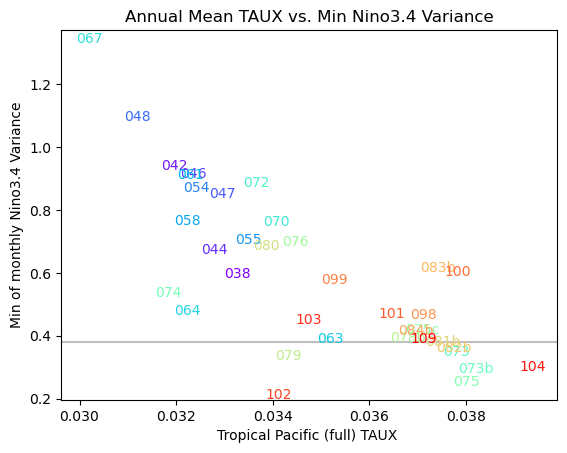

In [154]:
fig,axs = plt.subplots(1,1)

xArr = annual_tropPacific_all.TAUX
yArr = nino34_var.min(axis=1)[iKeeps]

axs.set_ylim([0.99*np.min(yArr),      1.03*np.max(yArr)])
axs.set_xlim([0.99*np.min(xArr.values), 1.02*np.max(xArr.values)])

for iCase in range(len(annual_tropPacific_all.case.values)): 
    axs.text(xArr.values[iCase], 
             yArr[iCase], 
             annual_tropPacific_all.case.values[iCase], color=colorList[iCase])

axs.set_title('Annual Mean TAUX vs. Min Nino3.4 Variance')
axs.set_xlabel('Tropical Pacific (full) TAUX ')
axs.set_ylabel('Min of monthly Nino3.4 Variance')
axs.axhline(nino34_var_obs.min(), color='grey', alpha=0.5)
plt.show()

# print(np.corrcoef(xArr.values, yArr)[0,1]**2)

In [ ]:
fig,axs = plt.subplots(1,1)

xArr = annual_tropPacific_all.TAUX
yArr = nino34_var.max(axis=1)[iKeeps]

axs.set_ylim([0.99*np.min(yArr),      1.03*np.max(yArr)])
axs.set_xlim([0.99*np.min(xArr.values), 1.02*np.max(xArr.values)])

for iCase in range(len(annual_tropPacific_all.case.values)): 
    axs.text(xArr.values[iCase], 
             yArr[iCase], 
             annual_tropPacific_all.case.values[iCase], color=colorList[iCase])

axs.set_title('Annual Mean TAUX vs. Max Nino3.4 Variance')
axs.set_xlabel('Tropical Pacific (full) TAUX ')
axs.set_ylabel('Max of monthly Nino3.4 Variance')
axs.axhline(nino34_var_obs.min(), color='grey', alpha=0.5)
plt.show()

# print(np.corrcoef(xArr.values, yArr)[0,1]**2)

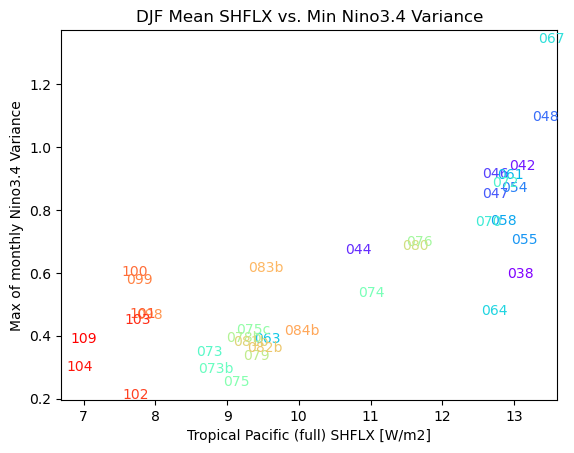

0.6284721411039028


In [143]:
fig,axs = plt.subplots(1,1)

xArr = seasonal_tropPacific_east.SHFLX.sel(season='DJF')
yArr = nino34_var.min(axis=1)[iKeeps]

axs.set_ylim([0.99*np.min(yArr),      1.03*np.max(yArr)])
axs.set_xlim([0.99*np.min(xArr.values), 1.02*np.max(xArr.values)])

for iCase in range(len(annual_tropPacific_all.case.values)): 
    axs.text(xArr.values[iCase], 
             yArr[iCase], 
             annual_tropPacific_all.case.values[iCase], color=colorList[iCase])

axs.set_title('DJF Mean SHFLX vs. Min Nino3.4 Variance')
axs.set_xlabel('Tropical Pacific (full) SHFLX [W/m2]')
axs.set_ylabel('Max of monthly Nino3.4 Variance')
plt.show()

print(np.corrcoef(xArr.values, yArr)[0,1]**2)

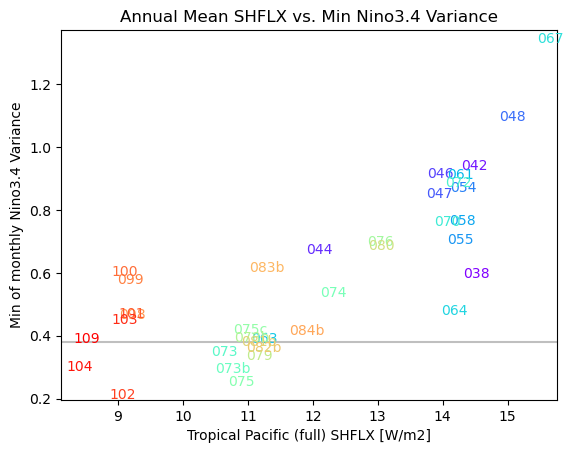

In [152]:
fig,axs = plt.subplots(1,1)

xArr = annual_tropPacific_all.SHFLX
yArr = nino34_var.min(axis=1)[iKeeps]

axs.set_ylim([0.99*np.min(yArr),      1.03*np.max(yArr)])
axs.set_xlim([0.99*np.min(xArr.values), 1.02*np.max(xArr.values)])

for iCase in range(len(annual_tropPacific_all.case.values)): 
    axs.text(xArr.values[iCase], 
             yArr[iCase], 
             annual_tropPacific_all.case.values[iCase], color=colorList[iCase])

axs.set_title('Annual Mean SHFLX vs. Min Nino3.4 Variance')
axs.set_xlabel('Tropical Pacific (full) SHFLX [W/m2]')
axs.set_ylabel('Min of monthly Nino3.4 Variance')
axs.axhline(nino34_var_obs.min(), color='grey', alpha=0.5)
plt.show()

# print(np.corrcoef(xArr.values, yArr)[0,1]**2)

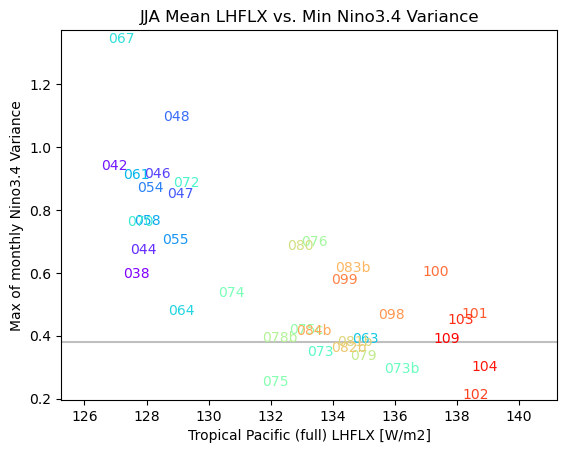

In [149]:
fig,axs = plt.subplots(1,1)

xArr = seasonal_tropPacific_east.LHFLX.sel(season='JJA')
yArr = nino34_var.min(axis=1)[iKeeps]

axs.set_ylim([0.99*np.min(yArr),      1.03*np.max(yArr)])
axs.set_xlim([0.99*np.min(xArr.values), 1.02*np.max(xArr.values)])

for iCase in range(len(annual_tropPacific_all.case.values)): 
    axs.text(xArr.values[iCase], 
             yArr[iCase], 
             annual_tropPacific_all.case.values[iCase], color=colorList[iCase])

axs.set_title('JJA Mean LHFLX vs. Min Nino3.4 Variance')
axs.set_xlabel('Tropical Pacific (full) LHFLX [W/m2]')
axs.set_ylabel('Max of monthly Nino3.4 Variance')
axs.axhline(nino34_var_obs.min(), color='grey', alpha=0.5)
plt.show()

# print(np.corrcoef(xArr.values, yArr)[0,1]**2)

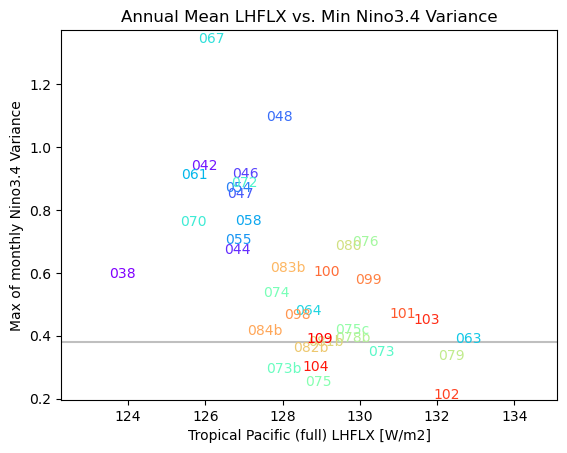

0.3731461560590106


In [150]:
fig,axs = plt.subplots(1,1)

xArr = annual_tropPacific_all.LHFLX
yArr = nino34_var.min(axis=1)[iKeeps]

axs.set_ylim([0.99*np.min(yArr),      1.03*np.max(yArr)])
axs.set_xlim([0.99*np.min(xArr.values), 1.02*np.max(xArr.values)])

for iCase in range(len(annual_tropPacific_all.case.values)): 
    axs.text(xArr.values[iCase], 
             yArr[iCase], 
             annual_tropPacific_all.case.values[iCase], color=colorList[iCase])

axs.set_title('Annual Mean LHFLX vs. Min Nino3.4 Variance')
axs.set_xlabel('Tropical Pacific (full) LHFLX [W/m2]')
axs.set_ylabel('Max of monthly Nino3.4 Variance')
axs.axhline(nino34_var_obs.min(), color='grey', alpha=0.5)
plt.show()

print(np.corrcoef(xArr.values, yArr)[0,1]**2)

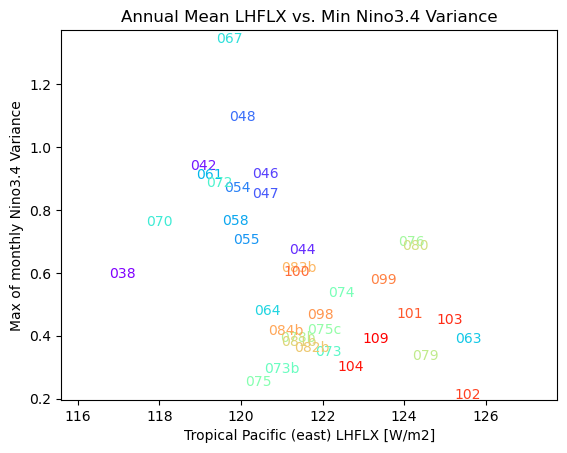

In [92]:
fig,axs = plt.subplots(1,1)

axs.set_ylim([0.99*np.min(nino34_var.min(axis=1)[iKeeps]),      1.03*np.max(nino34_var.min(axis=1)[iKeeps])])
axs.set_xlim([0.99*np.min(annual_tropPacific_east.LHFLX.values), 1.02*np.max(annual_tropPacific_east.LHFLX.values)])

for iCase in range(len(annual_tropPacific_east.case.values)): 
    axs.text(annual_tropPacific_east.LHFLX.values[iCase], 
             nino34_var.min(axis=1)[iKeeps][iCase], 
             annual_tropPacific_east.case.values[iCase], color=colorList[iCase])

axs.set_title('Annual Mean LHFLX vs. Min Nino3.4 Variance')
axs.set_xlabel('Tropical Pacific (east) LHFLX [W/m2]')
axs.set_ylabel('Max of monthly Nino3.4 Variance')
plt.show()

# print(np.corrcoef(annual_tropPacific_east.LHFLX.values, nino34_var.min(axis=1)[iKeeps])[0,1]**2)

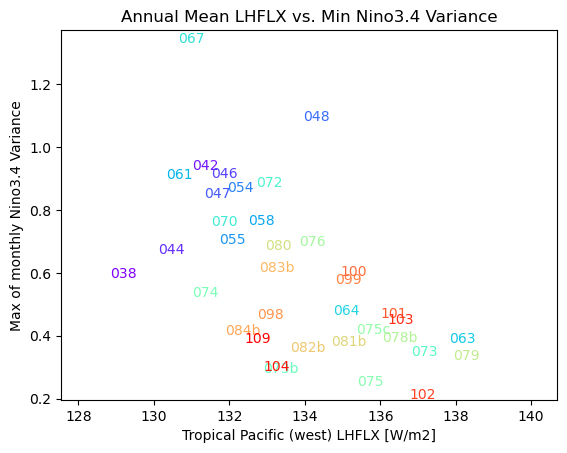

In [95]:
fig,axs = plt.subplots(1,1)

axs.set_ylim([0.99*np.min(nino34_var.min(axis=1)[iKeeps]),      1.03*np.max(nino34_var.min(axis=1)[iKeeps])])
axs.set_xlim([0.99*np.min(annual_tropPacific_west.LHFLX.values), 1.02*np.max(annual_tropPacific_west.LHFLX.values)])

for iCase in range(len(annual_tropPacific_west.case.values)): 
    axs.text(annual_tropPacific_west.LHFLX.values[iCase], 
             nino34_var.min(axis=1)[iKeeps][iCase], 
             annual_tropPacific_west.case.values[iCase], color=colorList[iCase])

axs.set_title('Annual Mean LHFLX vs. Min Nino3.4 Variance')
axs.set_xlabel('Tropical Pacific (west) LHFLX [W/m2]')
axs.set_ylabel('Max of monthly Nino3.4 Variance')
plt.show()

# print(np.corrcoef(annual_tropPacific_west.LHFLX.values, nino34_var.min(axis=1)[iKeeps])[0,1]**2)